In [12]:

import yfinance as yf

# Yahoo data is often delayed; not guaranteed real-time.
ticker = yf.Ticker("TSLA")

price = ticker.fast_info.get("lastPrice")
currency = ticker.fast_info.get("currency")
timestamp = ticker.fast_info.get("lastPriceTimestamp")

print(f"TSLA: {price} {currency} @ {timestamp}")


TSLA: 438.07000732421875 USD @ None


In [3]:
import os
os.environ["ALPHAVANTAGE_API_KEY"] = "Y33GGOSNWLE7RSGPH"
os.environ["NEWSAPI_KEY"] = "95ab0a4aa2ad4ab89799bdae9e49b125"
os.environ["FRED_API_KEY"] = "01106a5ae76b55f56f82212071a74aa1"


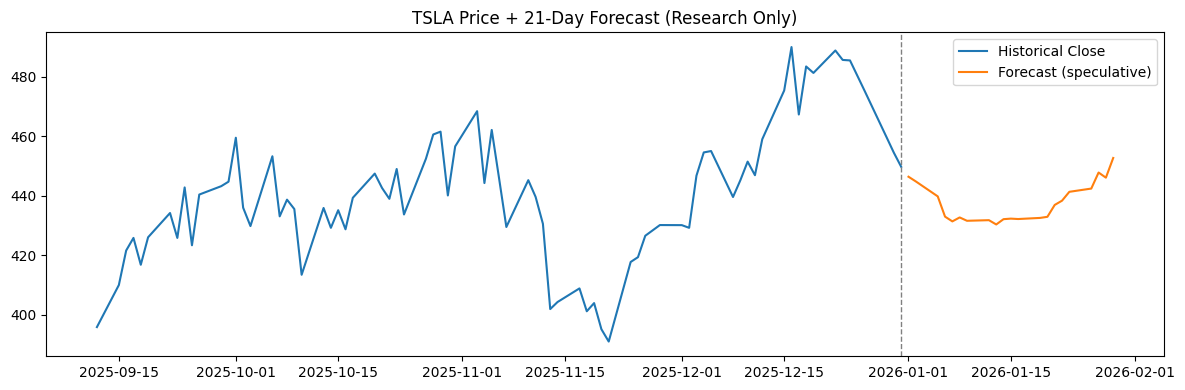

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor

def plot_price_with_forecast(ticker, period="2y", horizon_days=21, history_window=126):
    data = yf.download(ticker, period=period, interval="1d", auto_adjust=True, progress=False)
    if data is None or data.empty:
        raise ValueError(f"No data returned for {ticker}.")
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level="Ticker")

    df_sim = data.copy()
    df_sim["ret_1"] = df_sim["Close"].pct_change(1)
    df_sim["ret_5"] = df_sim["Close"].pct_change(5)
    df_sim["ret_20"] = df_sim["Close"].pct_change(20)
    df_sim["vol_20"] = df_sim["Close"].pct_change().rolling(20).std()
    df_sim["ma_20"] = df_sim["Close"].rolling(20).mean()
    df_sim["ma_50"] = df_sim["Close"].rolling(50).mean()
    df_sim["ma_ratio"] = df_sim["ma_20"] / df_sim["ma_50"]
    df_sim["vol_chg"] = df_sim["Volume"].pct_change(5)

    df_sim["target_ret_1"] = df_sim["Close"].shift(-1) / df_sim["Close"] - 1
    feat_cols = ["ret_1", "ret_5", "ret_20", "vol_20", "ma_ratio", "vol_chg"]
    df_sim = df_sim.dropna(subset=feat_cols + ["target_ret_1"])

    X = df_sim[feat_cols]
    y = df_sim["target_ret_1"]

    model = HistGradientBoostingRegressor(random_state=42)
    model.fit(X, y)

    closes = df_sim["Close"].tolist()
    vols = df_sim["Volume"].tolist()
    forecast_prices = []

    def make_features(closes, vols):
        s = pd.Series(closes)
        v = pd.Series(vols)
        ret_1 = s.pct_change(1).iloc[-1]
        ret_5 = s.pct_change(5).iloc[-1]
        ret_20 = s.pct_change(20).iloc[-1]
        vol_20 = s.pct_change().rolling(20).std().iloc[-1]
        ma_20 = s.rolling(20).mean().iloc[-1]
        ma_50 = s.rolling(50).mean().iloc[-1]
        ma_ratio = ma_20 / ma_50 if ma_50 else 0.0
        vol_chg = v.pct_change(5).iloc[-1]
        return pd.DataFrame([{
            "ret_1": ret_1,
            "ret_5": ret_5,
            "ret_20": ret_20,
            "vol_20": vol_20,
            "ma_ratio": ma_ratio,
            "vol_chg": vol_chg
        }]).fillna(0.0)

    for _ in range(horizon_days):
        X_next = make_features(closes, vols)
        ret_pred = model.predict(X_next)[0]
        next_close = closes[-1] * (1 + ret_pred)
        forecast_prices.append(next_close)
        closes.append(next_close)
        vols.append(vols[-1])  # hold volume constant

    last_date = df_sim.index[-1]
    future_dates = pd.bdate_range(last_date + pd.Timedelta(days=1), periods=horizon_days)
    forecast_df = pd.DataFrame({"date": future_dates, "pred_close": forecast_prices})

    plt.figure(figsize=(12, 4))
    hist = df_sim.iloc[-history_window:]
    plt.plot(hist.index, hist["Close"], label="Historical Close")
    plt.plot(forecast_df["date"], forecast_df["pred_close"], label="Forecast (speculative)")
    plt.axvline(hist.index[-1], color="gray", linestyle="--", linewidth=1)
    plt.title(f"{ticker} Price + {horizon_days}-Day Forecast (Research Only)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example:
plot_price_with_forecast("TSLA", period="6mo", horizon_days=21, history_window=126)


In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

def plot_price_with_forecast(
    ticker,
    period="2y",
    horizon_days=21,
    history_window=126,
    model="xgboost"
):
    data = yf.download(ticker, period=period, interval="1d", auto_adjust=True, progress=False)
    if data is None or data.empty:
        raise ValueError(f"No data returned for {ticker}.")
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level="Ticker")

    df = data.copy()
    df["ret_1"] = df["Close"].pct_change(1)
    df["ret_5"] = df["Close"].pct_change(5)
    df["ret_20"] = df["Close"].pct_change(20)
    df["vol_20"] = df["Close"].pct_change().rolling(20).std()
    df["ma_20"] = df["Close"].rolling(20).mean()
    df["ma_50"] = df["Close"].rolling(50).mean()
    df["ma_ratio"] = df["ma_20"] / df["ma_50"]
    df["vol_chg"] = df["Volume"].pct_change(5)

    df["target_ret_1"] = df["Close"].shift(-1) / df["Close"] - 1

    feat_cols = ["ret_1", "ret_5", "ret_20", "vol_20", "ma_ratio", "vol_chg"]
    df = df.dropna(subset=feat_cols + ["target_ret_1"])

    X = df[feat_cols]
    y = df["target_ret_1"]

    if model == "xgboost":
        from xgboost import XGBRegressor
        mdl = XGBRegressor(
            n_estimators=400,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
        )
        mdl.fit(X, y)

    elif model == "lightgbm":
        import lightgbm as lgb
        mdl = lgb.LGBMRegressor(
            n_estimators=400,
            max_depth=-1,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
        )
        mdl.fit(X, y)

    elif model == "rf":
        mdl = RandomForestRegressor(
            n_estimators=300,
            random_state=42,
            n_jobs=-1,
        )
        mdl.fit(X, y)

    elif model == "lstm":
        # Simple LSTM on past returns (sequence model)
        import tensorflow as tf
        from tensorflow.keras import layers, models

        series = df["target_ret_1"].dropna().values
        seq_len = 20

        X_seq, y_seq = [], []
        for i in range(seq_len, len(series)):
            X_seq.append(series[i - seq_len:i])
            y_seq.append(series[i])

        X_seq = np.array(X_seq).reshape(-1, seq_len, 1)
        y_seq = np.array(y_seq)

        lstm = models.Sequential([
            layers.Input(shape=(seq_len, 1)),
            layers.LSTM(32),
            layers.Dense(1)
        ])
        lstm.compile(optimizer="adam", loss="mse")
        lstm.fit(X_seq, y_seq, epochs=10, batch_size=32, verbose=0)

        mdl = lstm
    else:
        raise ValueError("model must be one of: xgboost, lightgbm, rf, lstm")

    closes = df["Close"].tolist()
    vols = df["Volume"].tolist()
    forecast_prices = []

    def make_features(closes, vols):
        s = pd.Series(closes)
        v = pd.Series(vols)
        ret_1 = s.pct_change(1).iloc[-1]
        ret_5 = s.pct_change(5).iloc[-1]
        ret_20 = s.pct_change(20).iloc[-1]
        vol_20 = s.pct_change().rolling(20).std().iloc[-1]
        ma_20 = s.rolling(20).mean().iloc[-1]
        ma_50 = s.rolling(50).mean().iloc[-1]
        ma_ratio = ma_20 / ma_50 if ma_50 else 0.0
        vol_chg = v.pct_change(5).iloc[-1]
        return np.array([[ret_1, ret_5, ret_20, vol_20, ma_ratio, vol_chg]])

    # LSTM uses return sequence instead of feature vector
    ret_series = df["target_ret_1"].dropna().values.tolist()

    for _ in range(horizon_days):
        if model == "lstm":
            seq = np.array(ret_series[-20:]).reshape(1, 20, 1)
            ret_pred = float(mdl.predict(seq, verbose=0)[0][0])
            ret_series.append(ret_pred)
        else:
            X_next = make_features(closes, vols)
            ret_pred = float(mdl.predict(X_next)[0])

        next_close = closes[-1] * (1 + ret_pred)
        forecast_prices.append(next_close)
        closes.append(next_close)
        vols.append(vols[-1])

    last_date = df.index[-1]
    future_dates = pd.bdate_range(last_date + pd.Timedelta(days=1), periods=horizon_days)
    forecast_df = pd.DataFrame({"date": future_dates, "pred_close": forecast_prices})

    plt.figure(figsize=(12, 4))
    hist = df.iloc[-history_window:]
    plt.plot(hist.index, hist["Close"], label="Historical Close")
    plt.plot(forecast_df["date"], forecast_df["pred_close"], label=f"Forecast ({model})")
    plt.axvline(hist.index[-1], color="gray", linestyle="--", linewidth=1)
    plt.title(f"{ticker} Price + {horizon_days}-Day Forecast (Research Only)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Examples:



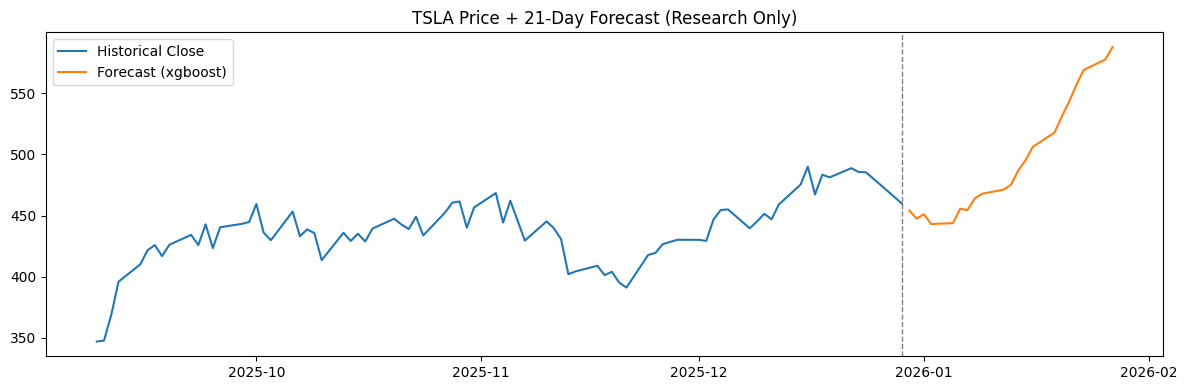

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 6
[LightGBM] [Info] Start training from score 0.003929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

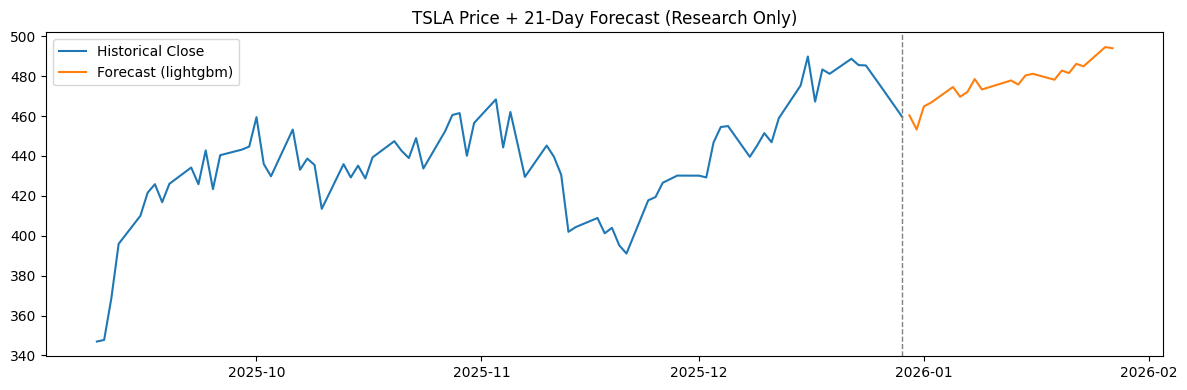

In [ ]:
 # plot_price_with_forecast("TSLA", period="6mo", horizon_days=21, history_window=126, model="xgboost")
# plot_price_with_forecast("TSLA", period="6mo", horizon_days=21, history_window=126, model="lightgbm")
# plot_price_with_forecast("TSLA", period="6mo", horizon_days=21, history_window=126, model="rf")
# plot_price_with_forecast("TSLA", period="6mo", horizon_days=21, history_window=126, model="lstm")

In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

def plot_forecast_compare(
    ticker,
    period="2y",
    horizon_days=21,
    history_window=126,
    models=("xgboost", "rf", "lstm"),
    fast_lstm=True
):
    forecasts = {}

    data = yf.download(ticker, period=period, interval="1d", auto_adjust=True, progress=False)
    if data is None or data.empty:
        raise ValueError(f"No data returned for {ticker}.")
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level="Ticker")

    df = data.copy()
    df["ret_1"] = df["Close"].pct_change(1)
    df["ret_5"] = df["Close"].pct_change(5)
    df["ret_20"] = df["Close"].pct_change(20)
    df["vol_20"] = df["Close"].pct_change().rolling(20).std()
    df["ma_20"] = df["Close"].rolling(20).mean()
    df["ma_50"] = df["Close"].rolling(50).mean()
    df["ma_ratio"] = df["ma_20"] / df["ma_50"]
    df["vol_chg"] = df["Volume"].pct_change(5)
    df["target_ret_1"] = df["Close"].shift(-1) / df["Close"] - 1

    feat_cols = ["ret_1", "ret_5", "ret_20", "vol_20", "ma_ratio", "vol_chg"]
    df = df.dropna(subset=feat_cols + ["target_ret_1"])

    def make_features(closes, vols):
        s = pd.Series(closes)
        v = pd.Series(vols)
        ret_1 = s.pct_change(1).iloc[-1]
        ret_5 = s.pct_change(5).iloc[-1]
        ret_20 = s.pct_change(20).iloc[-1]
        vol_20 = s.pct_change().rolling(20).std().iloc[-1]
        ma_20 = s.rolling(20).mean().iloc[-1]
        ma_50 = s.rolling(50).mean().iloc[-1]
        ma_ratio = ma_20 / ma_50 if ma_50 else 0.0
        vol_chg = v.pct_change(5).iloc[-1]
        return pd.DataFrame([{
            "ret_1": ret_1,
            "ret_5": ret_5,
            "ret_20": ret_20,
            "vol_20": vol_20,
            "ma_ratio": ma_ratio,
            "vol_chg": vol_chg
        }], columns=feat_cols).fillna(0.0)

    def forecast_with_model(model_name):
        X = df[feat_cols]
        y = df["target_ret_1"]

        if model_name == "xgboost":
            from xgboost import XGBRegressor
            mdl = XGBRegressor(
                n_estimators=200,
                max_depth=3,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
            )
            mdl.fit(X, y)

        elif model_name == "lightgbm":
            import lightgbm as lgb
            mdl = lgb.LGBMRegressor(
                n_estimators=200,
                num_leaves=31,
                learning_rate=0.1,
                min_data_in_leaf=5,
                min_gain_to_split=0.0,
                force_col_wise=True,
                random_state=42,
            )
            mdl.fit(X, y)

        elif model_name == "rf":
            mdl = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1)
            mdl.fit(X, y)

        elif model_name == "lstm":
            from tensorflow.keras import layers, models

            series = df["target_ret_1"].dropna().values
            seq_len = 10 if fast_lstm else 20
            X_seq, y_seq = [], []
            for i in range(seq_len, len(series)):
                X_seq.append(series[i - seq_len:i])
                y_seq.append(series[i])
            X_seq = np.array(X_seq).reshape(-1, seq_len, 1)
            y_seq = np.array(y_seq)

            units = 8 if fast_lstm else 32
            epochs = 2 if fast_lstm else 5
            batch = 128 if fast_lstm else 32

            lstm = models.Sequential([
                layers.Input(shape=(seq_len, 1)),
                layers.LSTM(units),
                layers.Dense(1)
            ])
            lstm.compile(optimizer="adam", loss="mse")
            lstm.fit(X_seq, y_seq, epochs=epochs, batch_size=batch, verbose=0)
            mdl = lstm

        else:
            raise ValueError("Unknown model")

        closes = df["Close"].tolist()
        vols = df["Volume"].tolist()
        ret_series = df["target_ret_1"].dropna().values.tolist()
        forecast_prices = []

        for _ in range(horizon_days):
            if model_name == "lstm":
                seq_len = 10 if fast_lstm else 20
                seq = np.array(ret_series[-seq_len:]).reshape(1, seq_len, 1)
                ret_pred = float(mdl.predict(seq, verbose=0)[0][0])
                ret_series.append(ret_pred)
            else:
                X_next = make_features(closes, vols)
                ret_pred = float(mdl.predict(X_next)[0])

            next_close = closes[-1] * (1 + ret_pred)
            forecast_prices.append(next_close)
            closes.append(next_close)
            vols.append(vols[-1])

        return forecast_prices

    for m in models:
        forecasts[m] = forecast_with_model(m)

    last_date = df.index[-1]
    future_dates = pd.bdate_range(last_date + pd.Timedelta(days=1), periods=horizon_days)

    plt.figure(figsize=(12, 4))
    hist = df.iloc[-history_window:]
    plt.plot(hist.index, hist["Close"], label="Historical Close", linewidth=2)

    for m in models:
        plt.plot(future_dates, forecasts[m], label=f"Forecast {m}")

    plt.axvline(hist.index[-1], color="gray", linestyle="--", linewidth=1)
    plt.title(f"{ticker} - {horizon_days}-Day Forecast Comparison (Research Only)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


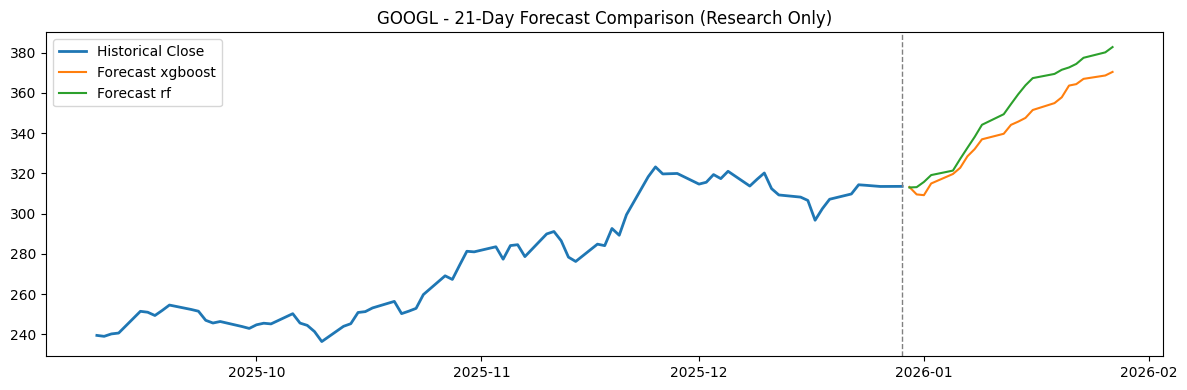

In [8]:
plot_forecast_compare("GOOGL", period="6mo", horizon_days=21, history_window=126, models=("xgboost","rf"))


In [ ]:
plot_forecast_compare_finbert("TSLA", period="6mo", horizon_days=21, history_window=126, models=("xgboost","rf"))


In [ ]:
import os
import yfinance as yf
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from transformers import pipeline

# Global cached FinBERT pipeline (one-time init)
SENTIMENT = pipeline("sentiment-analysis", model="ProsusAI/finbert")

In [ ]:
import os
import yfinance as yf
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from transformers import pipeline

# Global cached FinBERT pipeline (one-time init)
SENTIMENT = pipeline("sentiment-analysis", model="ProsusAI/finbert")

def _finbert_news_sentiment(ticker, days=7, page_size=30):
    NEWSAPI_KEY = os.getenv("NEWSAPI_KEY")
    if not NEWSAPI_KEY:
        raise ValueError("NEWSAPI_KEY not set in environment.")

    end_date = pd.Timestamp.today().date()
    start_date = end_date - pd.Timedelta(days=days)

    news_url = "https://newsapi.org/v2/everything"
    news_params = {
        "q": ticker,
        "from": start_date.isoformat(),
        "to": end_date.isoformat(),
        "language": "en",
        "sortBy": "publishedAt",
        "pageSize": page_size,
        "apiKey": NEWSAPI_KEY,
    }
    news_resp = requests.get(news_url, params=news_params, timeout=30)
    news_resp.raise_for_status()
    articles = news_resp.json().get("articles", [])

    if not articles:
        return pd.DataFrame({"news_sent": []})

    rows = []
    for item in articles:
        title = item.get("title", "") or ""
        desc = item.get("description", "") or ""
        text = f"{title} {desc}".strip()
        if not text:
            continue

        published = item.get("publishedAt", "")
        if not published:
            continue
        date = pd.to_datetime(published, errors="coerce").date()
        if pd.isna(date):
            continue

        try:
            result = SENTIMENT(text[:512])[0]
            label = result["label"].lower()
            score = result["score"]
            sent = score if label == "positive" else (-score if label == "negative" else 0.0)
            rows.append({"date": date, "sent": sent})
        except Exception:
            continue

    news_df = pd.DataFrame(rows)
    if news_df.empty:
        return pd.DataFrame({"news_sent": []})

    return news_df.groupby("date")["sent"].mean().to_frame("news_sent")


def plot_forecast_compare_finbert_fast(
    ticker,
    period="2y",
    horizon_days=21,
    history_window=126,
    models=("rf",),   # default only RF
    news_days=7,
    page_size=30
):
    forecasts = {}

    data = yf.download(ticker, period=period, interval="1d", auto_adjust=True, progress=False)
    if data is None or data.empty:
        raise ValueError(f"No data returned for {ticker}.")
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level="Ticker")

    df = data.copy()

    # FinBERT news sentiment (fast)
    news_daily = _finbert_news_sentiment(ticker, days=news_days, page_size=page_size)

    df = df.reset_index().rename(columns={"Date": "date"}).set_index("date")
    df = df.merge(news_daily, left_index=True, right_index=True, how="left")
    df["news_sent"] = df["news_sent"].fillna(0.0)

    # Price/volume features
    df["ret_1"] = df["Close"].pct_change(1)
    df["ret_5"] = df["Close"].pct_change(5)
    df["ret_20"] = df["Close"].pct_change(20)
    df["vol_20"] = df["Close"].pct_change().rolling(20).std()
    df["ma_20"] = df["Close"].rolling(20).mean()
    df["ma_50"] = df["Close"].rolling(50).mean()
    df["ma_ratio"] = df["ma_20"] / df["ma_50"]
    df["vol_chg"] = df["Volume"].pct_change(5)
    df["target_ret_1"] = df["Close"].shift(-1) / df["Close"] - 1

    feat_cols = ["ret_1", "ret_5", "ret_20", "vol_20", "ma_ratio", "vol_chg", "news_sent"]
    df = df.dropna(subset=feat_cols + ["target_ret_1"])

    def make_features(closes, vols, news_sent):
        s = pd.Series(closes)
        v = pd.Series(vols)
        ret_1 = s.pct_change(1).iloc[-1]
        ret_5 = s.pct_change(5).iloc[-1]
        ret_20 = s.pct_change(20).iloc[-1]
        vol_20 = s.pct_change().rolling(20).std().iloc[-1]
        ma_20 = s.rolling(20).mean().iloc[-1]
        ma_50 = s.rolling(50).mean().iloc[-1]
        ma_ratio = ma_20 / ma_50 if ma_50 else 0.0
        vol_chg = v.pct_change(5).iloc[-1]
        return pd.DataFrame([{
            "ret_1": ret_1,
            "ret_5": ret_5,
            "ret_20": ret_20,
            "vol_20": vol_20,
            "ma_ratio": ma_ratio,
            "vol_chg": vol_chg,
            "news_sent": news_sent
        }], columns=feat_cols).fillna(0.0)

    def forecast_with_model(model_name):
        X = df[feat_cols]
        y = df["target_ret_1"]

        if model_name == "xgboost":
            from xgboost import XGBRegressor
            mdl = XGBRegressor(
                n_estimators=120,
                max_depth=3,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
            )
            mdl.fit(X, y)

        elif model_name == "lightgbm":
            import lightgbm as lgb
            mdl = lgb.LGBMRegressor(
                n_estimators=120,
                num_leaves=31,
                learning_rate=0.1,
                min_data_in_leaf=5,
                min_gain_to_split=0.0,
                force_col_wise=True,
                random_state=42,
            )
            mdl.fit(X, y)

        elif model_name == "rf":
            mdl = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
            mdl.fit(X, y)

        else:
            raise ValueError("Unknown model")

        closes = df["Close"].tolist()
        vols = df["Volume"].tolist()
        news_sent = float(df["news_sent"].iloc[-1])
        forecast_prices = []

        for _ in range(horizon_days):
            X_next = make_features(closes, vols, news_sent)
            ret_pred = float(mdl.predict(X_next)[0])
            next_close = closes[-1] * (1 + ret_pred)
            forecast_prices.append(next_close)
            closes.append(next_close)
            vols.append(vols[-1])

        return forecast_prices

    for m in models:
        forecasts[m] = forecast_with_model(m)

    last_date = df.index[-1]
    future_dates = pd.bdate_range(last_date + pd.Timedelta(days=1), periods=horizon_days)

    plt.figure(figsize=(12, 4))
    hist = df.iloc[-history_window:]
    plt.plot(hist.index, hist["Close"], label="Historical Close", linewidth=2)

    for m in models:
        plt.plot(future_dates, forecasts[m], label=f"Forecast {m}")

    plt.axvline(hist.index[-1], color="gray", linestyle="--", linewidth=1)
    plt.title(f"{ticker} - {horizon_days}-Day Forecast (Fast FinBERT)")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [22]:
import os
import re
import yfinance as yf
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

import os
os.environ["ALPHAVANTAGE_API_KEY"] = "Y33GGOSNWLE7RSGPH"
os.environ["NEWSAPI_KEY"] = "95ab0a4aa2ad4ab89799bdae9e49b125"

def _lexicon_news_sentiment(ticker, days=30, page_size=100):
    NEWSAPI_KEY = os.getenv("NEWSAPI_KEY")
    if not NEWSAPI_KEY:
        raise ValueError("NEWSAPI_KEY not set in environment.")

    end_date = pd.Timestamp.today().date()
    start_date = end_date - pd.Timedelta(days=days)

    news_url = "https://newsapi.org/v2/everything"
    news_params = {
        "q": ticker,
        "from": start_date.isoformat(),
        "to": end_date.isoformat(),
        "language": "en",
        "sortBy": "publishedAt",
        "pageSize": page_size,
        "apiKey": NEWSAPI_KEY,
    }
    news_resp = requests.get(news_url, params=news_params, timeout=30)
    news_resp.raise_for_status()
    articles = news_resp.json().get("articles", [])

    if not articles:
        return pd.DataFrame({"news_sent": []})

    pos_words = {
        "beat","growth","surge","record","profit","upgrade","outperform","strong","buy",
        "bullish","rally","rebound","accelerate","expand","improve","optimistic","raise",
        "momentum","breakout","gain","positive","upside","robust","recover","increase"
    }
    neg_words = {
        "miss","lawsuit","downgrade","decline","weak","sell","loss","drop","cut",
        "bearish","slump","plunge","slowdown","shrink","warning","pessimistic","lower",
        "headwind","risk","downside","negative","underperform","reduce","decrease","fall"
    }

    def sentiment_score(text):
        words = re.findall(r"[a-z]+", text.lower())
        pos = sum(1 for w in words if w in pos_words)
        neg = sum(1 for w in words if w in neg_words)
        total = pos + neg
        if total == 0:
            return 0.0
        return (pos - neg) / total

    rows = []
    for item in articles:
        title = item.get("title", "") or ""
        desc = item.get("description", "") or ""
        text = f"{title} {desc}".strip()
        if not text:
            continue

        published = item.get("publishedAt", "")
        if not published:
            continue
        date = pd.to_datetime(published, errors="coerce").date()
        if pd.isna(date):
            continue

        rows.append({"date": date, "sent": sentiment_score(text)})

    news_df = pd.DataFrame(rows)
    if news_df.empty:
        return pd.DataFrame({"news_sent": []})

    return news_df.groupby("date")["sent"].mean().to_frame("news_sent")


def _alphavantage_fundamentals(ticker):
    AV_KEY = os.getenv("ALPHAVANTAGE_API_KEY")
    if not AV_KEY:
        raise ValueError("ALPHAVANTAGE_API_KEY not set in environment.")

    def av_get(function_name):
        url = "https://www.alphavantage.co/query"
        params = {"function": function_name, "symbol": ticker, "apikey": AV_KEY}
        resp = requests.get(url, params=params, timeout=30)
        resp.raise_for_status()
        return resp.json()

    def to_float(value):
        try:
            return float(value)
        except (TypeError, ValueError):
            return np.nan

    overview = av_get("OVERVIEW")
    income = av_get("INCOME_STATEMENT")

    if income.get("Note") or income.get("Information") or income.get("Error Message"):
        print("Alpha Vantage message:", income.get("Note") or income.get("Information") or income.get("Error Message"))

    quarterly = pd.DataFrame(income.get("quarterlyReports", []))
    annual = pd.DataFrame(income.get("annualReports", []))

    if not quarterly.empty:
        reports = quarterly
    elif not annual.empty:
        reports = annual
    else:
        # fallback: no fundamentals available
        return pd.DataFrame(columns=["date","totalRevenue","netIncome","pe_ratio","eps","profit_margin"])

    reports["fiscalDateEnding"] = pd.to_datetime(reports["fiscalDateEnding"], errors="coerce")
    reports["totalRevenue"] = pd.to_numeric(reports["totalRevenue"], errors="coerce")
    reports["netIncome"] = pd.to_numeric(reports["netIncome"], errors="coerce")
    reports = reports.sort_values("fiscalDateEnding")

    fund = reports[["fiscalDateEnding","totalRevenue","netIncome"]].copy()
    fund = fund.rename(columns={"fiscalDateEnding":"date"})

    fund["pe_ratio"] = to_float(overview.get("PERatio"))
    fund["eps"] = to_float(overview.get("EPS"))
    fund["profit_margin"] = to_float(overview.get("ProfitMargin"))

    return fund.dropna(subset=["date"])


def plot_forecast_compare_fast_lexicon(
    ticker,
    period="2y",
    horizon_days=21,
    history_window=126,
    models=("rf",),
    news_days=7,
    page_size=30
):
    data = yf.download(ticker, period=period, interval="1d", auto_adjust=True, progress=False)
    if data is None or data.empty:
        raise ValueError(f"No data returned for {ticker}.")
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level="Ticker")

    df = data.copy()

    # News sentiment
    news_daily = _lexicon_news_sentiment(ticker, days=news_days, page_size=page_size)

    # Fundamentals
    fund = _alphavantage_fundamentals(ticker)

    df = df.reset_index().rename(columns={"Date": "date"})
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    if not fund.empty:
        fund["date"] = pd.to_datetime(fund["date"], errors="coerce")
        fund = fund.sort_values("date")
        df = pd.merge_asof(df.sort_values("date"), fund, on="date", direction="backward")
    else:
        df["totalRevenue"] = 0.0
        df["netIncome"] = 0.0
        df["pe_ratio"] = 0.0
        df["eps"] = 0.0
        df["profit_margin"] = 0.0

    df = df.set_index("date")
    df = df.merge(news_daily, left_index=True, right_index=True, how="left")
    df["news_sent"] = df["news_sent"].fillna(0.0)

    # Price/volume features
    df["ret_1"] = df["Close"].pct_change(1)
    df["ret_5"] = df["Close"].pct_change(5)
    df["ret_20"] = df["Close"].pct_change(20)
    df["vol_20"] = df["Close"].pct_change().rolling(20).std()
    df["ma_20"] = df["Close"].rolling(20).mean()
    df["ma_50"] = df["Close"].rolling(50).mean()
    df["ma_ratio"] = df["ma_20"] / df["ma_50"]
    df["vol_chg"] = df["Volume"].pct_change(5)
    df["target_ret_1"] = df["Close"].shift(-1) / df["Close"] - 1

    fund_cols = ["totalRevenue","netIncome","pe_ratio","eps","profit_margin"]
    df[fund_cols] = df[fund_cols].ffill()

    feat_cols = ["ret_1","ret_5","ret_20","vol_20","ma_ratio","vol_chg","news_sent"] + fund_cols
    df = df.dropna(subset=feat_cols + ["target_ret_1"])

    def make_features(closes, vols, news_sent, fund_last):
        s = pd.Series(closes)
        v = pd.Series(vols)
        ret_1 = s.pct_change(1).iloc[-1]
        ret_5 = s.pct_change(5).iloc[-1]
        ret_20 = s.pct_change(20).iloc[-1]
        vol_20 = s.pct_change().rolling(20).std().iloc[-1]
        ma_20 = s.rolling(20).mean().iloc[-1]
        ma_50 = s.rolling(50).mean().iloc[-1]
        ma_ratio = ma_20 / ma_50 if ma_50 else 0.0
        vol_chg = v.pct_change(5).iloc[-1]
        row = {
            "ret_1": ret_1, "ret_5": ret_5, "ret_20": ret_20,
            "vol_20": vol_20, "ma_ratio": ma_ratio, "vol_chg": vol_chg,
            "news_sent": news_sent,
            "totalRevenue": fund_last["totalRevenue"],
            "netIncome": fund_last["netIncome"],
            "pe_ratio": fund_last["pe_ratio"],
            "eps": fund_last["eps"],
            "profit_margin": fund_last["profit_margin"],
        }
        return pd.DataFrame([row], columns=feat_cols).fillna(0.0)

    def forecast_with_model(model_name):
        X = df[feat_cols]
        y = df["target_ret_1"]

        if model_name == "xgboost":
            from xgboost import XGBRegressor
            mdl = XGBRegressor(
                n_estimators=120,
                max_depth=3,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
            )
            mdl.fit(X, y)
        elif model_name == "rf":
            mdl = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
            mdl.fit(X, y)
        else:
            raise ValueError("Unknown model")

        closes = df["Close"].tolist()
        vols = df["Volume"].tolist()
        news_sent = float(df["news_sent"].iloc[-1])
        fund_last = df[fund_cols].iloc[-1].to_dict()
        forecast_prices = []

        for _ in range(horizon_days):
            X_next = make_features(closes, vols, news_sent, fund_last)
            ret_pred = float(mdl.predict(X_next)[0])
            next_close = closes[-1] * (1 + ret_pred)
            forecast_prices.append(next_close)
            closes.append(next_close)
            vols.append(vols[-1])

        return forecast_prices

    forecasts = {}
    for m in models:
        forecasts[m] = forecast_with_model(m)

    last_date = df.index[-1]
    future_dates = pd.bdate_range(last_date + pd.Timedelta(days=1), periods=horizon_days)

    plt.figure(figsize=(12, 4))
    hist = df.iloc[-history_window:]
    plt.plot(hist.index, hist["Close"], label="Historical Close", linewidth=2)

    for m in models:
        plt.plot(future_dates, forecasts[m], label=f"Forecast {m}")

    plt.axvline(hist.index[-1], color="gray", linestyle="--", linewidth=1)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.title(f"{ticker} - {horizon_days}-Day Forecast (News + Fundamentals)")
    plt.legend()
    plt.tight_layout()
    plt.show()


Alpha Vantage message: Thank you for using Alpha Vantage! Please consider spreading out your free API requests more sparingly (1 request per second). You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to lift the free key rate limit (25 requests per day), raise the per-second burst limit, and instantly unlock all premium endpoints


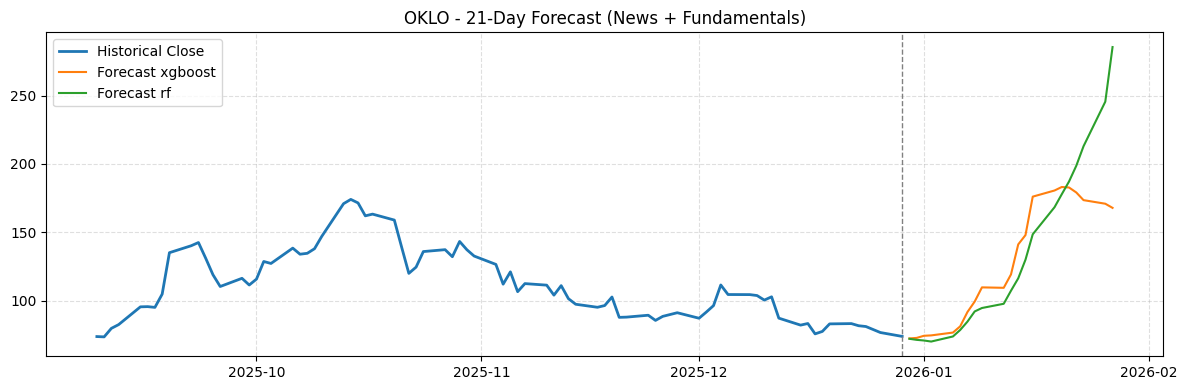

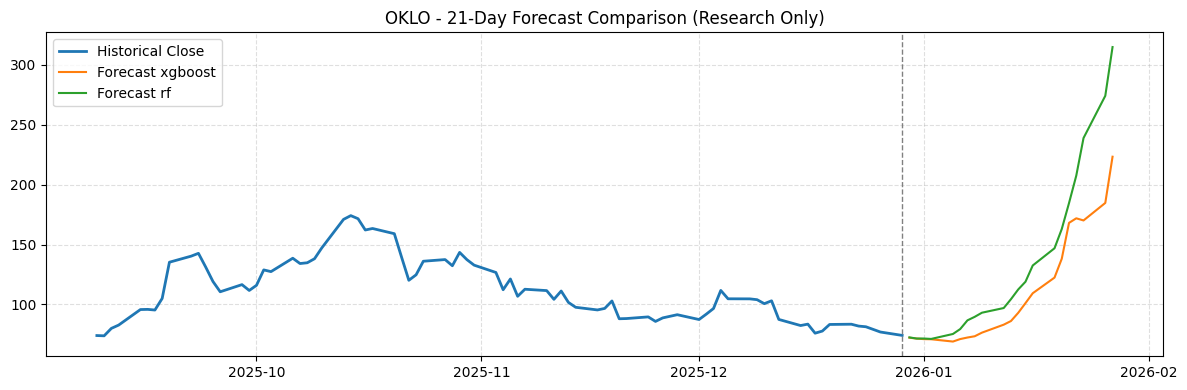

In [26]:
stock = "OKLO"
plot_forecast_compare_fast_lexicon(stock, period="6mo", horizon_days=21, history_window=126, models=("xgboost", "rf"))
plot_forecast_compare(stock, period="6mo", horizon_days=21, history_window=126, models=("xgboost","rf"))


高级版本

In [ ]:
import os
os.environ["FRED_API_KEY"] = "01106a5ae76b55f56f82212071a74aa1"



In [7]:
import os
import re
import yfinance as yf
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from pandas_datareader import data as pdr

def _lexicon_news_sentiment(ticker, days=7, page_size=30):
    NEWSAPI_KEY = os.getenv("NEWSAPI_KEY")
    if not NEWSAPI_KEY:
        raise ValueError("NEWSAPI_KEY not set in environment.")

    end_date = pd.Timestamp.today().date()
    start_date = end_date - pd.Timedelta(days=days)

    news_url = "https://newsapi.org/v2/everything"
    news_params = {
        "q": ticker,
        "from": start_date.isoformat(),
        "to": end_date.isoformat(),
        "language": "en",
        "sortBy": "publishedAt",
        "pageSize": page_size,
        "apiKey": NEWSAPI_KEY,
    }
    news_resp = requests.get(news_url, params=news_params, timeout=30)
    news_resp.raise_for_status()
    articles = news_resp.json().get("articles", [])

    if not articles:
        return pd.DataFrame({"news_sent": []})

    pos_words = {
        "beat","growth","surge","record","profit","upgrade","outperform","strong","buy",
        "bullish","rally","rebound","accelerate","expand","improve","optimistic","raise",
        "momentum","breakout","gain","positive","upside","robust","recover","increase"
    }
    neg_words = {
        "miss","lawsuit","downgrade","decline","weak","sell","loss","drop","cut",
        "bearish","slump","plunge","slowdown","shrink","warning","pessimistic","lower",
        "headwind","risk","downside","negative","underperform","reduce","decrease","fall"
    }

    def sentiment_score(text):
        words = re.findall(r"[a-z]+", text.lower())
        pos = sum(1 for w in words if w in pos_words)
        neg = sum(1 for w in words if w in neg_words)
        total = pos + neg
        if total == 0:
            return 0.0
        return (pos - neg) / total

    rows = []
    for item in articles:
        title = item.get("title", "") or ""
        desc = item.get("description", "") or ""
        text = f"{title} {desc}".strip()
        if not text:
            continue
        published = item.get("publishedAt", "")
        if not published:
            continue
        date = pd.to_datetime(published, errors="coerce").date()
        if pd.isna(date):
            continue
        rows.append({"date": date, "sent": sentiment_score(text)})

    news_df = pd.DataFrame(rows)
    if news_df.empty:
        return pd.DataFrame({"news_sent": []})

    return news_df.groupby("date")["sent"].mean().to_frame("news_sent")


def _alphavantage_fundamentals(ticker):
    AV_KEY = os.getenv("ALPHAVANTAGE_API_KEY")
    if not AV_KEY:
        raise ValueError("ALPHAVANTAGE_API_KEY not set in environment.")

    def av_get(function_name):
        url = "https://www.alphavantage.co/query"
        params = {"function": function_name, "symbol": ticker, "apikey": AV_KEY}
        resp = requests.get(url, params=params, timeout=30)
        resp.raise_for_status()
        return resp.json()

    def to_float(value):
        try:
            return float(value)
        except (TypeError, ValueError):
            return np.nan

    overview = av_get("OVERVIEW")
    income = av_get("INCOME_STATEMENT")

    quarterly = pd.DataFrame(income.get("quarterlyReports", []))
    annual = pd.DataFrame(income.get("annualReports", []))
    if not quarterly.empty:
        reports = quarterly
    elif not annual.empty:
        reports = annual
    else:
        return pd.DataFrame(columns=["date","totalRevenue","netIncome","pe_ratio","eps","profit_margin"])

    reports["fiscalDateEnding"] = pd.to_datetime(reports["fiscalDateEnding"], errors="coerce")
    reports["totalRevenue"] = pd.to_numeric(reports["totalRevenue"], errors="coerce")
    reports["netIncome"] = pd.to_numeric(reports["netIncome"], errors="coerce")
    reports = reports.sort_values("fiscalDateEnding")

    fund = reports[["fiscalDateEnding","totalRevenue","netIncome"]].copy()
    fund = fund.rename(columns={"fiscalDateEnding":"date"})
    fund["pe_ratio"] = to_float(overview.get("PERatio"))
    fund["eps"] = to_float(overview.get("EPS"))
    fund["profit_margin"] = to_float(overview.get("ProfitMargin"))
    return fund.dropna(subset=["date"])


def _download_index(ticker, prefix):
    idx = yf.download(ticker, period="10y", interval="1d", auto_adjust=True, progress=False)
    if idx is None or idx.empty:
        return None
    if isinstance(idx.columns, pd.MultiIndex):
        idx = idx.xs(ticker, axis=1, level="Ticker")
    idx = idx.dropna()
    idx[f"{prefix}_ret_1"] = idx["Close"].pct_change(1)
    idx[f"{prefix}_vol_20"] = idx["Close"].pct_change().rolling(20).std()
    return idx[[f"{prefix}_ret_1", f"{prefix}_vol_20"]]


def _fred_series(series_id, start="2000-01-01"):
    key = os.getenv("FRED_API_KEY")
    if not key:
        return None
    try:
        s = pdr.DataReader(series_id, "fred", start=start)
        s = s.rename(columns={series_id: series_id})
        return s
    except Exception:
        return None


def build_extra_features(start="2000-01-01"):
    spy = _download_index("SPY", "spy")
    qqq = _download_index("QQQ", "qqq")
    vix = _download_index("^VIX", "vix")
    xlk = _download_index("XLK", "xlk")

    dgs10 = _fred_series("DGS10", start=start)
    fedfunds = _fred_series("FEDFUNDS", start=start)
    cpi = _fred_series("CPIAUCSL", start=start)

    macro = []
    for s in [dgs10, fedfunds, cpi]:
        if s is not None:
            macro.append(s)

    macro_df = None
    if macro:
        macro_df = pd.concat(macro, axis=1).sort_index().ffill()

    return {"spy": spy, "qqq": qqq, "vix": vix, "xlk": xlk, "macro": macro_df}


def plot_forecast_compare_full(
    ticker,
    period="2y",
    horizon_days=21,
    history_window=126,
    models=("rf",),
    news_days=7,
    page_size=30
):
    data = yf.download(ticker, period=period, interval="1d", auto_adjust=True, progress=False)
    if data is None or data.empty:
        raise ValueError(f"No data returned for {ticker}.")
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level="Ticker")

    df = data.copy()

    news_daily = _lexicon_news_sentiment(ticker, days=news_days, page_size=page_size)
    fund = _alphavantage_fundamentals(ticker)
    extra = build_extra_features(start="2015-01-01")

    df = df.reset_index().rename(columns={"Date": "date"})
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    if not fund.empty:
        fund["date"] = pd.to_datetime(fund["date"], errors="coerce")
        fund = fund.sort_values("date")
        df = pd.merge_asof(df.sort_values("date"), fund, on="date", direction="backward")
    else:
        df["totalRevenue"] = 0.0
        df["netIncome"] = 0.0
        df["pe_ratio"] = 0.0
        df["eps"] = 0.0
        df["profit_margin"] = 0.0

    df = df.set_index("date")
    df = df.merge(news_daily, left_index=True, right_index=True, how="left")
    df["news_sent"] = df["news_sent"].fillna(0.0)

    for key in ["spy","qqq","vix","xlk"]:
        if extra[key] is not None:
            df = df.merge(extra[key], left_index=True, right_index=True, how="left")

    if extra["macro"] is not None:
        df = df.merge(extra["macro"], left_index=True, right_index=True, how="left")

    df = df.ffill()

    # Price/volume features
    df["ret_1"] = df["Close"].pct_change(1)
    df["ret_5"] = df["Close"].pct_change(5)
    df["ret_20"] = df["Close"].pct_change(20)
    df["vol_20"] = df["Close"].pct_change().rolling(20).std()
    df["ma_20"] = df["Close"].rolling(20).mean()
    df["ma_50"] = df["Close"].rolling(50).mean()
    df["ma_ratio"] = df["ma_20"] / df["ma_50"]
    df["vol_chg"] = df["Volume"].pct_change(5)

    # MACD (EMA12 - EMA26), plus signal(9) and histogram
    ema12 = df["Close"].ewm(span=12, adjust=False).mean()
    ema26 = df["Close"].ewm(span=26, adjust=False).mean()
    df["macd"] = ema12 - ema26
    df["macd_signal"] = df["macd"].ewm(span=9, adjust=False).mean()
    df["macd_hist"] = df["macd"] - df["macd_signal"]

    df["target_ret_1"] = df["Close"].shift(-1) / df["Close"] - 1

    fund_cols = ["totalRevenue","netIncome","pe_ratio","eps","profit_margin"]
    feat_cols = [
        "ret_1","ret_5","ret_20","vol_20","ma_ratio","vol_chg",
        "macd","macd_signal","macd_hist",
        "news_sent",
        "spy_ret_1","spy_vol_20","qqq_ret_1","qqq_vol_20","vix_ret_1","vix_vol_20","xlk_ret_1","xlk_vol_20",
        "DGS10","FEDFUNDS","CPIAUCSL"
    ] + fund_cols

    feat_cols = [c for c in feat_cols if c in df.columns]
    df = df.dropna(subset=feat_cols + ["target_ret_1"])

    def make_features(closes, vols, news_sent, fund_last, extra_last):
        s = pd.Series(closes)
        v = pd.Series(vols)
        ret_1 = s.pct_change(1).iloc[-1]
        ret_5 = s.pct_change(5).iloc[-1]
        ret_20 = s.pct_change(20).iloc[-1]
        vol_20 = s.pct_change().rolling(20).std().iloc[-1]
        ma_20 = s.rolling(20).mean().iloc[-1]
        ma_50 = s.rolling(50).mean().iloc[-1]
        ma_ratio = ma_20 / ma_50 if ma_50 else 0.0
        vol_chg = v.pct_change(5).iloc[-1]

        ema12 = s.ewm(span=12, adjust=False).mean().iloc[-1]
        ema26 = s.ewm(span=26, adjust=False).mean().iloc[-1]
        macd = ema12 - ema26
        macd_signal = pd.Series(s).ewm(span=9, adjust=False).mean().iloc[-1]
        macd_hist = macd - macd_signal

        row = {
            "ret_1": ret_1, "ret_5": ret_5, "ret_20": ret_20,
            "vol_20": vol_20, "ma_ratio": ma_ratio, "vol_chg": vol_chg,
            "macd": macd, "macd_signal": macd_signal, "macd_hist": macd_hist,
            "news_sent": news_sent,
        }
        row.update(fund_last)
        row.update(extra_last)
        return pd.DataFrame([row], columns=feat_cols).fillna(0.0)

    def forecast_with_model(model_name):
        X = df[feat_cols]
        y = df["target_ret_1"]

        if model_name == "xgboost":
            from xgboost import XGBRegressor
            mdl = XGBRegressor(
                n_estimators=120,
                max_depth=3,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
            )
            mdl.fit(X, y)
        elif model_name == "rf":
            mdl = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
            mdl.fit(X, y)
        else:
            raise ValueError("Unknown model")

        closes = df["Close"].tolist()
        vols = df["Volume"].tolist()
        news_sent = float(df["news_sent"].iloc[-1])
        fund_last = df[fund_cols].iloc[-1].to_dict()

        extra_last = {}
        for c in feat_cols:
            if c in ["spy_ret_1","spy_vol_20","qqq_ret_1","qqq_vol_20","vix_ret_1","vix_vol_20","xlk_ret_1","xlk_vol_20","DGS10","FEDFUNDS","CPIAUCSL"]:
                extra_last[c] = float(df[c].iloc[-1]) if c in df.columns else 0.0

        forecast_prices = []
        for _ in range(horizon_days):
            X_next = make_features(closes, vols, news_sent, fund_last, extra_last)
            ret_pred = float(mdl.predict(X_next)[0])
            next_close = closes[-1] * (1 + ret_pred)
            forecast_prices.append(next_close)
            closes.append(next_close)
            vols.append(vols[-1])

        return forecast_prices, mdl

    forecasts = {}
    models_dict = {}

    for m in models:
        prices, mdl = forecast_with_model(m)
        forecasts[m] = prices
        models_dict[m] = mdl

    last_date = df.index[-1]
    future_dates = pd.bdate_range(last_date + pd.Timedelta(days=1), periods=horizon_days)

    plt.figure(figsize=(12, 4))
    hist = df.iloc[-history_window:]
    plt.plot(hist.index, hist["Close"], label="Historical Close", linewidth=2)

    for m in models:
        plt.plot(future_dates, forecasts[m], label=f"Forecast {m}")

    # 标出预测最高/最低点


    offsets = [(6, 8), (6, -14), (10, 18), (10, -22)]

    for i, m in enumerate(models):
        preds = forecasts[m]
        max_idx = int(np.argmax(preds))
        min_idx = int(np.argmin(preds))
        dx, dy = offsets[i % len(offsets)]

        plt.scatter(future_dates[max_idx], preds[max_idx], color="red", zorder=5)
        plt.scatter(future_dates[min_idx], preds[min_idx], color="blue", zorder=5)

        #plt.annotate(f"{m} max: {preds[max_idx]:.2f}",
        #            (future_dates[max_idx], preds[max_idx]),
        #            textcoords="offset points", xytext=(dx, dy))
        #plt.annotate(f"{m} min: {preds[min_idx]:.2f}",
        #            (future_dates[min_idx], preds[min_idx]),
        #            textcoords="offset points", xytext=(dx, -dy))





    plt.axvline(hist.index[-1], color="gray", linestyle="--", linewidth=1)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.title(f"{ticker} - {horizon_days}-Day Forecast (News + Fundamentals + Macro + MACD)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return models_dict, feat_cols



def plot_group_contribution_by_model(models_dict, feat_cols):
    groups = {
        "price": ["ret_1","ret_5","ret_20","vol_20","ma_ratio","vol_chg","macd","macd_signal","macd_hist"],
        "news": ["news_sent"],
        "fundamentals": ["totalRevenue","netIncome","pe_ratio","eps","profit_margin"],
        "macro": ["DGS10","FEDFUNDS","CPIAUCSL"],
        "market": ["spy_ret_1","spy_vol_20","qqq_ret_1","qqq_vol_20","vix_ret_1","vix_vol_20","xlk_ret_1","xlk_vol_20"],
    }

    for name, model in models_dict.items():
        if not hasattr(model, "feature_importances_"):
            print(f"{name} has no feature_importances_")
            continue

        imp = pd.Series(model.feature_importances_, index=feat_cols)

        group_scores = {}
        for g, cols in groups.items():
            cols = [c for c in cols if c in imp.index]
            group_scores[g] = imp[cols].sum()

        total = sum(group_scores.values()) or 1.0
        group_scores = {k: v / total for k, v in group_scores.items()}

        s = pd.Series(group_scores).sort_values(ascending=False)

        plt.figure(figsize=(6, 4))
        s.plot(kind="bar")
        plt.title(f"Grouped Contribution - {name}")
        plt.ylabel("Share")
        plt.ylim(0, 1)
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.tight_layout()
        plt.show()


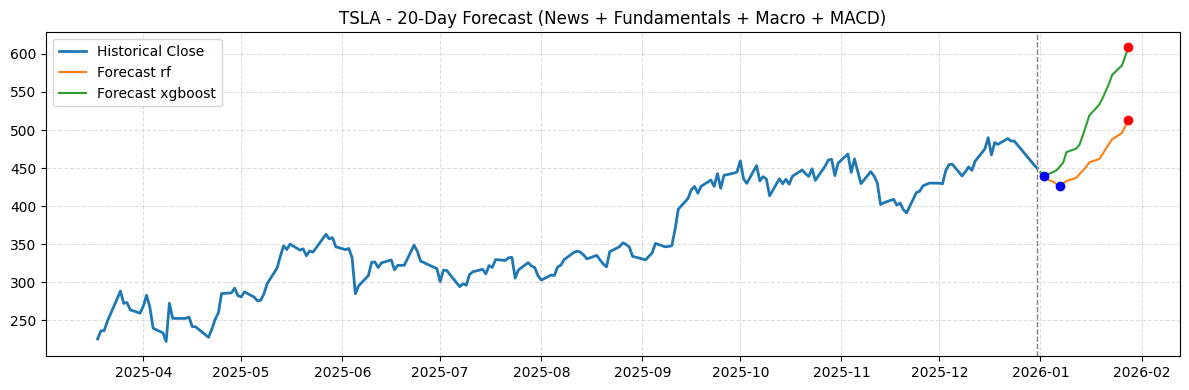

TSLA: 438.07000732421875 USD @ None


In [13]:


'''
models_dict, feat_cols = plot_forecast_compare_full(
    stock,
    period="3mo",
    horizon_days=21,
    history_window=126,
    models=("rf","xgboost"),
    news_days=30,
    page_size=100
)

models_dict, feat_cols = plot_forecast_compare_full(
    stock,
    period="3mo",
    horizon_days=21,
    history_window=126,
    models=("rf","xgboost"),
    news_days=30,
    page_size=100
)

models_dict, feat_cols = plot_forecast_compare_full(
    stock,
    period="6mo",
    horizon_days=21,
    history_window=126,
    models=("rf","xgboost"),
    news_days=30,
    page_size=100
)
'''


stock = "TSLA" 
models_dict, feat_cols = plot_forecast_compare_full(
    stock,
    period="1y",
    horizon_days=20,
    history_window=1000,
    models=("rf","xgboost"),
    news_days=30,
    page_size=100
)

ticker = yf.Ticker(stock)

price = ticker.fast_info.get("lastPrice")
currency = ticker.fast_info.get("currency")
timestamp = ticker.fast_info.get("lastPriceTimestamp")

print(f"{stock}: {price} {currency} @ {timestamp}")



#plot_group_contribution_by_model(models_dict, feat_cols)


In [16]:
def normalize_ohlcv(df):
    """Ensure OHLCV columns are flat for single-ticker yfinance downloads."""
    if hasattr(df.columns, "nlevels") and df.columns.nlevels > 1:
        out = df.copy()
        out.columns = [c[0] for c in out.columns]
        return out
    return df


def _ema(series, span):
    return series.ewm(span=span, adjust=False).mean()


def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1 / period, min_periods=period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1 / period, min_periods=period, adjust=False).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


def add_indicators(df):
    out = df.copy()
    out["MA20"] = out["Close"].rolling(20).mean()
    out["MA50"] = out["Close"].rolling(50).mean()
    out["MA200"] = out["Close"].rolling(200).mean()
    out["MACD"] = _ema(out["Close"], 12) - _ema(out["Close"], 26)
    out["MACD_signal"] = _ema(out["MACD"], 9)
    out["MACD_hist"] = out["MACD"] - out["MACD_signal"]
    out["RSI14"] = compute_rsi(out["Close"], 14)
    out["VolMA20"] = out["Volume"].rolling(20).mean()
    return out


def detect_uptrend_signals(df, lookback=20, swing_window=20):
    """
    Return a dict of uptrend signals using price structure, MAs, momentum, and volume.
    df must have: Open, High, Low, Close, Volume.
    """
    df = normalize_ohlcv(df)

    if len(df) < max(200, lookback * 2, swing_window * 2):
        raise ValueError("Not enough data to evaluate signals")

    dfi = add_indicators(df)
    last = dfi.iloc[-1]
    prev = dfi.iloc[-2]

    recent = dfi.iloc[-swing_window:]
    prior = dfi.iloc[-(swing_window * 2):-swing_window]

    higher_high = recent["High"].max() > prior["High"].max()
    higher_low = recent["Low"].min() > prior["Low"].min()

    resistance = dfi["High"].iloc[-lookback-1:-1].max()
    breakout = last["Close"] > resistance
    retest_ok = dfi["Low"].iloc[-5:].min() >= resistance
    breakout_retest = breakout and retest_ok

    ma_stack = (last["MA20"] > last["MA50"] > last["MA200"])
    ma_price = (last["Close"] > last["MA20"] > last["MA50"] > last["MA200"])
    ma_slope = (last["MA20"] > dfi["MA20"].iloc[-6]) and (last["MA50"] > dfi["MA50"].iloc[-6])

    macd_cross = (last["MACD"] > last["MACD_signal"]) and (prev["MACD"] <= prev["MACD_signal"])
    macd_hist_up = (last["MACD_hist"] > 0) and (last["MACD_hist"] > prev["MACD_hist"])
    rsi_strong = last["RSI14"] > 50

    vol_breakout = (last["Volume"] > last["VolMA20"] * 1.5) and breakout
    vol_pullback = dfi["Volume"].iloc[-5:].mean() < dfi["VolMA20"].iloc[-5:].mean()

    signals = {
        "higher_high": bool(higher_high),
        "higher_low": bool(higher_low),
        "breakout_retest": bool(breakout_retest),
        "ma_stack": bool(ma_stack),
        "ma_price": bool(ma_price),
        "ma_slope": bool(ma_slope),
        "macd_cross": bool(macd_cross),
        "macd_hist_up": bool(macd_hist_up),
        "rsi_strong": bool(rsi_strong),
        "vol_breakout": bool(vol_breakout),
        "vol_pullback": bool(vol_pullback),
    }

    score = sum(signals.values())
    signals["score"] = score
    signals["summary"] = (
        "uptrend" if (signals["higher_high"] and signals["higher_low"] and signals["ma_stack"]) else "not_uptrend"
    )
    return signals


def label_uptrend(df, lookback=20, swing_window=20):
    signals = detect_uptrend_signals(df, lookback=lookback, swing_window=swing_window)
    core = ["higher_high", "higher_low", "ma_stack", "ma_price"]
    momentum = ["macd_hist_up", "rsi_strong"]
    volume = ["vol_breakout", "vol_pullback"]

    core_ok = sum(signals[k] for k in core) >= 3
    momentum_ok = sum(signals[k] for k in momentum) >= 1
    volume_ok = sum(signals[k] for k in volume) >= 1

    if core_ok and momentum_ok and volume_ok:
        return "uptrend_likely", signals
    if core_ok and (momentum_ok or volume_ok):
        return "uptrend_possible", signals
    return "uptrend_weak", signals


In [17]:
import yfinance as yf

ticker = "AAPL"
df = yf.download(ticker, period="1y", interval="1d", auto_adjust=True)
df = df.dropna()

label, signals = label_uptrend(df)

print(ticker, label)
print(signals)


[*********************100%***********************]  1 of 1 completed

AAPL uptrend_weak
{'higher_high': False, 'higher_low': True, 'breakout_retest': False, 'ma_stack': True, 'ma_price': False, 'ma_slope': False, 'macd_cross': False, 'macd_hist_up': False, 'rsi_strong': False, 'vol_breakout': False, 'vol_pullback': True, 'score': 3, 'summary': 'not_uptrend'}


[*********************100%***********************]  1 of 1 completed


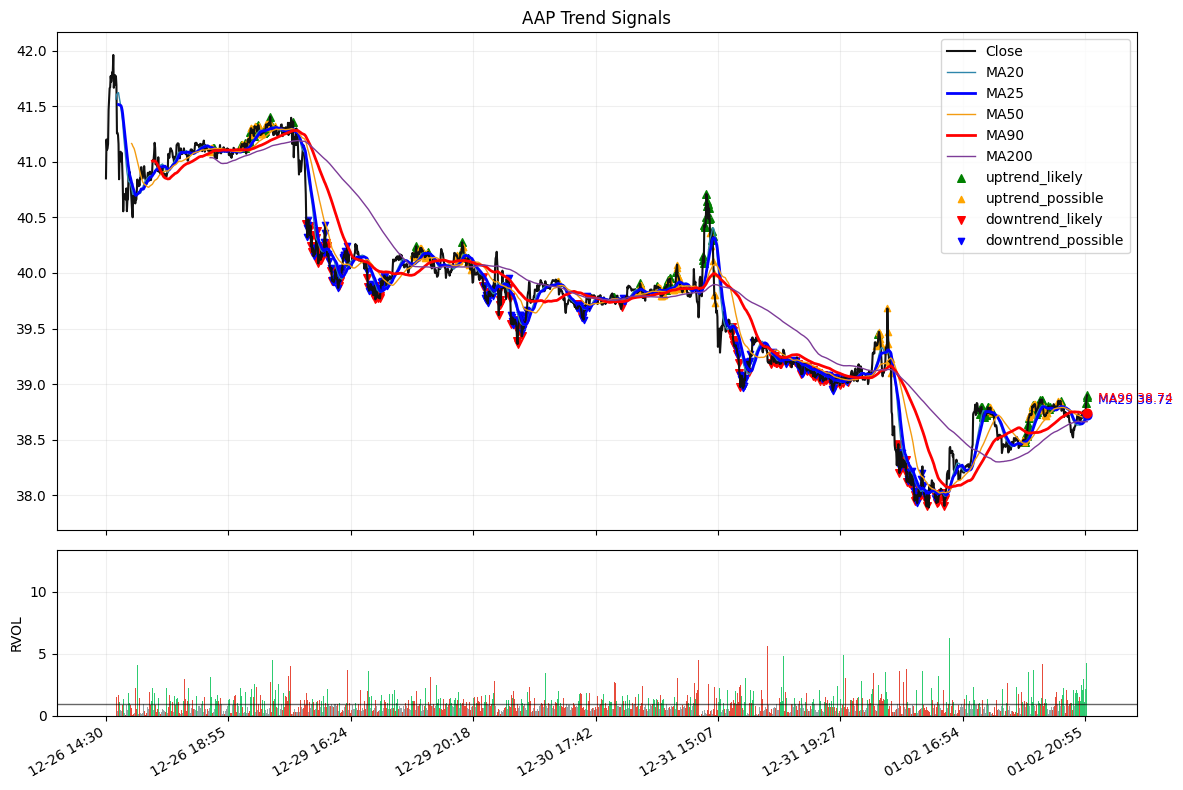

In [138]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def normalize_ohlcv(df):
    if hasattr(df.columns, "nlevels") and df.columns.nlevels > 1:
        out = df.copy()
        out.columns = [c[0] for c in out.columns]
        return out
    return df

def _ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1 / period, min_periods=period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1 / period, min_periods=period, adjust=False).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def add_indicators(df):
    out = df.copy()
    out["MA20"] = out["Close"].rolling(20).mean()
    out["MA25"] = out["Close"].rolling(25).mean()
    out["MA50"] = out["Close"].rolling(50).mean()
    out["MA90"] = out["Close"].rolling(90).mean()
    out["MA200"] = out["Close"].rolling(200).mean()
    out["MACD"] = _ema(out["Close"], 12) - _ema(out["Close"], 26)
    out["MACD_signal"] = _ema(out["MACD"], 9)
    out["MACD_hist"] = out["MACD"] - out["MACD_signal"]
    out["RSI14"] = compute_rsi(out["Close"], 14)
    out["VolMA20"] = out["Volume"].rolling(20).mean()
    return out

def detect_downtrend_signals(df, lookback=20, swing_window=20):
    df = normalize_ohlcv(df)

    if len(df) < max(200, lookback * 2, swing_window * 2):
        raise ValueError("Not enough data to evaluate signals")

    dfi = add_indicators(df)
    last = dfi.iloc[-1]
    prev = dfi.iloc[-2]

    recent = dfi.iloc[-swing_window:]
    prior = dfi.iloc[-(swing_window * 2):-swing_window]

    lower_high = recent["High"].max() < prior["High"].max()
    lower_low = recent["Low"].min() < prior["Low"].min()

    support = dfi["Low"].iloc[-lookback-1:-1].min()
    breakdown = last["Close"] < support
    retest_ok = dfi["High"].iloc[-5:].max() <= support
    breakdown_retest = breakdown and retest_ok

    ma_stack = (last["MA20"] < last["MA50"] < last["MA200"])
    ma_price = (last["Close"] < last["MA20"] < last["MA50"] < last["MA200"])
    ma_slope = (last["MA20"] < dfi["MA20"].iloc[-6]) and (last["MA50"] < dfi["MA50"].iloc[-6])

    macd_cross = (last["MACD"] < last["MACD_signal"]) and (prev["MACD"] >= prev["MACD_signal"])
    macd_hist_down = (last["MACD_hist"] < 0) and (last["MACD_hist"] < prev["MACD_hist"])
    rsi_weak = last["RSI14"] < 50

    vol_breakdown = (last["Volume"] > last["VolMA20"] * 1.5) and breakdown
    vol_bounce = dfi["Volume"].iloc[-5:].mean() < dfi["VolMA20"].iloc[-5:].mean()

    signals = {
        "lower_high": bool(lower_high),
        "lower_low": bool(lower_low),
        "breakdown_retest": bool(breakdown_retest),
        "ma_stack": bool(ma_stack),
        "ma_price": bool(ma_price),
        "ma_slope": bool(ma_slope),
        "macd_cross": bool(macd_cross),
        "macd_hist_down": bool(macd_hist_down),
        "rsi_weak": bool(rsi_weak),
        "vol_breakdown": bool(vol_breakdown),
        "vol_bounce": bool(vol_bounce),
    }

    score = sum(signals.values())
    signals["score"] = score
    signals["summary"] = (
        "downtrend" if (signals["lower_high"] and signals["lower_low"] and signals["ma_stack"]) else "not_downtrend"
    )
    return signals

def label_downtrend(df, lookback=20, swing_window=20):
    signals = detect_downtrend_signals(df, lookback=lookback, swing_window=swing_window)
    core = ["lower_high", "lower_low", "ma_stack", "ma_price"]
    momentum = ["macd_hist_down", "rsi_weak"]
    volume = ["vol_breakdown", "vol_bounce"]

    core_ok = sum(signals[k] for k in core) >= 3
    momentum_ok = sum(signals[k] for k in momentum) >= 1
    volume_ok = sum(signals[k] for k in volume) >= 1

    if core_ok and momentum_ok and volume_ok:
        return "downtrend_likely", signals
    if core_ok and (momentum_ok or volume_ok):
        return "downtrend_possible", signals
    return "downtrend_weak", signals

def scan_trend_labels(df, lookback=20, swing_window=20):
    df = normalize_ohlcv(df).copy()
    up_labels = [None] * len(df)
    down_labels = [None] * len(df)
    min_idx = max(200, lookback * 2, swing_window * 2) - 1

    for i in range(min_idx, len(df)):
        up_labels[i] = label_uptrend(df.iloc[: i + 1], lookback, swing_window)[0]
        down_labels[i] = label_downtrend(df.iloc[: i + 1], lookback, swing_window)[0]

    return up_labels, down_labels

def add_volume_pressure_features(df, vol_ma=20, ret_ma=20):
    df = df.copy()
    df["VolMA"] = df["Volume"].rolling(vol_ma).mean()
    df["RVOL"] = df["Volume"] / df["VolMA"]

    df["Ret1"] = df["Close"].pct_change()
    df["AbsRet1"] = df["Ret1"].abs()

    rng = (df["High"] - df["Low"]).replace(0, np.nan)
    df["CloseStrength"] = (df["Close"] - df["Low"]) / rng

    df["MA20"] = df["Close"].rolling(20).mean()
    df["MA50"] = df["Close"].rolling(50).mean()
    df["PriorHigh20"] = df["High"].shift(1).rolling(20).max()
    return df


def detect_institutional_buying_ohlcv(df, lookback=20):
    df = add_volume_pressure_features(df, vol_ma=20)
    if len(df) < 60:
        raise ValueError("Need at least ~60 rows for MA/level context")

    last = df.iloc[-1]
    recent = df.iloc[-5:]

    rvol15 = last["RVOL"] >= 1.5
    rvol20 = last["RVOL"] >= 2.0

    strong_close = (last["CloseStrength"] >= 0.7)
    up_day = (last["Ret1"] > 0.01)
    up_and_vol = up_day and (last["Volume"] > last["VolMA"])

    cont = sum((recent["Ret1"] > 0) & (recent["Volume"] > recent["VolMA"])) >= 2

    breakout = pd.notna(last["PriorHigh20"]) and (last["Close"] > last["PriorHigh20"])
    above_ma50 = pd.notna(last["MA50"]) and (last["Close"] > last["MA50"])

    score = 0
    score += 1 if rvol15 else 0
    score += 1 if rvol20 else 0
    score += 1 if strong_close else 0
    score += 1 if up_and_vol else 0
    score += 1 if cont else 0
    score += 1 if (breakout or above_ma50) else 0

    label = "suspected_institutional_buying" if score >= 4 else "no_clear_signal"

    return {
        "label": label,
        "score": int(score),
        "RVOL": float(last["RVOL"]) if pd.notna(last["RVOL"]) else None,
        "CloseStrength": float(last["CloseStrength"]) if pd.notna(last["CloseStrength"]) else None,
        "breakout_20d": bool(breakout),
        "above_ma50": bool(above_ma50),
        "continuity_5d": bool(cont),
    }



def plot_trend_signals(ticker, period="1y", interval="1d"):
    df = yf.download(ticker, period=period, interval=interval, auto_adjust=True).dropna()
    df = normalize_ohlcv(df)

    # indicators + RVOL features
    dfi = add_indicators(df)
    dfi = add_volume_pressure_features(dfi)

    up_labels, down_labels = scan_trend_labels(dfi)

    # continuous x to remove overnight gaps
    x = np.arange(len(dfi))

    fig, (ax, axr) = plt.subplots(
        2, 1, figsize=(12, 8), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
    )

    # main price plot
    ax.plot(x, dfi["Close"], label="Close", color="#111111", linewidth=1.5)
    ax.plot(x, dfi["MA20"], label="MA20", color="#2E86AB", linewidth=1)
    ax.plot(x, dfi["MA25"], label="MA25", color="blue", linewidth=2)
    ax.plot(x, dfi["MA50"], label="MA50", color="#F39C12", linewidth=1)
    ax.plot(x, dfi["MA90"], label="MA90", color="red", linewidth=2)
    ax.plot(x, dfi["MA200"], label="MA200", color="#7D3C98", linewidth=1)

    # mark last MA25 / MA90 values
    ma25_last = dfi["MA25"].iloc[-1]
    ma90_last = dfi["MA90"].iloc[-1]
    ax.scatter([x[-1]], [ma25_last], color="blue", s=40, zorder=6)
    ax.scatter([x[-1]], [ma90_last], color="red", s=40, zorder=6)
    ax.annotate(f"MA25 {ma25_last:.2f}", (x[-1], ma25_last),
                textcoords="offset points", xytext=(8, 8), fontsize=9, color="blue")
    ax.annotate(f"MA90 {ma90_last:.2f}", (x[-1], ma90_last),
                textcoords="offset points", xytext=(8, 8), fontsize=9, color="red")

    up_likely = [i for i, v in enumerate(up_labels) if v == "uptrend_likely"]
    up_possible = [i for i, v in enumerate(up_labels) if v == "uptrend_possible"]
    down_likely = [i for i, v in enumerate(down_labels) if v == "downtrend_likely"]
    down_possible = [i for i, v in enumerate(down_labels) if v == "downtrend_possible"]

    ax.scatter(x[up_likely], dfi["Close"].iloc[up_likely],
               marker="^", color="green", s=30, label="uptrend_likely")
    ax.scatter(x[up_possible], dfi["Close"].iloc[up_possible],
               marker="^", color="orange", s=20, label="uptrend_possible")
    ax.scatter(x[down_likely], dfi["Close"].iloc[down_likely],
               marker="v", color="red", s=30, label="downtrend_likely")
    ax.scatter(x[down_possible], dfi["Close"].iloc[down_possible],
               marker="v", color="blue", s=20, label="downtrend_possible")

    ax.set_title(f"{ticker} Trend Signals")
    ax.legend()
    ax.grid(alpha=0.2)

    # RVOL bar subplot (green=up & rvol>1, gray=up but rvol<=1, red=down)
    colors = np.where(
        (dfi["Ret1"] >= 0) & (dfi["RVOL"] > 1),
        "#2ecc71",
        np.where(dfi["Ret1"] < 0, "#e74c3c", "#95a5a6")
    )
    axr.bar(x, dfi["RVOL"], color=colors, width=1.0)
    axr.axhline(1.0, color="black", linewidth=1, alpha=0.6)
    axr.set_ylabel("RVOL")
    axr.grid(alpha=0.2)

    # optional: label some time points
    step = max(len(dfi) // 8, 1)
    axr.set_xticks(x[::step])
    axr.set_xticklabels(dfi.index.strftime("%m-%d %H:%M")[::step], rotation=30, ha="right")

    plt.tight_layout()
    plt.show()


# example
plot_trend_signals("AAP", period="5d", interval="1m")


In [20]:
label, signals = label_uptrend(df)
print(label)
print(signals)


uptrend_weak
{'higher_high': False, 'higher_low': True, 'breakout_retest': False, 'ma_stack': True, 'ma_price': False, 'ma_slope': False, 'macd_cross': False, 'macd_hist_up': False, 'rsi_strong': False, 'vol_breakout': False, 'vol_pullback': True, 'score': 3, 'summary': 'not_uptrend'}


In [211]:
import pandas as pd
import yfinance as yf
import logging

# silence yfinance warnings
logging.getLogger("yfinance").setLevel(logging.ERROR)
try:
    yf.utils.get_yf_logger().setLevel(logging.ERROR)
except Exception:
    pass

def _ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

def normalize_ohlcv(df):
    if hasattr(df.columns, "nlevels") and df.columns.nlevels > 1:
        out = df.copy()
        out.columns = [c[0] for c in out.columns]
        return out
    return df

def safe_download(ticker, period, interval):
    try:
        df = yf.download(ticker, period=period, interval=interval,
                         auto_adjust=True, progress=False)
        df = normalize_ohlcv(df).dropna()
        if df.empty:
            return None
        return df
    except Exception:
        return None

def monthly_macd_golden_cross_df(dfm):
    if dfm is None or len(dfm) < 35:
        return False
    macd = _ema(dfm["Close"], 12) - _ema(dfm["Close"], 26)
    signal = _ema(macd, 9)
    return (macd.iloc[-1] > signal.iloc[-1]) and (macd.iloc[-2] <= signal.iloc[-2])

def last10days_jump_count_df(dfd, jump_threshold=0.05):
    if dfd is None or len(dfd) < 12:
        return None
    ret = dfd["Close"].pct_change()
    last10 = ret.iloc[-10:]
    return int((last10 > jump_threshold).sum())

def load_tickers(path):
    s = pd.read_csv(path)["Ticker"]
    return s.dropna().astype(str).str.strip().tolist()

def backtest_rule(df, fast=25, slow=90):
    df = normalize_ohlcv(df).dropna().copy()
    if len(df) < slow + 5:
        return None

    df["MA_FAST"] = df["Close"].rolling(fast).mean()
    df["MA_SLOW"] = df["Close"].rolling(slow).mean()

    above_red = df["MA_FAST"] > df["MA_SLOW"]
    touch_red = df["Close"] <= df["MA_SLOW"]

    in_pos = False
    entry_price = None
    total_return = 0.0

    for i in range(len(df)):
        if (not in_pos) and above_red.iloc[i]:
            entry_price = df["Close"].iloc[i]
            in_pos = True
        elif in_pos and ((not above_red.iloc[i]) or touch_red.iloc[i]):
            exit_price = df["Close"].iloc[i]
            total_return += (exit_price / entry_price) - 1.0
            in_pos = False

    if in_pos:
        exit_price = df["Close"].iloc[-1]
        total_return += (exit_price / entry_price) - 1.0

    return total_return

# load local lists
nasdaq100 = load_tickers("data/nasdaq100.csv")
sp500 = load_tickers("data/sp500.csv")
russell3000 = load_tickers("data/russell3000.csv")

# choose universe: "nasdaq100" / "sp500" / "russell3000" / "all"
universe = "all"
if universe == "nasdaq100":
    tickers = nasdaq100
elif universe == "sp500":
    tickers = sp500
elif universe == "russell3000":
    tickers = russell3000
else:
    tickers = sorted(set(nasdaq100 + sp500 + russell3000))

jump_threshold = 0.06
min_hits = 1
max_hits = 3

results = []
returns = []

for t in tickers:
    dfd = safe_download(t, period="3mo", interval="1d")
    jump_count = last10days_jump_count_df(dfd, jump_threshold=jump_threshold)
    if jump_count is None:
        continue
    if min_hits <= jump_count <= max_hits:
        dfm = safe_download(t, period="5y", interval="1mo")
        if monthly_macd_golden_cross_df(dfm):
            # apply your MA25/MA90 holding rule on last 2y daily data
            df_rule = safe_download(t, period="2y", interval="1d")
            ret = backtest_rule(df_rule, fast=25, slow=90)
            if ret is not None:
                results.append(t)
                returns.append((t, ret))

print("Filtered tickers:", results)
print("Returns:", returns)


$-: possibly delisted; no price data found  (period=3mo) (Yahoo error = "No data found, symbol may be delisted")

1 Failed download:
['-']: possibly delisted; no price data found  (period=3mo) (Yahoo error = "No data found, symbol may be delisted")
$ADRO: possibly delisted; no price data found  (period=3mo) (Yahoo error = "No data found, symbol may be delisted")

1 Failed download:
['ADRO']: possibly delisted; no price data found  (period=3mo) (Yahoo error = "No data found, symbol may be delisted")
$AKE: possibly delisted; no price data found  (period=3mo) (Yahoo error = "No data found, symbol may be delisted")

1 Failed download:
['AKE']: possibly delisted; no price data found  (period=3mo) (Yahoo error = "No data found, symbol may be delisted")
$BFA: possibly delisted; no price data found  (period=3mo) (Yahoo error = "No data found, symbol may be delisted")

1 Failed download:
['BFA']: possibly delisted; no price data found  (period=3mo) (Yahoo error = "No data found, symbol may be d

Filtered tickers: ['BMRN', 'CRNX', 'DYN', 'IOVA', 'JACK', 'UCTT', 'UNF']
Returns: [('BMRN', -0.5902975109136515), ('CRNX', 0.20296331733649065), ('DYN', 0.4595898846482237), ('IOVA', -0.33131010199584376), ('JACK', -0.14522170258847567), ('UCTT', -0.2097915712904076), ('UNF', -0.19226108638883532)]


In [ ]:
import yfinance as yf
import pandas as pd

def normalize_ohlcv(df):
    if hasattr(df.columns, "nlevels") and df.columns.nlevels > 1:
        out = df.copy()
        out.columns = [c[0] for c in out.columns]
        return out
    return df

def ma_cross_return(ticker, period="5d", interval="1m", fast=25, slow=90):
    df = yf.download(ticker, period=period, interval=interval, auto_adjust=True, progress=False)
    df = normalize_ohlcv(df).dropna()
    if df.empty or len(df) < slow + 5:
        return None

    df["MA_FAST"] = df["Close"].rolling(fast).mean()
    df["MA_SLOW"] = df["Close"].rolling(slow).mean()

    cross_up = (df["MA_FAST"] > df["MA_SLOW"]) & (df["MA_FAST"].shift(1) <= df["MA_SLOW"].shift(1))
    cross_dn = (df["MA_FAST"] < df["MA_SLOW"]) & (df["MA_FAST"].shift(1) >= df["MA_SLOW"].shift(1))

    in_pos = False
    entry_price = None
    total_return = 0.0

    for i in range(len(df)):
        if not in_pos and cross_up.iloc[i]:
            entry_price = df["Close"].iloc[i]
            in_pos = True
        elif in_pos and cross_dn.iloc[i]:
            exit_price = df["Close"].iloc[i]
            total_return += (exit_price / entry_price) - 1.0
            in_pos = False

    if in_pos:
        exit_price = df["Close"].iloc[-1]
        total_return += (exit_price / entry_price) - 1.0

    return total_return
ret = ma_cross_return("AAPL", period="5d", interval="1m")
print(ret)


[*********************100%***********************]  1 of 1 completed


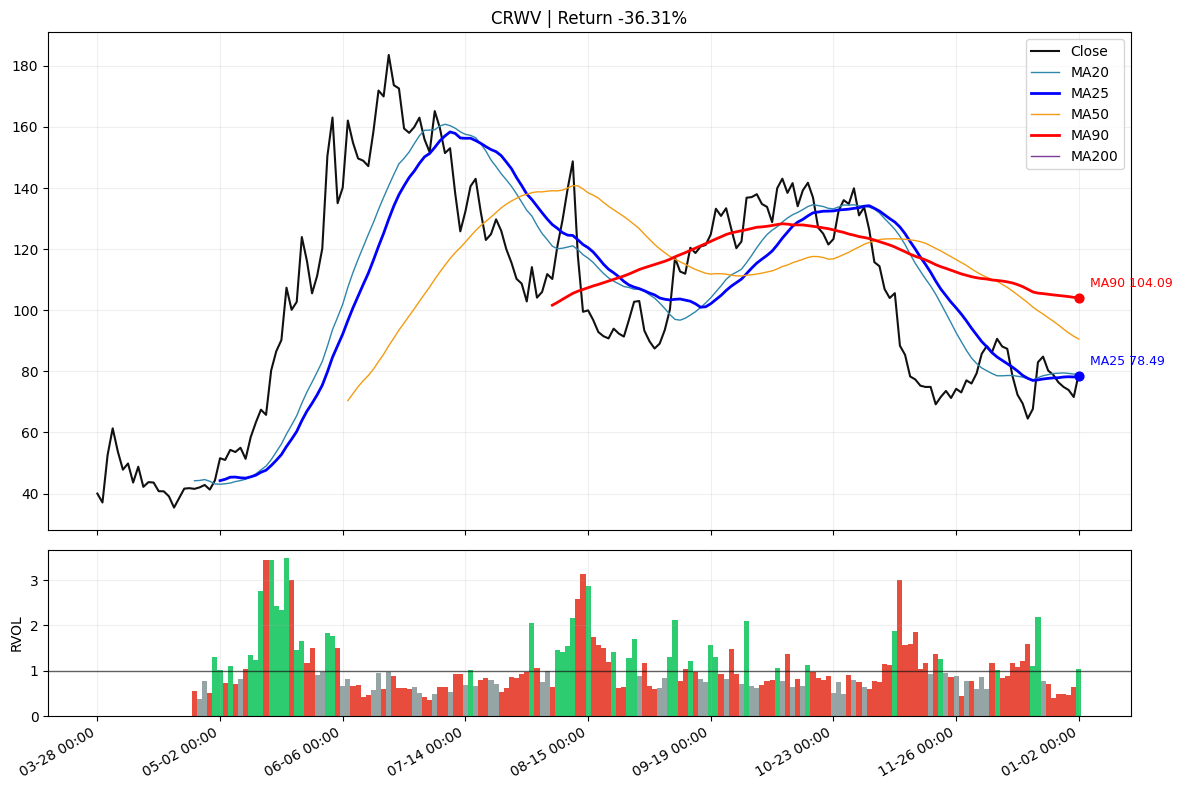

[*********************100%***********************]  1 of 1 completed


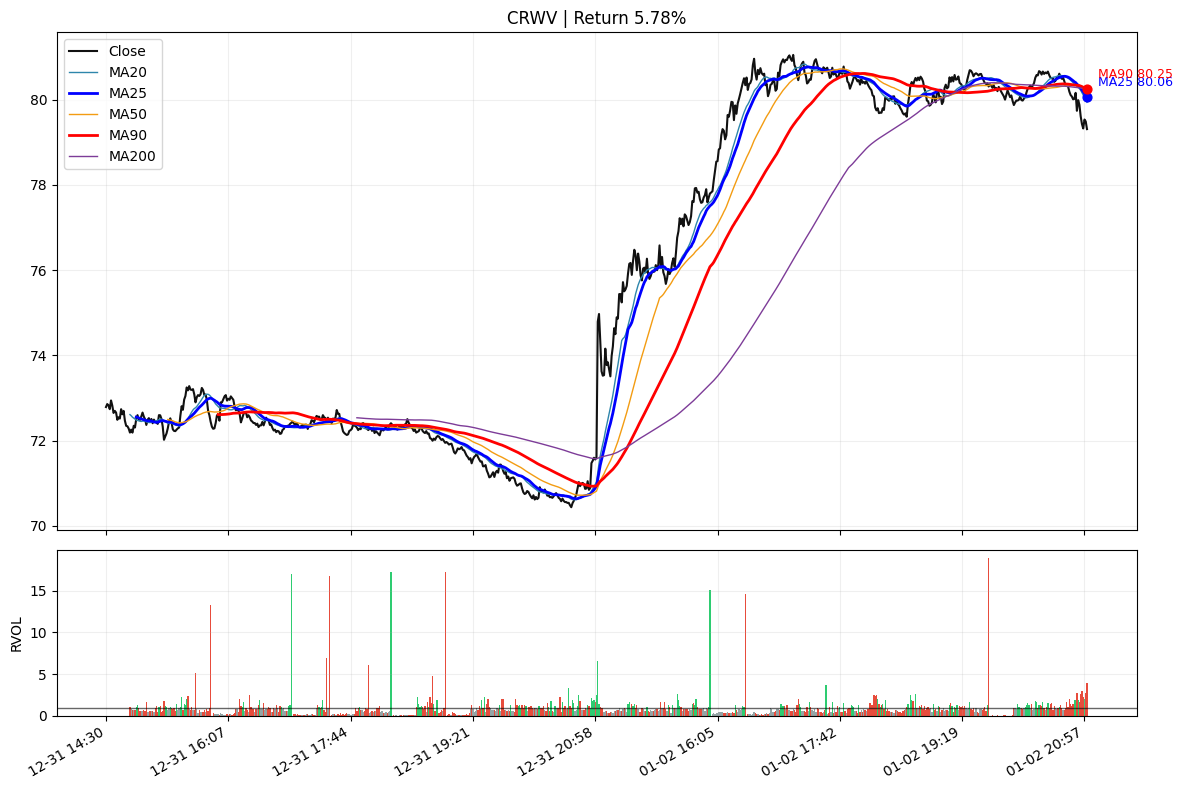

In [415]:
def plot_trend_signals(ticker, period="5d", interval="1m"):
    df = yf.download(ticker, period=period, interval=interval, auto_adjust=True).dropna()
    df = normalize_ohlcv(df)

    dfi = add_indicators(df)
    dfi = add_volume_pressure_features(dfi)

    x = np.arange(len(dfi))

    fig, (ax, axr) = plt.subplots(
        2, 1, figsize=(12, 8), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
    )

    ax.plot(x, dfi["Close"], label="Close", color="#111111", linewidth=1.5)
    ax.plot(x, dfi["MA20"], label="MA20", color="#2E86AB", linewidth=1)
    ax.plot(x, dfi["MA25"], label="MA25", color="blue", linewidth=2)
    ax.plot(x, dfi["MA50"], label="MA50", color="#F39C12", linewidth=1)
    ax.plot(x, dfi["MA90"], label="MA90", color="red", linewidth=2)
    ax.plot(x, dfi["MA200"], label="MA200", color="#7D3C98", linewidth=1)

    # mark last MA25 / MA90 values
    ma25_last = dfi["MA25"].iloc[-1]
    ma90_last = dfi["MA90"].iloc[-1]
    ax.scatter([x[-1]], [ma25_last], color="blue", s=40, zorder=6)
    ax.scatter([x[-1]], [ma90_last], color="red", s=40, zorder=6)
    ax.annotate(f"MA25 {ma25_last:.2f}", (x[-1], ma25_last),
                textcoords="offset points", xytext=(8, 8), fontsize=9, color="blue")
    ax.annotate(f"MA90 {ma90_last:.2f}", (x[-1], ma90_last),
                textcoords="offset points", xytext=(8, 8), fontsize=9, color="red")

    # ===== buy/sell rules =====
    above_red = dfi["MA25"] > dfi["MA90"]
    touch_red = dfi["Close"] <= dfi["MA90"]

    in_pos = False
    entry_price = None
    total_return = 0.0
    hold_mask = []

    for i in range(len(dfi)):
        if (not in_pos) and above_red.iloc[i]:
            entry_price = dfi["Close"].iloc[i]
            in_pos = True
        elif in_pos and ((not above_red.iloc[i]) or touch_red.iloc[i]):
            exit_price = dfi["Close"].iloc[i]
            total_return += (exit_price / entry_price) - 1.0
            in_pos = False
        hold_mask.append(in_pos)

    if in_pos:
        exit_price = dfi["Close"].iloc[-1]
        total_return += (exit_price / entry_price) - 1.0

    # holding segments (purple thick line)
    hold_mask = np.array(hold_mask)
    hold_close = dfi["Close"].where(hold_mask, np.nan)
    #ax.plot(x, hold_close, color="#7b2cbf", linewidth=3.5, label="holding")

    ax.set_title(f"{ticker} | Return {total_return:.2%}")
    ax.legend()
    ax.grid(alpha=0.2)

    # RVOL bar subplot (green=up & rvol>1, gray=up but rvol<=1, red=down)
    colors = np.where(
        (dfi["Ret1"] >= 0) & (dfi["RVOL"] > 1),
        "#2ecc71",
        np.where(dfi["Ret1"] < 0, "#e74c3c", "#95a5a6")
    )
    axr.bar(x, dfi["RVOL"], color=colors, width=1.0)
    axr.axhline(1.0, color="black", linewidth=1, alpha=0.6)
    axr.set_ylabel("RVOL")
    axr.grid(alpha=0.2)

    step = max(len(dfi) // 8, 1)
    axr.set_xticks(x[::step])
    axr.set_xticklabels(dfi.index.strftime("%m-%d %H:%M")[::step], rotation=30, ha="right")

    plt.tight_layout()
    plt.show()

stk = "CRWV"
#stk = by_type_obvious["Industrials / Transport / Logistics"][21]
plot_trend_signals(stk, period="1y", interval="1d")
plot_trend_signals(stk, period="2d", interval="1m")


In [259]:
Ftickers= ['A', 'AAL', 'AAMI', 'AAP', 'AAPL', 'ABBV', 'ABCB', 'ABG', 'ABM', 'ABNB', 'ABSI', 'ABUS', 'ACA', 'ACAD', 'ACCO', 'ACEL', 'ACGL', 'ACHC', 'ACI', 'ACIC', 'ACIW', 'ACLX', 'ACN', 'ACNB', 'ACRE', 'ACT', 'ACTG', 'ACVA', 'ADBE', 'ADC', 'ADCT', 'ADEA', 'ADI', 'ADMA', 'ADNT', 'ADP', 'ADPT', 'ADT', 'ADTN', 'ADUS', 'ADV', 'AEBI', 'AEIS', 'AEO', 'AEVA', 'AFCG', 'AFL', 'AFRM', 'AGCO', 'AGIO', 'AGL', 'AGM', 'AGNC', 'AGO', 'AGX', 'AGYS', 'AHCO', 'AI', 'AIG', 'AIN', 'AIP', 'AIT', 'AIV', 'AIZ', 'AKAM', 'AKBA', 'AKR', 'AL', 'ALAB', 'ALB', 'ALDX', 'ALEC', 'ALEX', 'ALGN', 'ALH', 'ALIT', 'ALK', 'ALKS', 'ALKT', 'ALL', 'ALLE', 'ALLO', 'ALLY', 'ALMS', 'ALNT', 'ALNY', 'ALRM', 'ALRS', 'ALSN', 'ALT', 'AMAL', 'AMBP', 'AMC', 'AMCX', 'AMD', 'AME', 'AMG', 'AMGN', 'AMLX', 'AMN', 'AMP', 'AMPH', 'AMPL', 'AMR', 'AMRX', 'AMSF', 'AMT', 'AMTB', 'AMWD', 'AMZN', 'AN', 'ANET', 'ANGI', 'ANGO', 'ANIK', 'ANIP', 'ANNX', 'AON', 'AORT', 'AOS', 'AOSL', 'APAM', 'APEI', 'APGE', 'APLS', 'APO', 'APOG', 'APP', 'APPF', 'APPN', 'APPS', 'ARAY', 'ARCB', 'ARCT', 'ARE', 'ARES', 'ARHS', 'ARI', 'ARKO', 'ARLO', 'ARM', 'ARMK', 'AROW', 'ARR', 'ARRY', 'ARVN', 'ARWR', 'AS', 'ASAN', 'ASB', 'ASC', 'ASGN', 'ASH', 'ASIX', 'ASML', 'ASPI', 'ASPN', 'ASTE', 'ASTH', 'ASTS', 'ASUR', 'ATEC', 'ATEN', 'ATEX', 'ATGE', 'ATI', 'ATKR', 'ATMU', 'ATNI', 'ATR', 'ATRC', 'ATYR', 'AU', 'AUB', 'AUPH', 'AUR', 'AURA', 'AVAH', 'AVAV', 'AVBP', 'AVD', 'AVDL', 'AVGO', 'AVIR', 'AVNT', 'AVNW', 'AVO', 'AVT', 'AVTR', 'AVXL', 'AVY', 'AWK', 'AWR', 'AX', 'AXGN', 'AXL', 'AXON', 'AXP', 'AXS', 'AYI', 'AZN', 'AZO', 'AZTA', 'AZZ', 'BAC', 'BAH', 'BAM', 'BANC', 'BAND', 'BANF', 'BANR', 'BATRK', 'BBBY', 'BBIO', 'BBNX', 'BBSI', 'BBT', 'BBUC', 'BBW', 'BC', 'BCAL', 'BCAX', 'BCBP', 'BCC', 'BCO', 'BCPC', 'BCRX', 'BDC', 'BDN', 'BDX', 'BEAM', 'BELFB', 'BEN', 'BETR', 'BF-B', 'BFAM', 'BFC', 'BFH', 'BFS', 'BFST', 'BGC', 'BGS', 'BHB', 'BHE', 'BHF', 'BHVN', 'BILL', 'BIO', 'BIPC', 'BIRK', 'BJ', 'BJRI', 'BK', 'BKD', 'BKE', 'BKNG', 'BKU', 'BKV', 'BL', 'BLBD', 'BLD', 'BLDR', 'BLFS', 'BLFY', 'BLK', 'BLKB', 'BLMN', 'BLND', 'BLSH', 'BLX', 'BMBL', 'BMI', 'BMRC', 'BMRN', 'BNL', 'BOH', 'BOKF', 'BOOM', 'BORR', 'BOW', 'BOX', 'BPOP', 'BR', 'BRBR', 'BRCC', 'BRK-B', 'BRKR', 'BRO', 'BROS', 'BRSL', 'BRX', 'BRZE', 'BSRR', 'BSX', 'BTBT', 'BTDR', 'BTSG', 'BTU', 'BUR', 'BUSE', 'BV', 'BWB', 'BWIN', 'BWXT', 'BXC', 'BXMT', 'BXP', 'BY', 'BYND', 'BZH', 'C', 'CAC', 'CACC', 'CACI', 'CADE', 'CAH', 'CAI', 'CAL', 'CALM', 'CALX', 'CAPR', 'CAR', 'CARE', 'CARG', 'CARR', 'CARS', 'CART', 'CASH', 'CASS', 'CASY', 'CATX', 'CATY', 'CAVA', 'CB', 'CBAN', 'CBL', 'CBOE', 'CBRE', 'CBRL', 'CBSH', 'CBT', 'CBU', 'CCB', 'CCBG', 'CCC', 'CCI', 'CCK', 'CCNE', 'CCOI', 'CCRN', 'CCS', 'CCSI', 'CDE', 'CDNA', 'CDNS', 'CDP', 'CDRE', 'CDTX', 'CDW', 'CDXS', 'CECO', 'CELC', 'CENT', 'CENTA', 'CERS', 'CERT', 'CEVA', 'CFFN', 'CFG', 'CFLT', 'CFR', 'CG', 'CGEM', 'CGNX', 'CHCO', 'CHD', 'CHDN', 'CHE', 'CHEF', 'CHRW', 'CHTR', 'CHWY', 'CIFR', 'CIM', 'CINF', 'CIO', 'CIVB', 'CL', 'CLBK', 'CLF', 'CLFD', 'CLMB', 'CLMT', 'CLNE', 'CLOV', 'CLPT', 'CLVT', 'CLW', 'CMC', 'CMCL', 'CMCO', 'CMCSA', 'CMDB', 'CME', 'CMG', 'CMI', 'CMPO', 'CMPR', 'CMPX', 'CMRC', 'CMT', 'CMTG', 'CNDT', 'CNH', 'CNMD', 'CNNE', 'CNO', 'CNOB', 'CNR', 'CNS', 'CNXC', 'CNXN', 'CODI', 'COF', 'COGT', 'COHR', 'COKE', 'COLB', 'COLL', 'COMM', 'CON', 'COO', 'COR', 'COST', 'COTY', 'COUR', 'CPAY', 'CPB', 'CPF', 'CPK', 'CPRI', 'CPRX', 'CPS', 'CR', 'CRAI', 'CRCL', 'CRCT', 'CRDO', 'CRGY', 'CRH', 'CRL', 'CRM', 'CRMD', 'CRMT', 'CRNX', 'CROX', 'CRSP', 'CRSR', 'CRUS', 'CRVL', 'CRWD', 'CSCO', 'CSGP', 'CSGS', 'CSL', 'CSTL', 'CSTM', 'CSV', 'CSW', 'CSX', 'CTAS', 'CTBI', 'CTKB', 'CTLP', 'CTOS', 'CTRE', 'CTRI', 'CTS', 'CTSH', 'CUBE', 'CUBI', 'CURB', 'CUZ', 'CVBF', 'CVCO', 'CVGW', 'CVI', 'CVLG', 'CVLT', 'CVNA', 'CVRX', 'CW', 'CWAN', 'CWBC', 'CWCO', 'CWH', 'CWK', 'CWST', 'CWT', 'CXM', 'CXT', 'CXW', 'CYH', 'CYRX', 'CYTK', 'CZNC', 'CZR', 'DAL', 'DASH', 'DAVE', 'DAWN', 'DAY', 'DBD', 'DBI', 'DC', 'DCGO', 'DCI', 'DCO', 'DCOM', 'DD', 'DDD', 'DDOG', 'DEA', 'DEI', 'DELL', 'DENN', 'DFH', 'DFIN', 'DGICA', 'DGII', 'DGX', 'DHI', 'DHIL', 'DHR', 'DHT', 'DINO', 'DIOD', 'DIS', 'DJT', 'DK', 'DKNG', 'DKS', 'DLB', 'DLX', 'DMRC', 'DNLI', 'DNOW', 'DNTH', 'DNUT', 'DOCS', 'DOCU', 'DOLE', 'DOMO', 'DORM', 'DOV', 'DOX', 'DPZ', 'DRH', 'DRS', 'DRUG', 'DRVN', 'DSGN', 'DSP', 'DT', 'DUOL', 'DV', 'DVA', 'DVAX', 'DXC', 'DXCM', 'DYN', 'EB', 'EBC', 'EBF', 'EBS', 'ECG', 'ECL', 'ECVT', 'EDIT', 'EE', 'EEFT', 'EFSC', 'EFX', 'EG', 'EGBN', 'EGHT', 'EGP', 'EGY', 'EHAB', 'EIG', 'EL', 'ELF', 'ELS', 'ELVN', 'EMBC', 'EMN', 'EMR', 'ENOV', 'ENR', 'ENS', 'ENSG', 'ENTA', 'ENVX', 'EOLS', 'EPAM', 'EPC', 'EPM', 'EQBK', 'EQH', 'EQIX', 'EQT', 'ERAS', 'ERIE', 'ERII', 'ESAB', 'ESE', 'ESI', 'ESNT', 'ESPR', 'ESQ', 'ESTC', 'ETD', 'ETN', 'EVER', 'EVGO', 'EVH', 'EVR', 'EVTC', 'EWBC', 'EWCZ', 'EWTX', 'EXAS', 'EXEL', 'EXLS', 'EXP', 'EXPD', 'EXPE', 'EXPI', 'EXPO', 'EXR', 'EXTR', 'EYE', 'F', 'FA', 'FAF', 'FATE', 'FBIZ', 'FBK', 'FBNC', 'FBP', 'FC', 'FCBC', 'FCF', 'FCN', 'FCNCA', 'FCPT', 'FCX', 'FDMT', 'FDP', 'FDS', 'FDX', 'FER', 'FERG', 'FFBC', 'FFIC', 'FFIV', 'FFWM', 'FG', 'FHB', 'FHN', 'FIBK', 'FICO', 'FIGR', 'FIGS', 'FIHL', 'FISI', 'FISV', 'FITB', 'FIVE', 'FIVN', 'FIZZ', 'FLEX', 'FLG', 'FLGT', 'FLNG', 'FLR', 'FLS', 'FLUT', 'FLWS', 'FLYW', 'FMAO', 'FMNB', 'FN', 'FNB', 'FND', 'FNF', 'FNKO', 'FNLC', 'FOLD', 'FOR', 'FOUR', 'FOX', 'FOXA', 'FOXF', 'FPI', 'FRBA', 'FRGE', 'FRHC', 'FRME', 'FRPH', 'FRPT', 'FRSH', 'FRT', 'FSBC', 'FSLR', 'FSLY', 'FSS', 'FSUN', 'FTDR', 'FTNT', 'FTRE', 'FTV', 'FUBO', 'FUL', 'FULC', 'FULT', 'FWONA', 'FWONK', 'FWRD', 'FWRG', 'FYBR', 'G', 'GABC', 'GAP', 'GATX', 'GBCI', 'GBTG', 'GBX', 'GCMG', 'GCT', 'GDDY', 'GDOT', 'GDYN', 'GEF', 'GEHC', 'GEN', 'GENI', 'GEO', 'GERN', 'GETY', 'GEV', 'GFF', 'GGG', 'GH', 'GHC', 'GHM', 'GIC', 'GIII', 'GILD', 'GIS', 'GKOS', 'GL', 'GLDD', 'GLIBA', 'GLIBK', 'GLOB', 'GLRE', 'GLUE', 'GLW', 'GM', 'GMED', 'GMRE', 'GNE', 'GNK', 'GNW', 'GOGO', 'GOLD', 'GOLF', 'GOOG', 'GOOGL', 'GOSS', 'GPC', 'GPI', 'GPK', 'GPN', 'GRAL', 'GRBK', 'GRDN', 'GRMN', 'GRND', 'GRNT', 'GRPN', 'GSBC', 'GSHD', 'GTLB', 'GTLS', 'GTN', 'GTX', 'GWRE', 'GWW', 'HAE', 'HAFC', 'HAIN', 'HASI', 'HBNC', 'HBT', 'HCA', 'HCAT', 'HCC', 'HCI', 'HCKT', 'HCSG', 'HDSN', 'HEI', 'HELE', 'HFWA', 'HG', 'HGV', 'HI', 'HIFS', 'HIG', 'HII', 'HIMS', 'HIPO', 'HL', 'HLF', 'HLI', 'HLIO', 'HLIT', 'HLMN', 'HLNE', 'HMN', 'HNI', 'HNRG', 'HNST', 'HOG', 'HOLX', 'HOMB', 'HON', 'HOOD', 'HOPE', 'HOV', 'HPE', 'HPQ', 'HQY', 'HR', 'HRB', 'HRI', 'HRL', 'HRMY', 'HROW', 'HRTG', 'HRTX', 'HSIC', 'HSTM', 'HSY', 'HTB', 'HTBK', 'HTFL', 'HTH', 'HTLD', 'HTO', 'HTZ', 'HUBB', 'HUBG', 'HUBS', 'HUMA', 'HURN', 'HVT', 'HWC', 'HWKN', 'HWM', 'HY', 'HYLN', 'HZO', 'IART', 'IBCP', 'IBKR', 'IBOC', 'IBP', 'IBRX', 'IBTA', 'ICE', 'ICUI', 'IDA', 'IDCC', 'IDR', 'IDT', 'IDXX', 'IDYA', 'IESC', 'IEX', 'IFF', 'IHRT', 'IIIV', 'IIPR', 'ILPT', 'IMAX', 'IMMR', 'IMNM', 'IMVT', 'IMXI', 'INBK', 'INBX', 'INDB', 'INDI', 'INDV', 'INGM', 'INGN', 'INGR', 'INN', 'INOD', 'INR', 'INSE', 'INSM', 'INSP', 'INSW', 'INTA', 'INTU', 'INVA', 'IONQ', 'IONS', 'IOSP', 'IOT', 'IOVA', 'IP', 'IPAR', 'IPGP', 'IPI', 'IQV', 'IR', 'IRDM', 'IRM', 'IRMD', 'IRON', 'IRTC', 'ISRG', 'IT', 'ITGR', 'ITIC', 'ITRI', 'ITT', 'ITW', 'IVT', 'IVZ', 'J', 'JACK', 'JAKK', 'JAMF', 'JANX', 'JBGS', 'JBHT', 'JBI', 'JBIO', 'JBL', 'JBLU', 'JBSS', 'JBTM', 'JEF', 'JELD', 'JHG', 'JHX', 'JJSF', 'JKHY', 'JLL', 'JPM', 'JRVR', 'JXN', 'KAI', 'KBH', 'KBR', 'KD', 'KDP', 'KE', 'KELYA', 'KEX', 'KEY', 'KEYS', 'KFRC', 'KFY', 'KGS', 'KKR', 'KLAC', 'KLC', 'KLIC', 'KMB', 'KMPR', 'KMTS', 'KMX', 'KNF', 'KNSL', 'KNX', 'KOD', 'KODK', 'KOP', 'KOS', 'KR', 'KRC', 'KRG', 'KRMN', 'KRNY', 'KROS', 'KRRO', 'KRYS', 'KSS', 'KTB', 'KTOS', 'KURA', 'KVUE', 'KW', 'KWR', 'KYMR', 'L', 'LAB', 'LAD', 'LAMR', 'LAND', 'LASR', 'LAUR', 'LAW', 'LAZ', 'LBRDA', 'LBRDK', 'LBRT', 'LBTYA', 'LBTYK', 'LC', 'LCID', 'LCII', 'LECO', 'LEG', 'LEN', 'LENZ', 'LFST', 'LFUS', 'LGIH', 'LGN', 'LGND', 'LH', 'LIF', 'LII', 'LILAK', 'LIND', 'LINE', 'LION', 'LITE', 'LIVN', 'LKFN', 'LKQ', 'LLY', 'LLYVK', 'LMAT', 'LMNR', 'LNC', 'LNTH', 'LOAR', 'LOB', 'LOCO', 'LOPE', 'LOVE', 'LPG', 'LPLA', 'LPRO', 'LPX', 'LQDA', 'LRMR', 'LRN', 'LSCC', 'LSTR', 'LTH', 'LULU', 'LUMN', 'LUV', 'LVS', 'LW', 'LXEO', 'LXFR', 'LXP', 'LYB', 'LYFT', 'LYV', 'LZ', 'LZB', 'M', 'MA', 'MAC', 'MAMA', 'MANH', 'MAR', 'MASI', 'MASS', 'MATV', 'MATW', 'MATX', 'MAX', 'MAZE', 'MBC', 'MBI', 'MBIN', 'MBWM', 'MBX', 'MC', 'MCBS', 'MCD', 'MCFT', 'MCHB', 'MCHP', 'MCK', 'MCO', 'MCRI', 'MCS', 'MCW', 'MCY', 'MD', 'MDB', 'MDGL', 'MDXG', 'MED', 'MEDP', 'MEG', 'MEI', 'MELI', 'META', 'METC', 'MGEE', 'MGM', 'MGNI', 'MGPI', 'MGRC', 'MGTX', 'MHK', 'MHO', 'MIAX', 'MIDD', 'MIR', 'MIRM', 'MITK', 'MKC', 'MKL', 'MKSI', 'MKTX', 'MLAB', 'MLI', 'MLKN', 'MLM', 'MLR', 'MLYS', 'MMC', 'MMI', 'MMM', 'MMS', 'MNKD', 'MNMD', 'MNRO', 'MNST', 'MNTK', 'MOD', 'MODG', 'MOFG', 'MORN', 'MPB', 'MPC', 'MPW', 'MPWR', 'MQ', 'MRCY', 'MRP', 'MRTN', 'MRVL', 'MRX', 'MS', 'MSA', 'MSBI', 'MSCI', 'MSEX', 'MSFT', 'MSGE', 'MSGS', 'MSI', 'MSM', 'MTB', 'MTCH', 'MTD', 'MTG', 'MTH', 'MTRN', 'MTSI', 'MTW', 'MTX', 'MTZ', 'MUSA', 'MVBF', 'MVIS', 'MVST', 'MWA', 'MXCT', 'MYE', 'MYGN', 'MYPS', 'MZTI', 'NABL', 'NAGE', 'NAT', 'NATL', 'NAVI', 'NBBK', 'NBHC', 'NBIX', 'NBN', 'NBTB', 'NCLH', 'NCMI', 'NCNO', 'NDAQ', 'NDSN', 'NECB', 'NEM', 'NEO', 'NEOG', 'NET', 'NEU', 'NEWT', 'NEXT', 'NFBK', 'NFE', 'NFLX', 'NG', 'NGVC', 'NGVT', 'NHC', 'NHI', 'NIC', 'NIQ', 'NJR', 'NKTX', 'NLOP', 'NMIH', 'NMRK', 'NN', 'NNI', 'NNOX', 'NOVT', 'NOW', 'NPCE', 'NPK', 'NPKI', 'NPO', 'NRC', 'NRDS', 'NRG', 'NRIM', 'NRIX', 'NSC', 'NSIT', 'NSP', 'NSSC', 'NTAP', 'NTB', 'NTCT', 'NTGR', 'NTLA', 'NTRA', 'NTST', 'NUS', 'NUTX', 'NUVB', 'NUVL', 'NVDA', 'NVR', 'NVRI', 'NVST', 'NVT', 'NWBI', 'NWE', 'NWL', 'NWPX', 'NWS', 'NWSA', 'NX', 'NXDR', 'NXDT', 'NXPI', 'NXT', 'NYT', 'OABI', 'OBK', 'OBT', 'OC', 'OCFC', 'OCUL', 'ODC', 'OEC', 'OFG', 'OFLX', 'OGS', 'OI', 'OII', 'OKLO', 'OKTA', 'OLED', 'OLLI', 'OLMA', 'OLN', 'OLP', 'OLPX', 'OMI', 'ONB', 'ONEW', 'ONIT', 'ONON', 'ONTF', 'OOMA', 'OPK', 'OPLN', 'OPTU', 'ORA', 'ORCL', 'ORGO', 'ORI', 'ORIC', 'ORKA', 'ORLY', 'ORRF', 'OSBC', 'OSG', 'OSIS', 'OSPN', 'OSUR', 'OSW', 'OTTR', 'OWL', 'OXM', 'PACB', 'PACK', 'PACS', 'PAG', 'PAGS', 'PAHC', 'PANL', 'PANW', 'PAR', 'PARR', 'PATH', 'PAX', 'PAYC', 'PAYO', 'PAYS', 'PAYX', 'PB', 'PBF', 'PBH', 'PBI', 'PCAR', 'PCH', 'PCOR', 'PCRX', 'PCT', 'PCTY', 'PCVX', 'PD', 'PDFS', 'PDM', 'PEGA', 'PEN', 'PENG', 'PEP', 'PFGC', 'PFIS', 'PFSI', 'PG', 'PGC', 'PGEN', 'PGNY', 'PGR', 'PH', 'PHAT', 'PHM', 'PHR', 'PI', 'PII', 'PIPR', 'PJT', 'PKE', 'PKG', 'PKST', 'PLAY', 'PLMR', 'PLNT', 'PLOW', 'PLSE', 'PLTK', 'PLTR', 'PLUS', 'PLYM', 'PM', 'PMT', 'PNC', 'PNFP', 'PNR', 'PNTG', 'PODD', 'POOL', 'POST', 'POWW', 'PPC', 'PPG', 'PPTA', 'PRA', 'PRAA', 'PRAX', 'PRCH', 'PRCT', 'PRDO', 'PRG', 'PRGS', 'PRI', 'PRIM', 'PRKS', 'PRLB', 'PRM', 'PRSU', 'PRTA', 'PRTH', 'PRVA', 'PSA', 'PSFE', 'PSKY', 'PSMT', 'PSN', 'PSTG', 'PSTL', 'PSX', 'PTC', 'PTCT', 'PTGX', 'PTLO', 'PTON', 'PUBM', 'PUMP', 'PVH', 'PVLA', 'PWP', 'PWR', 'PYPL', 'Q', 'QCOM', 'QCRH', 'QGEN', 'QLYS', 'QNST', 'QRVO', 'QSI', 'QSR', 'QTRX', 'QTWO', 'QXO', 'R', 'RAL', 'RAMP', 'RAPP', 'RARE', 'RBA', 'RBB', 'RBBN', 'RBC', 'RBCAA', 'RBRK', 'RC', 'RCAT', 'RCEL', 'RCL', 'RCUS', 'RDN', 'RDNT', 'RDVT', 'REAL', 'REFI', 'REG', 'REGN', 'RELY', 'REPL', 'REVG', 'REX', 'REYN', 'REZI', 'RGA', 'RGEN', 'RGLD', 'RGNX', 'RGP', 'RGR', 'RGTI', 'RH', 'RHLD', 'RHP', 'RICK', 'RIG', 'RIGL', 'RITM', 'RIVN', 'RKLB', 'RL', 'RLAY', 'RLI', 'RLJ', 'RM', 'RMAX', 'RMD', 'RMNI', 'RMR', 'RNA', 'RNG', 'RNST', 'ROAD', 'ROCK', 'ROG', 'ROIV', 'ROK', 'ROKU', 'ROL', 'ROOT', 'ROP', 'ROST', 'RPAY', 'RPD', 'RPM', 'RPRX', 'RRBI', 'RS', 'RTX', 'RUM', 'RUN', 'RUSHA', 'RVLV', 'RVMD', 'RVTY', 'RWT', 'RXRX', 'RXST', 'RYAN', 'RYI', 'RYTM', 'S', 'SABR', 'SAFE', 'SAFT', 'SAH', 'SAIA', 'SAIC', 'SAIL', 'SAM', 'SANA', 'SANM', 'SARO', 'SB', 'SBAC', 'SBCF', 'SBGI', 'SBH', 'SBRA', 'SBSI', 'SCHL', 'SCI', 'SCL', 'SCSC', 'SCVL', 'SDGR', 'SEAT', 'SEB', 'SEE', 'SEG', 'SEIC', 'SEM', 'SEMR', 'SENEA', 'SEPN', 'SEZL', 'SFBS', 'SFD', 'SFIX', 'SFL', 'SFM', 'SFNC', 'SFST', 'SGHC', 'SGI', 'SGRY', 'SHAK', 'SHBI', 'SHC', 'SHLS', 'SHOO', 'SHOP', 'SHW', 'SIBN', 'SIG', 'SIGA', 'SIGI', 'SILA', 'SION', 'SITE', 'SITM', 'SJM', 'SKIN', 'SKT', 'SKWD', 'SKY', 'SKYW', 'SLAB', 'SLDE', 'SLG', 'SLM', 'SLP', 'SLQT', 'SLVM', 'SMA', 'SMBC', 'SMBK', 'SMCI', 'SMG', 'SMMT', 'SMP', 'SMPL', 'SMTC', 'SN', 'SNA', 'SNCY', 'SNDR', 'SNDX', 'SNOW', 'SNPS', 'SNV', 'SNX', 'SOLS', 'SOLV', 'SONO', 'SOUN', 'SPB', 'SPFI', 'SPG', 'SPGI', 'SPHR', 'SPNT', 'SPOK', 'SPOT', 'SPSC', 'SPT', 'SPXC', 'SR', 'SRCE', 'SRPT', 'SRRK', 'SRTA', 'SSB', 'SSD', 'SSNC', 'SSP', 'SSRM', 'SSTI', 'STAA', 'STBA', 'STC', 'STE', 'STEL', 'STEP', 'STGW', 'STKL', 'STNG', 'STOK', 'STRA', 'STRL', 'STRZ', 'STT', 'STWD', 'SUI', 'SUNS', 'SUPN', 'SVC', 'SVRA', 'SVV', 'SWBI', 'SWKS', 'SWX', 'SXT', 'SYBT', 'SYF', 'SYK', 'SYNA', 'SYRE', 'SYY', 'T', 'TALK', 'TARS', 'TBBK', 'TBCH', 'TBI', 'TCBI', 'TCBK', 'TCBX', 'TCMD', 'TCX', 'TDAY', 'TDC', 'TDG', 'TDOC', 'TDS', 'TDW', 'TDY', 'TEAD', 'TEAM', 'TECH', 'TEL', 'TEM', 'TENB', 'TER', 'TERN', 'TEX', 'TFC', 'TFIN', 'TFX', 'TGLS', 'TGNA', 'TGT', 'TGTX', 'TH', 'THC', 'THFF', 'THG', 'THO', 'THR', 'THRM', 'THRY', 'THS', 'TIC', 'TIPT', 'TITN', 'TK', 'TKO', 'TKR', 'TLN', 'TMCI', 'TMDX', 'TMHC', 'TMP', 'TNC', 'TNDM', 'TNET', 'TNK', 'TOL', 'TOST', 'TOWN', 'TPB', 'TPC', 'TPG', 'TPH', 'TPR', 'TR', 'TRC', 'TREE', 'TREX', 'TRI', 'TRMB', 'TRNO', 'TRNS', 'TROX', 'TRS', 'TRST', 'TRU', 'TRUE', 'TRUP', 'TRV', 'TRVI', 'TSHA', 'TSLA', 'TT', 'TTD', 'TTEC', 'TTEK', 'TTGT', 'TTMI', 'TTWO', 'TW', 'TWI', 'TWLO', 'TWO', 'TWST', 'TXG', 'TXN', 'TXNM', 'TXT', 'TYL', 'TYRA', 'U', 'UAL', 'UCB', 'UCTT', 'UDMY', 'UE', 'UEC', 'UFCS', 'UFPT', 'UGI', 'UHAL', 'UHS', 'UHT', 'UI', 'UIS', 'ULCC', 'ULTA', 'UMBF', 'UMH', 'UNF', 'UNFI', 'UNIT', 'UNM', 'UNP', 'UNTY', 'UPB', 'UPBD', 'UPST', 'UPWK', 'URBN', 'URGN', 'USB', 'USD', 'USFD', 'USLM', 'USPH', 'UTHR', 'UTI', 'UTMD', 'UVE', 'UVSP', 'UVV', 'UWMC', 'V', 'VAC', 'VAL', 'VC', 'VCEL', 'VCTR', 'VCYT', 'VEEV', 'VERA', 'VERX', 'VFC', 'VIAV', 'VIK', 'VIR', 'VIRT', 'VITL', 'VKTX', 'VLTO', 'VLY', 'VMI', 'VNO', 'VNOM', 'VNT', 'VOYA', 'VPG', 'VRDN', 'VRE', 'VREX', 'VRNS', 'VRRM', 'VRSN', 'VRT', 'VRTS', 'VRTX', 'VST', 'VTOL', 'VTR', 'VTRS', 'VVV', 'VVX', 'VYGR', 'VYX', 'W', 'WAB', 'WABC', 'WAFD', 'WAL', 'WALD', 'WASH', 'WAT', 'WAY', 'WBD', 'WCC', 'WD', 'WDFC', 'WEAV', 'WEN', 'WERN', 'WEST', 'WEX', 'WFRD', 'WGO', 'WH', 'WINA', 'WK', 'WLDN', 'WLFC', 'WLK', 'WLY', 'WMK', 'WMS', 'WMT', 'WOOF', 'WOR', 'WOW', 'WPC', 'WRB', 'WRLD', 'WS', 'WSBC', 'WSBF', 'WSC', 'WSFS', 'WSM', 'WSO', 'WSR', 'WST', 'WTBA', 'WTFC', 'WTI', 'WTM', 'WTRG', 'WTS', 'WTW', 'WU', 'WVE', 'WWW', 'WYNN', 'XENE', 'XMTR', 'XNCR', 'XP', 'XPEL', 'XPER', 'XPO', 'XPOF', 'XRAY', 'XRX', 'XYL', 'YELP', 'YETI', 'YEXT', 'YORW', 'YOU', 'YUM', 'Z', 'ZBH', 'ZBIO', 'ZBRA', 'ZD', 'ZG', 'ZION', 'ZIP', 'ZM', 'ZS', 'ZUMZ', 'ZVRA', 'ZWS', 'ZYME']
tick_list = ['AAMI', 'AAOI', 'ABNB', 'ABSI', 'ACAD', 'ACEL', 'ACMR', 'ACN', 'ADI', 'AEBI', 'AGM', 'AIG', 'AIOT', 'AIT', 'AIV', 'ALEX', 'ALLY', 'ALRS', 'ALSN', 'AMBP', 'AMCR', 'AMP', 'AMPH', 'AMPL', 'AMTB', 'AMTM', 'AMZN', 'ANF', 'APEI', 'APLE', 'APLS', 'APO', 'ARCB', 'ARES', 'ARHS', 'ARKO', 'AROC', 'ARRY', 'AS', 'ASAN', 'ASB', 'ASH', 'ASO', 'ASUR', 'ATEN', 'ATEX', 'ATRC', 'AUB', 'AURA', 'AVIR', 'AVO', 'AWR', 'AX', 'AXTA', 'AZZ', 'BALL', 'BANR', 'BBUC', 'BCBP', 'BCML', 'BCPC', 'BCRX', 'BDX', 'BEN', 'BF-B', 'BFC', 'BFS', 'BHB', 'BKNG', 'BLFY', 'BMI', 'BMRN', 'BOW', 'BPOP', 'BROS', 'BRZE', 'BUSE', 'BY', 'BYD', 'CAL', 'CAPR', 'CARE', 'CARS', 'CART', 'CASH', 'CATY', 'CBAN', 'CBRE', 'CBU', 'CCB', 'CCBG', 'CDE', 'CE', 'CENT', 'CENTA', 'CFR', 'CHCO', 'CHEF', 'CLDT', 'CLF', 'CLH', 'CMP', 'CMT', 'CNA', 'CNOB', 'COF', 'COLM', 'COP', 'CPAY', 'CPT', 'CR', 'CRAI', 'CRGY', 'CRM', 'CRNC', 'CROX', 'CSW', 'CTBI', 'CTOS', 'CTRI', 'CTVA', 'CVBF', 'CVLG', 'CVNA', 'CWK', 'CWST', 'CXM', 'CYRX', 'CZFS', 'CZR', 'DBRG', 'DC', 'DCO', 'DCOM', 'DE', 'DEC', 'DG', 'DHIL', 'DJCO', 'DOLE', 'DOW', 'DPZ', 'DSP', 'DXC', 'EAT', 'EBF', 'ECVT', 'ED', 'EGBN', 'EGHT', 'EIG', 'EMN', 'EMR', 'EOLS', 'ESI', 'ESNT', 'ESQ', 'EVCM', 'EVR', 'EWBC', 'FAF', 'FBNC', 'FCF', 'FCNCA', 'FCX', 'FELE', 'FFBC', 'FFWM', 'FG', 'FHB', 'FHN', 'FIS', 'FITB', 'FLG', 'FMAO', 'FMBH', 'FMNB', 'FNF', 'FNLC', 'FRBA', 'FRME', 'FRPT', 'FRSH', 'FRT', 'FSBW', 'FUL', 'FULT', 'FWRD', 'GABC', 'GATX', 'GBX', 'GDOT', 'GEF', 'GERN', 'GEV', 'GFF', 'GHC', 'GL', 'GLOB', 'GMRE', 'GNW', 'GSBC', 'GSHD', 'GT', 'GVA', 'GWW', 'GXO', 'HBAN', 'HBT', 'HCKT', 'HE', 'HEI', 'HFWA', 'HGV', 'HOMB', 'HOPE', 'HPE', 'HRL', 'HROW', 'HRTX', 'HSY', 'HTB', 'HTLD', 'HTO', 'HUBB', 'HUN', 'HWC', 'IAC', 'IBCP', 'IBOC', 'INR', 'INSE', 'INTA', 'IOSP', 'IOVA', 'IR', 'IRT', 'IRTC', 'IVT', 'JACK', 'JBL', 'JBLU', 'JBTM', 'JEF', 'JHG', 'JHX', 'JMSB', 'JOUT', 'JXN', 'KALV', 'KDP', 'KEY', 'KFRC', 'KKR', 'KMI', 'KNF', 'KOP', 'KRMN', 'KVUE', 'KWR', 'LAB', 'LAD', 'LADR', 'LECO', 'LFUS', 'LHX', 'LINC', 'LIND', 'LNTH', 'LQDT', 'LSTR', 'LULU', 'LUNG', 'LUNR', 'LXFR', 'LZB', 'MAA', 'MAC', 'MBIN', 'MBWM', 'MC', 'MCB', 'MCBS', 'MCD', 'MCHP', 'MCO', 'MCW', 'MET', 'MFA', 'MGM', 'MIDD', 'MITK', 'MKC', 'MKTX', 'MLM', 'MMS', 'MRNA', 'MRTN', 'MRX', 'MSBI', 'MTB', 'MTUS', 'MTX', 'MUSA', 'MXL', 'NAVI', 'NBHC', 'NBN', 'NBTB', 'NDAQ', 'NECB', 'NEWT', 'NFBK', 'NGVT', 'NIQ', 'NJR', 'NLOP', 'NMIH', 'NN', 'NOVT', 'NSSC', 'NTRS', 'NVEC', 'NVST', 'NWBI', 'NX', 'NXDR', 'NXDT', 'NXPI', 'NXST', 'OABI', 'OBK', 'OCUL', 'ODFL', 'OI', 'OKE', 'OLPX', 'OMC', 'ON', 'ONB', 'ONON', 'ONTF', 'OPLN', 'OVV', 'PACK', 'PATK', 'PCRX', 'PEBO', 'PEGA', 'PFIS', 'PFS', 'PGC', 'PHIN', 'PIPR', 'PLAB', 'PLOW', 'PLTR', 'PNC', 'PNFP', 'PRAA', 'PRLB', 'PUBM', 'QDEL', 'QTWO', 'QXO', 'R', 'RBCAA', 'RCKT', 'RDDT', 'REVG', 'RF', 'RGA', 'RGP', 'RHP', 'RKLB', 'RKT', 'RLI', 'RNG', 'RNST', 'RRR', 'RRX', 'RS', 'RUSHA', 'RUSHB', 'RWT', 'RYI', 'SAIA', 'SAIC', 'SARO', 'SBSI', 'SBUX', 'SCHW', 'SCL', 'SDRL', 'SFIX', 'SFL', 'SFNC', 'SIGI', 'SKWD', 'SLAB', 'SLM', 'SMG', 'SN', 'SNBR', 'SNDR', 'SNV', 'SNX', 'SOFI', 'SON', 'SPFI', 'SPGI', 'SPRY', 'SRCE', 'SRPT', 'SSNC', 'ST', 'STEP', 'STGW', 'STZ', 'SUPN', 'SWBI', 'SWK', 'SYNA', 'TAP', 'TCBX', 'TDS', 'TDW', 'TEX', 'TFIN', 'TFX', 'TG', 'TGT', 'TH', 'TILE', 'TKO', 'TOL', 'TOWN', 'TPG', 'TPR', 'TRMB', 'TRMK', 'TRN', 'TROW', 'TROX', 'TRU', 'TSN', 'TTEC', 'TTEK', 'TWI', 'TXN', 'TXRH', 'TXT', 'UAL', 'UBSI', 'UCB', 'ULCC', 'ULTA', 'UMBF', 'UMH', 'UNF', 'UNIT', 'UNP', 'UNTY', 'URBN', 'USFD', 'V', 'VMD', 'VNDA', 'VNOM', 'VREX', 'WABC', 'WAL', 'WASH', 'WBS', 'WERN', 'WLDN', 'WM', 'WMB', 'WRBY', 'WSBC', 'WSFS', 'WTFC', 'WTS', 'WVE', 'XHR', 'XPOF', 'ZION', 'ZIP']


In [258]:
import yfinance as yf
import pandas as pd

def normalize_ohlcv(df):
    if hasattr(df.columns, "nlevels") and df.columns.nlevels > 1:
        out = df.copy()
        out.columns = [c[0] for c in out.columns]
        return out
    return df

def has_recent_golden_cross(ticker, lookback_days=21):
    df = yf.download(ticker, period="1y", interval="1d", auto_adjust=True, progress=False)
    df = normalize_ohlcv(df).dropna()
    if len(df) < 90:
        return False

    df["MA25"] = df["Close"].rolling(25).mean()
    df["MA90"] = df["Close"].rolling(90).mean()

    cross_up = (df["MA25"] > df["MA90"]) & (df["MA25"].shift(1) <= df["MA90"].shift(1))
    recent = cross_up.iloc[-lookback_days:]
    return recent.any()

def filter_recent_cross(tickers, lookback_days=21):
    hits = []
    for t in tickers:
        if has_recent_golden_cross(t, lookback_days=lookback_days):
            hits.append(t)
    return hits

# 用你的 tickers
results = filter_recent_cross(tickers, lookback_days=21)
print(results)


$-: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")

1 Failed download:
['-']: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")
$ADRO: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")

1 Failed download:
['ADRO']: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")
$AKE: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")

1 Failed download:
['AKE']: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")
$BFA: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")

1 Failed download:
['BFA']: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted"

['AAMI', 'AAOI', 'ABNB', 'ABSI', 'ACAD', 'ACEL', 'ACMR', 'ACN', 'ADI', 'AEBI', 'AGM', 'AIG', 'AIOT', 'AIT', 'AIV', 'ALEX', 'ALLY', 'ALRS', 'ALSN', 'AMBP', 'AMCR', 'AMP', 'AMPH', 'AMPL', 'AMTB', 'AMTM', 'AMZN', 'ANF', 'APEI', 'APLE', 'APLS', 'APO', 'ARCB', 'ARES', 'ARHS', 'ARKO', 'AROC', 'ARRY', 'AS', 'ASAN', 'ASB', 'ASH', 'ASO', 'ASUR', 'ATEN', 'ATEX', 'ATRC', 'AUB', 'AURA', 'AVIR', 'AVO', 'AWR', 'AX', 'AXTA', 'AZZ', 'BALL', 'BANR', 'BBUC', 'BCBP', 'BCML', 'BCPC', 'BCRX', 'BDX', 'BEN', 'BF-B', 'BFC', 'BFS', 'BHB', 'BKNG', 'BLFY', 'BMI', 'BMRN', 'BOW', 'BPOP', 'BROS', 'BRZE', 'BUSE', 'BY', 'BYD', 'CAL', 'CAPR', 'CARE', 'CARS', 'CART', 'CASH', 'CATY', 'CBAN', 'CBRE', 'CBU', 'CCB', 'CCBG', 'CDE', 'CE', 'CENT', 'CENTA', 'CFR', 'CHCO', 'CHEF', 'CLDT', 'CLF', 'CLH', 'CMP', 'CMT', 'CNA', 'CNOB', 'COF', 'COLM', 'COP', 'CPAY', 'CPT', 'CR', 'CRAI', 'CRGY', 'CRM', 'CRNC', 'CROX', 'CSW', 'CTBI', 'CTOS', 'CTRI', 'CTVA', 'CVBF', 'CVLG', 'CVNA', 'CWK', 'CWST', 'CXM', 'CYRX', 'CZFS', 'CZR', 'DBRG', 'D

In [272]:
by_type_obvious = {
    # A) Banks / Regional Banks
    "Banks / Regional Banks": [
        "ASB","AUB","BANR","BCBP","BCML","BLFY","BPOP","BUSE","CBAN","CBU","CCB","CCBG",
        "CASH","CATY","CBRE",  # CBRE严格是房地产服务，若你想可移到 Real Estate
        "CFR","CHCO","CNOB","CTBI","CVBF","CZFS","DCOM","EGBN","EWBC","FBNC","FCF",
        "FCNCA","FFBC","FFWM","FHB","FHN","FITB","FMAO","FMBH","FMNB","FNLC",
        "FRBA","FRME","FSBW","FULT","GSBC","HBAN","HBT","HFWA","HOMB","HOPE",
        "HWC","IBCP","IBOC","KEY","MBIN","MBWM","MCB","MCBS","MSBI","MTB",
        "NBHC","NBTB","NECB","NFBK","NWBI","OBK","ONB","PEBO","PFIS","PFS","PNC",
        "PNFP","RF","RNST","SBSI","SFNC","SNV","SPFI","SRCE","TCBX","TFIN",
        "TOWN","TRMK","UBSI","UMBF","UNTY","WABC","WAL","WASH","WBS","WSBC",
        "WSFS","WTFC","ZION"
    ],

    # B) Insurance / Reinsurance / Specialty Insurance
    "Insurance / Reinsurance": [
        "AIG","AX","CNA","EIG","FAF","FG","GL","GNW","MET","NMIH","RGA","RLI","SIGI"
    ],

    # C) Asset Management / PE / Brokers / Capital Markets
    "Asset Mgmt / PE / Brokers": [
        "AMP","APO","ARES","BEN","EVR","JEF","JHG","KKR","LADR","MC","MCO","MKTX",
        "NDAQ","PIPR","SCHW","SPGI","STEP","TROW","TPG","TRU"
    ],

    # D) REITs / Real Estate (incl. property REITs; you can split finer later)
    "REITs / Real Estate": [
        "AIV","ALEX","APLE","CPT","CLDT","CWK","DBRG","FRT","GMRE","IRT","MAC","MAA",
        "MFA","NXDT","NXDR","NXDT","NXDR","RHP","RWT","UMH","UNIT","XHR"
    ],

    # E) Biotech / Pharma (drug developers)
    "Biotech / Pharma": [
        "ACAD","AEBI","AGM",  # AGM其实是金融；如需我可移除
        "AMPH","APLS","AVIR","AURA","BCRX","BMRN","CAPR","EOLS","GERN","HROW",
        "HRTX","IOVA","KALV","LNTH","LUNG","MRNA","OCUL","PCRX","RCKT","SARO",
        "SPRY","SRPT","SUPN","VNDA","WVE"
    ],

    # F) MedTech / Diagnostics / Healthcare Equipment
    "MedTech / Diagnostics": [
        "BDX","QDEL","TFX","VREX"
    ],

    # G) Semiconductors / Semiconductor Equipment
    "Semiconductors / Semi Equipment": [
        "AAOI","ACMR","ADI","MCHP","MXL","NVEC","NVST","NXPI","ON","PLAB",
        "SLAB","SYNA","TRMB","TXN"
    ],

    # H) Software / IT Services / Data & FinTech
    "Software / IT Services / FinTech": [
        "ACN","AIOT","AMPL","ASAN","ASUR","BRZE","CRM","CXM","DXC","EGHT","FIS",
        "GLOB","GDOT","GSHD","HCKT","INTA","NIQ","NSSC","ONTF","PEGA","PLTR",
        "PUBM","QTWO","RNG","SAIC","SSNC","TTEC","TTEK","ZIP"
    ],

    # I) Consumer Discretionary (retail, travel, apparel, restaurants, casinos)
    "Consumer Discretionary": [
        "ABNB","ANF","ARHS","ASO","BKNG","BROS","CAL","CARS","CART","COLM","CROX",
        "CVNA","CZR","DG","DPZ","EAT","HGV","IAC","JACK","JBLU","JOUT","LAD",
        "LULU","LZB","MCD","MGM","OLPX","ONON","RKT","RRR","SBUX","SFIX",
        "TGT","TKO","TOL","TPR","TXRH","UAL","ULCC","ULTA","URBN","USFD","WRBY","XPOF"
    ],

    # J) Consumer Staples (food, beverage, household)
    "Consumer Staples": [
        "BF-B","DOLE","FRPT","HRL","HSY","KDP","MKC","SON","STZ","TAP","TSN"
    ],

    # K) Energy (E&P, midstream, services)
    "Energy": [
        "COP","KMI","OKE","OVV","SDRL","TDW","VNOM","WMB","AROC","CRGY"
    ],

    # L) Industrials / Transport / Logistics / Engineering
    "Industrials / Transport / Logistics": [
        "ARCB","CVLG","FWRD","GATX","GBX","GVA","GWW","GXO","HEI","HTLD","IR",
        "LHX","LSTR","MLM","MRTN","ODFL","R","RRX","RS","SAIA","SNDR","TEX","TXT",
        "UNP","UNF","WERN","WLDN","WM"
    ],

    # M) Materials / Chemicals / Metals / Packaging
    "Materials / Chemicals / Metals": [
        "AMCR","ASH","AXTA","AZZ","BALL","BCPC","CE","CDE","CLF","CMP","CTVA","DOW",
        "EBF","EMN","FELE","FUL","GEF","GT","HUN","IOSP","KOP","KWR","MTX","NGVT",
        "OI","PKG",  # 你列表里是 PACK，不是 PKG；PACK我保留在别处
        "PLOW","RYI","SCL","TROX","TWI","WTS","AZZ"
    ],

    # N) Utilities (regulated utilities)
    "Utilities": [
        "AWR","ED","HE","NJR"
    ],

    # O) Communication / Media (platform-like; your list has few)
    "Communication Services / Media": [
        "RDDT"
    ],

    # P) Other / Needs manual check
    "Other / Check": [
        "AAMI","ABSI","ACEL","AIT","AIV","ALRS","ALSN","AMBP","AMTB","AMTM",
        "APEI","ARKO","AS","ATEN","ATEX","ATRC","AVO","BHB","BMI","BOW","BY",
        "BYD","CARE","CENT","CENTA","CHEF","CLH","CMT","CPAY","CR","CRAI",
        "CRNC","CSW","CTOS","CTRI","CWST","DC","DCO","DEC","DHIL","DJCO",
        "DSP","ECVT","EIG","ESI","ESNT","ESQ","EVCM","EWR",  # EWR不在你的表；如有误可删
        "FLG","GABC","GEV","GFF","GHC","HBAN",  # HBAN已在银行
        "HPE","HTB","HTO","HUBB","HUN",  # HUN已在材料
        "INR","INSE","IOSP",  # IOSP已在材料
        "IRTC","IVT","JBL","JBTM","JHX","JMSB","JXN","KNF","KRMN","KVUE",
        "LAB","LECO","LFUS","LINC","LIND","LQDT","LUNR","MAC",  # MAC已在REIT
        "MFA",  # 已在REIT
        "MIDD","MMS","MRX","MTUS","MUSA","NAVI","NBN","NEWT","NJR",  # NJR已在Utilities
        "NLOP","NN","NOVT","NX","NXST","OABI","OMC","OPLN","PACK","PATK",
        "PRAA","PRLB","QXO","REVG","RGP","RHP",  # RHP已在REIT
        "RKLB","RUSHA","RUSHB","SAIC",  # SAIC已在软件/IT服务（也可算工业服务）
        "SDRL","SKWD","SLM","SMG","SN","SNBR","SNX","SOFI","ST","STGW",
        "SWBI","SWK","TDS","TG","TH","TILE","TRN","TRU",  # TRU已在资本市场
        "UCB","ULTA",  # ULTA已在消费
        "V","VMD","WMB",  # WMB已在能源
        "WTS"  # 已在材料/工业交界
    ]
}


In [416]:
import numpy as np
import pandas as pd

def _rsi_ewm(close: pd.Series, length: int = 14) -> pd.Series:
    delta = close.diff()
    gain = delta.clip(lower=0.0)
    loss = (-delta).clip(lower=0.0)

    avg_gain = gain.ewm(alpha=1/length, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/length, adjust=False).mean()

    rs = avg_gain / avg_loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(50)

def add_bull_endgame_indicator(
    dfi: pd.DataFrame,
    rsi_len: int = 14,
    div_lookback: int = 20,
    vol_ma: int = 20,
    score_threshold: int = 2,
    doji_body_ratio: float = 0.2,
    upper_shadow_ratio: float = 0.6,
) -> pd.DataFrame:
    """
    多头末梢(简化版) = 动能背离 + K线犹豫/上影 + 量能走弱 的复合评分
    输出列：
      - End_Div / End_Candle / End_Vol (bool)
      - BullEndgameScore (0~3)
      - BullEndgame (bool)
    """
    dfi = dfi.copy()

    # --- RSI ---
    if "RSI" not in dfi.columns:
        dfi["RSI"] = _rsi_ewm(dfi["Close"], rsi_len)

    # --- 价格创新高(近div_lookback窗口) ---
    hh = dfi["Close"].rolling(div_lookback, min_periods=div_lookback).max()
    prev_hh = hh.shift(1)
    new_high = dfi["Close"] >= prev_hh

    # --- A) 动能“背离”代理：创新高但RSI没有同步走强 ---
    rsi_hh = dfi["RSI"].rolling(div_lookback, min_periods=div_lookback).max()
    rsi_prev_hh = rsi_hh.shift(1)
    rsi_weaker = dfi["RSI"] < rsi_prev_hh
    dfi["End_Div"] = new_high & rsi_weaker & (dfi["RSI"] > 50)

    # --- B) K线末端犹豫：Doji 或 长上影（且处于偏强位置）---
    rng = (dfi["High"] - dfi["Low"]).replace(0, np.nan)
    body = (dfi["Close"] - dfi["Open"]).abs()
    upper = dfi["High"] - np.maximum(dfi["Open"], dfi["Close"])

    is_doji = (body / rng) < doji_body_ratio
    is_upper_shadow = (upper / rng) > upper_shadow_ratio

    # “强势背景”过滤：尽量只在上行阶段才算末梢
    ma20_fallback = dfi["Close"].rolling(20).mean()
    ma20 = dfi["MA20"] if "MA20" in dfi.columns else ma20_fallback
    up_context = dfi["Close"] > ma20

    dfi["End_Candle"] = up_context & (is_doji | is_upper_shadow)

    # --- C) 量能走弱：创新高但量<均量 或 RVOL<=1 ---
    vol_weak = pd.Series(False, index=dfi.index)
    if "Volume" in dfi.columns:
        vma = dfi["Volume"].rolling(vol_ma, min_periods=vol_ma).mean()
        vol_weak = dfi["Volume"] < vma

    rvol_weak = pd.Series(False, index=dfi.index)
    if "RVOL" in dfi.columns:
        rvol_weak = dfi["RVOL"] <= 1.0

    dfi["End_Vol"] = new_high & (vol_weak | rvol_weak)

    # --- 评分 ---
    dfi["BullEndgameScore"] = (
        dfi[["End_Div", "End_Candle", "End_Vol"]].astype(int).sum(axis=1)
    )

    # 趋势过滤：只在 MA25>MA90（你原策略的多头定义）时触发
    trend_ok = pd.Series(True, index=dfi.index)
    if "MA25" in dfi.columns and "MA90" in dfi.columns:
        trend_ok = dfi["MA25"] > dfi["MA90"]

    dfi["BullEndgame"] = trend_ok & (dfi["BullEndgameScore"] >= score_threshold)
    return dfi


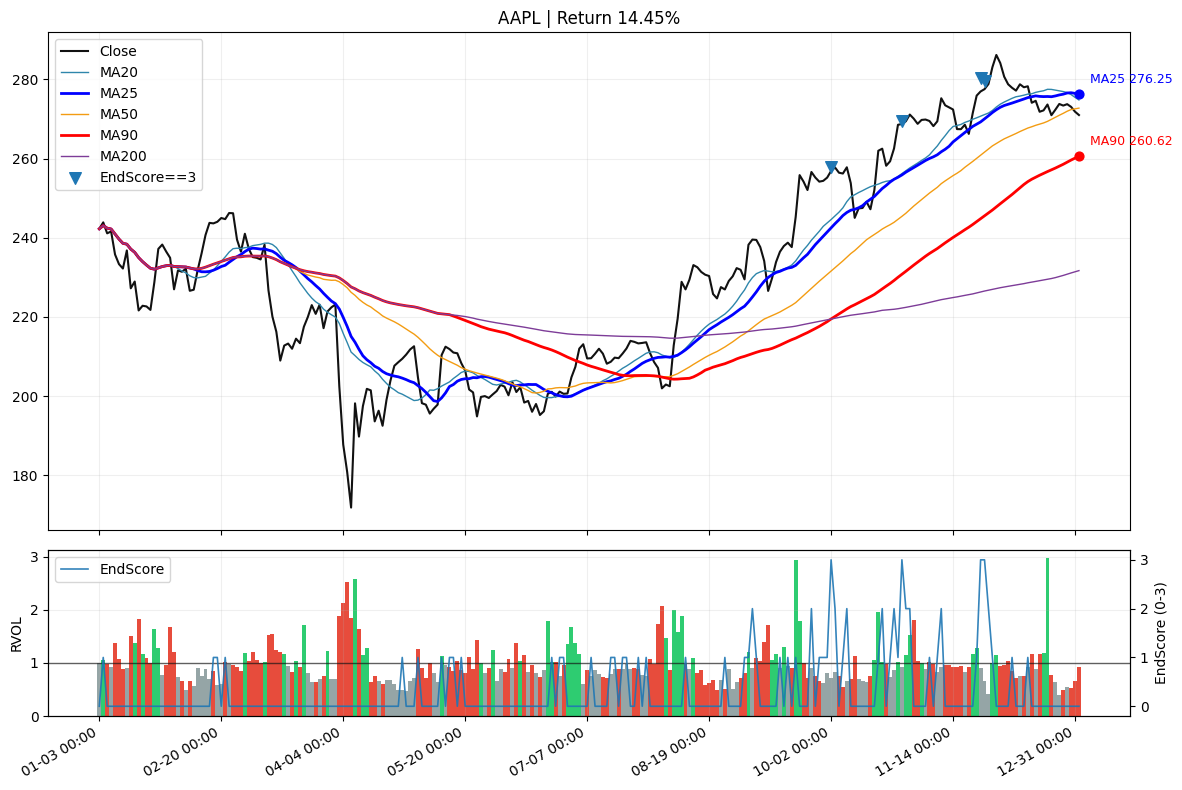

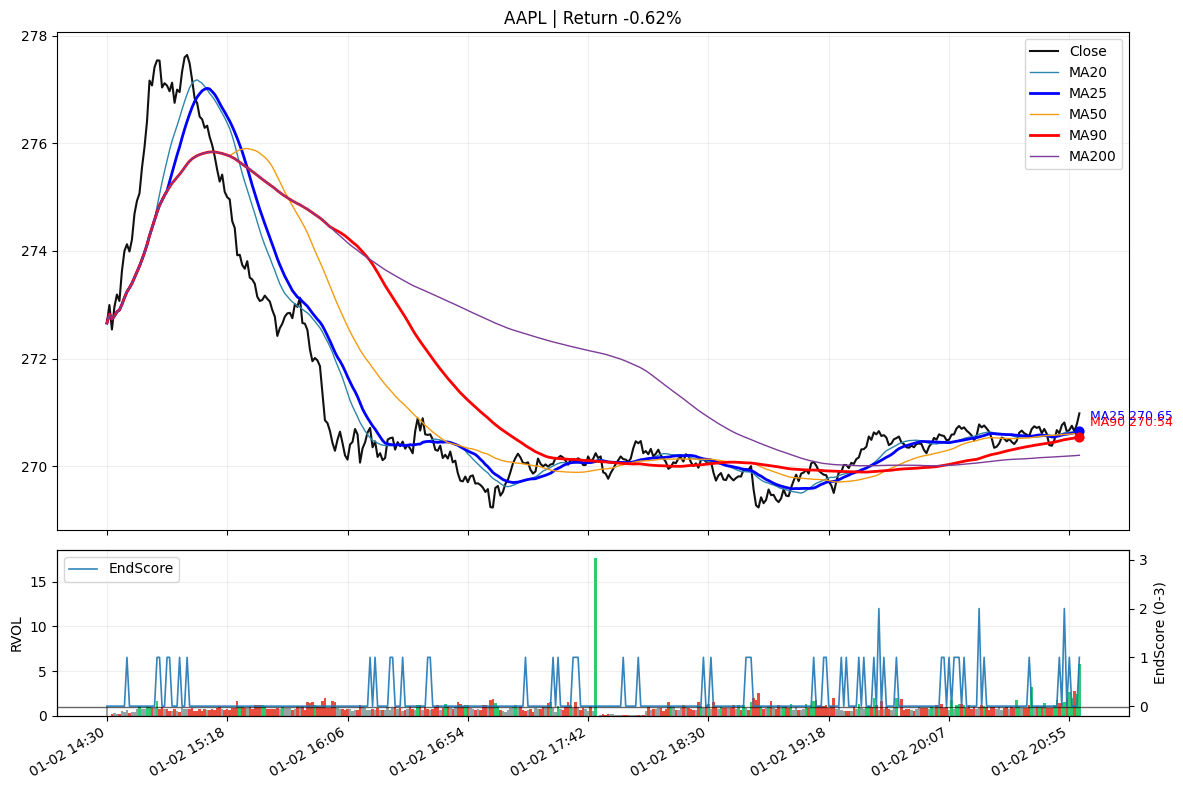

In [443]:
# -----------------------------
# Run
# -----------------------------
if __name__ == "__main__":
    stk = "AAPL"
    plot_trend_signals(stk, period="1y", interval="1d")
    plot_trend_signals(stk, period="1d", interval="1m")

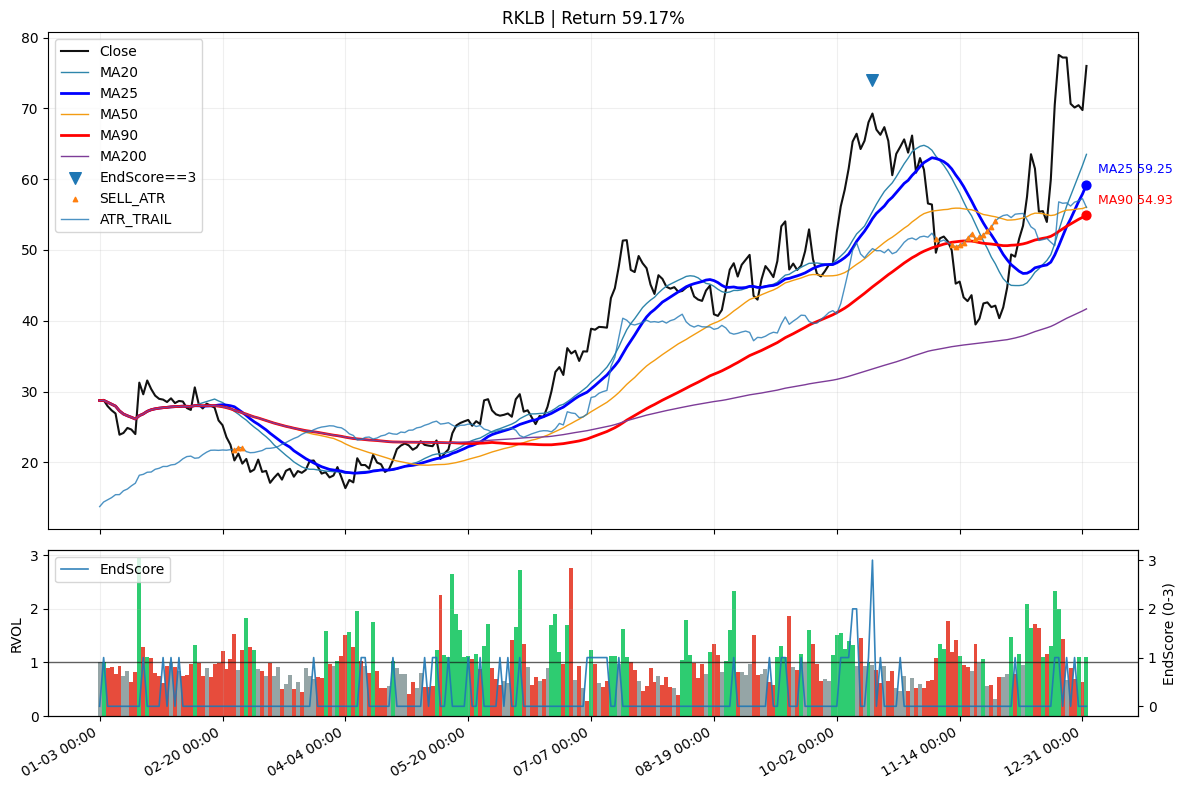

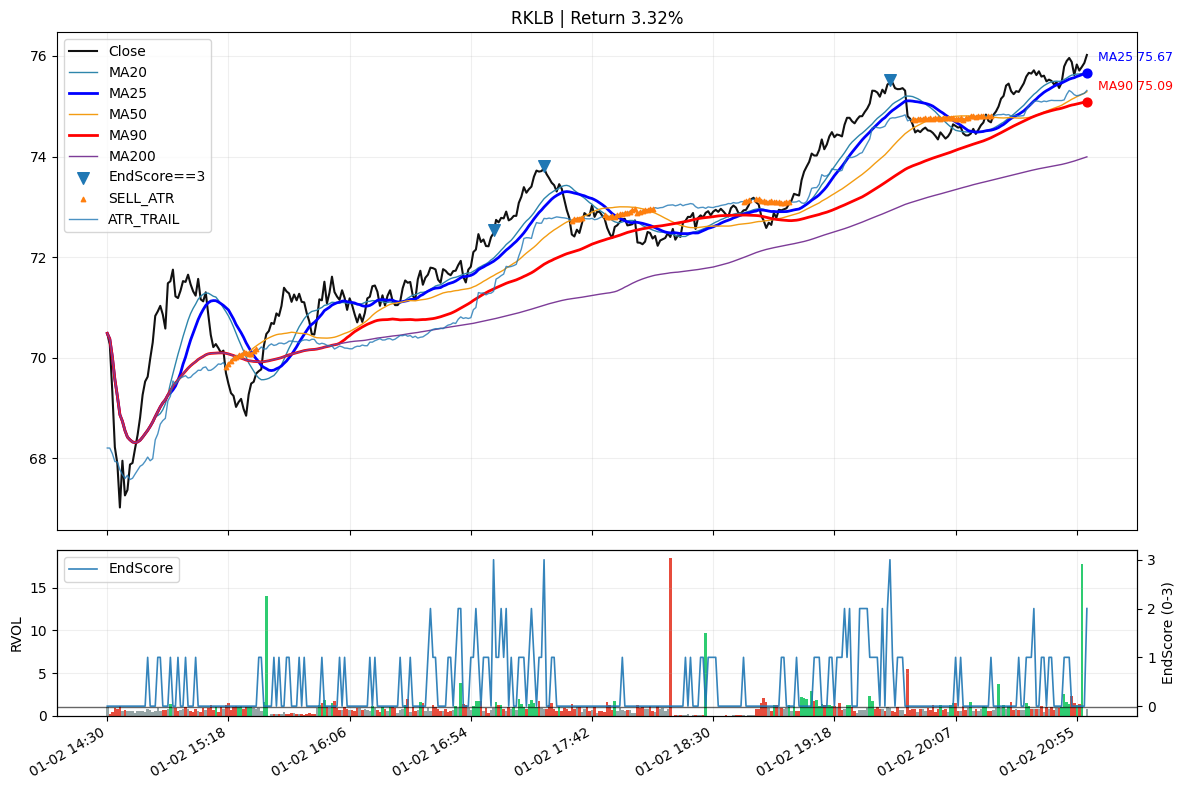

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


# -----------------------------
# Data cleaning
# -----------------------------
def normalize_ohlcv(df: pd.DataFrame) -> pd.DataFrame:
    """统一 yfinance 返回的列结构（兼容 MultiIndex），并确保有 Open/High/Low/Close/Volume。"""
    df = df.copy()

    # MultiIndex 兼容
    if isinstance(df.columns, pd.MultiIndex):
        if "Close" in df.columns.get_level_values(0):
            df.columns = df.columns.get_level_values(0)
        else:
            df.columns = df.columns.get_level_values(-1)

    df.rename(columns={c: c.strip().title() for c in df.columns}, inplace=True)

    need = ["Open", "High", "Low", "Close", "Volume"]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}. Got: {list(df.columns)}")

    # 去时区
    try:
        if getattr(df.index, "tz", None) is not None:
            df.index = df.index.tz_localize(None)
    except Exception:
        pass

    return df.dropna(subset=need).copy()


# -----------------------------
# Base indicators
# -----------------------------
def add_indicators(dfi: pd.DataFrame) -> pd.DataFrame:
    """均线 + Ret1 + RVOL（稳健版：min_periods=1）"""
    dfi = dfi.copy()

    for n in [20, 25, 50, 90, 200]:
        dfi[f"MA{n}"] = dfi["Close"].rolling(n, min_periods=1).mean()

    dfi["Ret1"] = dfi["Close"].pct_change().fillna(0.0)

    vol_ma = dfi["Volume"].rolling(20, min_periods=1).mean()
    dfi["RVOL"] = (dfi["Volume"] / vol_ma).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    return dfi


def add_volume_pressure_features(dfi: pd.DataFrame) -> pd.DataFrame:
    """占位（你可替换成自己更复杂版本）"""
    return dfi.copy()


# -----------------------------
# RSI + Bull Endgame ("多头末梢")
# -----------------------------
def _rsi_ewm(close: pd.Series, length: int = 14) -> pd.Series:
    delta = close.diff()
    gain = delta.clip(lower=0.0)
    loss = (-delta).clip(lower=0.0)

    avg_gain = gain.ewm(alpha=1 / length, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1 / length, adjust=False).mean()

    rs = avg_gain / avg_loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(50)


def add_bull_endgame_indicator(
    dfi: pd.DataFrame,
    rsi_len: int = 14,
    div_lookback: int = 20,
    vol_ma: int = 20,
    doji_body_ratio: float = 0.2,
    upper_shadow_ratio: float = 0.6,
) -> pd.DataFrame:
    """
    EndScore(0~3) = End_Div + End_Candle + End_Vol
    输出：
      End_Div, End_Candle, End_Vol, BullEndgameScore
    """
    dfi = dfi.copy()

    if "RSI" not in dfi.columns:
        dfi["RSI"] = _rsi_ewm(dfi["Close"], rsi_len)

    # 创新高（近 div_lookback）
    hh = dfi["Close"].rolling(div_lookback, min_periods=div_lookback).max()
    prev_hh = hh.shift(1)
    new_high = dfi["Close"] >= prev_hh

    # A) 背离代理：创新高但 RSI 窗口最高没同步创新高 + RSI>50
    rsi_hh = dfi["RSI"].rolling(div_lookback, min_periods=div_lookback).max()
    rsi_prev_hh = rsi_hh.shift(1)
    rsi_weaker = dfi["RSI"] < rsi_prev_hh
    dfi["End_Div"] = (new_high & rsi_weaker & (dfi["RSI"] > 50)).fillna(False)

    # B) Doji / 长上影（强势背景：Close > MA20）
    rng = (dfi["High"] - dfi["Low"]).replace(0, np.nan)
    body = (dfi["Close"] - dfi["Open"]).abs()
    upper = dfi["High"] - np.maximum(dfi["Open"], dfi["Close"])

    is_doji = (body / rng) < doji_body_ratio
    is_upper_shadow = (upper / rng) > upper_shadow_ratio

    ma20 = dfi["MA20"] if "MA20" in dfi.columns else dfi["Close"].rolling(20, min_periods=1).mean()
    up_context = dfi["Close"] > ma20
    dfi["End_Candle"] = (up_context & (is_doji | is_upper_shadow)).fillna(False)

    # C) 量能走弱：创新高但 Volume < 均量 或 RVOL<=1
    if "Volume" in dfi.columns:
        vma = dfi["Volume"].rolling(vol_ma, min_periods=1).mean()
        vol_weak = dfi["Volume"] < vma
    else:
        vol_weak = pd.Series(False, index=dfi.index)

    rvol_weak = (dfi["RVOL"] <= 1.0) if "RVOL" in dfi.columns else pd.Series(False, index=dfi.index)
    dfi["End_Vol"] = (new_high & (vol_weak | rvol_weak)).fillna(False)

    dfi["BullEndgameScore"] = dfi[["End_Div", "End_Candle", "End_Vol"]].astype(int).sum(axis=1)
    return dfi


# -----------------------------
# Sell point method 1: EndScore + confirmation breakdown
# -----------------------------
def add_sell_confirm_signals(
    dfi: pd.DataFrame,
    need_score: int = 3,
    confirm_lookback: int = 10,
    require_trend_ok: bool = True,
    use_ma25_break: bool = True,
    use_swing_break: bool = True,
    use_down_rvol: bool = True,
) -> pd.DataFrame:
    """
    卖点1（SELL_CONFIRM）：EndScore>=need_score 且出现确认破位（至少命中一个确认项）
    - break_ma25: Close < MA25
    - break_swing: Close < 最近N根Low最低（shift(1)避免前视）
    - down_rvol: Ret1<0 且 RVOL>1
    """
    dfi = dfi.copy()

    trend_ok = (dfi["MA25"] > dfi["MA90"]).fillna(False) if ("MA25" in dfi.columns and "MA90" in dfi.columns) else True
    end_ok = (dfi["BullEndgameScore"] >= need_score).fillna(False)

    swing_low = dfi["Low"].rolling(confirm_lookback, min_periods=1).min().shift(1)
    break_swing = (dfi["Close"] < swing_low).fillna(False)

    break_ma25 = (dfi["Close"] < dfi["MA25"]).fillna(False)

    down_rvol = pd.Series(False, index=dfi.index)
    if "Ret1" in dfi.columns and "RVOL" in dfi.columns:
        down_rvol = ((dfi["Ret1"] < 0) & (dfi["RVOL"] > 1)).fillna(False)

    confirm = pd.Series(False, index=dfi.index)
    if use_ma25_break:
        confirm = confirm | break_ma25
    if use_swing_break:
        confirm = confirm | break_swing
    if use_down_rvol:
        confirm = confirm | down_rvol

    if require_trend_ok is True and not isinstance(trend_ok, bool):
        dfi["SELL_CONFIRM"] = (trend_ok & end_ok & confirm).fillna(False)
    else:
        dfi["SELL_CONFIRM"] = (end_ok & confirm).fillna(False)

    return dfi


# -----------------------------
# Sell point method 2: ATR trailing stop
# -----------------------------
def _atr(dfi: pd.DataFrame, length: int = 14) -> pd.Series:
    high = dfi["High"]
    low = dfi["Low"]
    close = dfi["Close"]
    prev_close = close.shift(1)

    tr = pd.concat([
        (high - low),
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)

    return tr.ewm(alpha=1/length, adjust=False).mean()


def add_atr_trailing_stop_signals(
    dfi: pd.DataFrame,
    atr_len: int = 14,
    atr_mult: float = 3.0,
    require_trend_ok: bool = True,
) -> pd.DataFrame:
    """
    卖点2（SELL_ATR）：Close 跌破 ATR 跟踪止盈线
    - trail = rolling_max(Close) - atr_mult * ATR
    注：这里默认用“全局滚动最高Close”作为示例（适合画信号点）。
       如果你要严格“持仓后最高价”，应在回测循环里按持仓更新。
    """
    dfi = dfi.copy()
    dfi["ATR"] = _atr(dfi, atr_len)

    rolling_peak = dfi["Close"].cummax()
    dfi["ATR_TRAIL"] = rolling_peak - atr_mult * dfi["ATR"]

    trend_ok = (dfi["MA25"] > dfi["MA90"]).fillna(False) if ("MA25" in dfi.columns and "MA90" in dfi.columns) else True
    cross_down = (dfi["Close"] < dfi["ATR_TRAIL"]).fillna(False)

    if require_trend_ok is True and not isinstance(trend_ok, bool):
        dfi["SELL_ATR"] = (trend_ok & cross_down).fillna(False)
    else:
        dfi["SELL_ATR"] = cross_down.fillna(False)

    return dfi


# -----------------------------
# Plot
# -----------------------------
def plot_trend_signals(ticker, period="5d", interval="1m"):
    df = yf.download(ticker, period=period, interval=interval, auto_adjust=True, progress=False)
    if df is None or len(df) == 0:
        print(f"[{ticker}] No data returned by yfinance.")
        return

    df = normalize_ohlcv(df)
    if len(df) < 5:
        print(f"[{ticker}] Not enough data rows={len(df)}")
        return

    dfi = add_indicators(df)
    dfi = add_volume_pressure_features(dfi)

    # ===== 多头末梢参数（按你之前设置）=====
    if interval.endswith("m"):
        dfi = add_bull_endgame_indicator(
            dfi,
            rsi_len=10,
            div_lookback=120,
            vol_ma=30,
            doji_body_ratio=0.25,
            upper_shadow_ratio=0.55,
        )
    else:
        dfi = add_bull_endgame_indicator(
            dfi,
            rsi_len=14,
            div_lookback=120,
            vol_ma=20,
            doji_body_ratio=0.18,
            upper_shadow_ratio=0.65,
        )

    # ===== 两套“卖出点”都加上 =====
    dfi = add_sell_confirm_signals(dfi, need_score=3, confirm_lookback=10, require_trend_ok=True)
    dfi = add_atr_trailing_stop_signals(dfi, atr_len=14, atr_mult=2.0, require_trend_ok=True)

    dfi = dfi.dropna(subset=["Close"]).copy()
    if len(dfi) == 0:
        print(f"[{ticker}] Empty after indicators.")
        return

    x = np.arange(len(dfi))

    fig, (ax, axr) = plt.subplots(
        2, 1, figsize=(12, 8), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
    )

    # Price + MAs
    ax.plot(x, dfi["Close"], label="Close", color="#111111", linewidth=1.5)
    ax.plot(x, dfi["MA20"], label="MA20", color="#2E86AB", linewidth=1)
    ax.plot(x, dfi["MA25"], label="MA25", color="blue", linewidth=2)
    ax.plot(x, dfi["MA50"], label="MA50", color="#F39C12", linewidth=1)
    ax.plot(x, dfi["MA90"], label="MA90", color="red", linewidth=2)
    ax.plot(x, dfi["MA200"], label="MA200", color="#7D3C98", linewidth=1)

    # mark last MA25 / MA90 values
    ma25_last = float(dfi["MA25"].iloc[-1])
    ma90_last = float(dfi["MA90"].iloc[-1])
    ax.scatter([x[-1]], [ma25_last], color="blue", s=40, zorder=6)
    ax.scatter([x[-1]], [ma90_last], color="red", s=40, zorder=6)
    ax.annotate(
        f"MA25 {ma25_last:.2f}", (x[-1], ma25_last),
        textcoords="offset points", xytext=(8, 8), fontsize=9, color="blue"
    )
    ax.annotate(
        f"MA90 {ma90_last:.2f}", (x[-1], ma90_last),
        textcoords="offset points", xytext=(8, 8), fontsize=9, color="red"
    )

    # ===== 仅控制图上的倒三角提示：EndScore==3 且 MA25>MA90 =====
    trend_ok = (dfi["MA25"] > dfi["MA90"]).fillna(False)
    end3 = (dfi["BullEndgameScore"] >= 3).fillna(False) & trend_ok
    if end3.any():
        ax.scatter(
            x[end3.values],
            dfi["High"].values[end3.values],
            marker="v",
            s=70,
            zorder=7,
            label="EndScore==3"
        )

    # ===== 卖点1：末梢+确认破位（用 X 标记）=====
    sell1 = dfi["SELL_CONFIRM"].fillna(False).values
    if sell1.any():
        ax.scatter(
            x[sell1],
            dfi["Low"].values[sell1],
            marker="x",
            s=80,
            zorder=8,
            label="SELL_CONFIRM"
        )

    # ===== 卖点2：ATR 跟踪止盈（用 ^ 标记在 trail 附近更直观）=====
    sell2 = dfi["SELL_ATR"].fillna(False).values
    if sell2.any():
        ax.scatter(
            x[sell2],
            dfi["ATR_TRAIL"].values[sell2],
            marker="^",
            s=10,
            zorder=8,
            label="SELL_ATR"
        )

    # 画 ATR trail 线（可选：更直观）
    ax.plot(x, dfi["ATR_TRAIL"], linewidth=1, alpha=0.8, label="ATR_TRAIL")

    # ===== buy/sell rules（你原来的回测逻辑：不受上面两套卖点影响）=====
    above_red = (dfi["MA25"] > dfi["MA90"]).fillna(False)
    touch_red = (dfi["Close"] <= dfi["MA90"]).fillna(False)

    in_pos = False
    entry_price = None
    total_return = 0.0
    hold_mask = []

    for i in range(len(dfi)):
        if (not in_pos) and bool(above_red.iloc[i]):
            entry_price = float(dfi["Close"].iloc[i])
            in_pos = True
        elif in_pos and ((not bool(above_red.iloc[i])) or bool(touch_red.iloc[i])):
            exit_price = float(dfi["Close"].iloc[i])
            total_return += (exit_price / entry_price) - 1.0
            in_pos = False
        hold_mask.append(in_pos)

    if in_pos and entry_price is not None:
        exit_price = float(dfi["Close"].iloc[-1])
        total_return += (exit_price / entry_price) - 1.0

    ax.set_title(f"{ticker} | Return {total_return:.2%}")
    ax.legend()
    ax.grid(alpha=0.2)

    # RVOL bars
    colors = np.where(
        (dfi["Ret1"] >= 0) & (dfi["RVOL"] > 1),
        "#2ecc71",
        np.where(dfi["Ret1"] < 0, "#e74c3c", "#95a5a6")
    )
    axr.bar(x, dfi["RVOL"], color=colors, width=1.0)
    axr.axhline(1.0, color="black", linewidth=1, alpha=0.6)
    axr.set_ylabel("RVOL")
    axr.grid(alpha=0.2)

    # EndScore line on right axis
    axs = axr.twinx()
    axs.plot(x, dfi["BullEndgameScore"].fillna(0), linewidth=1.2, alpha=0.9, label="EndScore")
    axs.set_ylim(-0.2, 3.2)
    axs.set_ylabel("EndScore (0-3)")

    # merge legends (bottom chart)
    h1, l1 = axr.get_legend_handles_labels()
    h2, l2 = axs.get_legend_handles_labels()
    axr.legend(h1 + h2, l1 + l2, loc="upper left")

    step = max(len(dfi) // 8, 1)
    axr.set_xticks(x[::step])
    axr.set_xticklabels(dfi.index.strftime("%m-%d %H:%M")[::step], rotation=30, ha="right")

    plt.tight_layout()
    plt.show()


# -----------------------------
# Run
# -----------------------------
if __name__ == "__main__":
    stk = "RKLB"
    plot_trend_signals(stk, period="1y", interval="1d")
    plot_trend_signals(stk, period="1d", interval="1m")


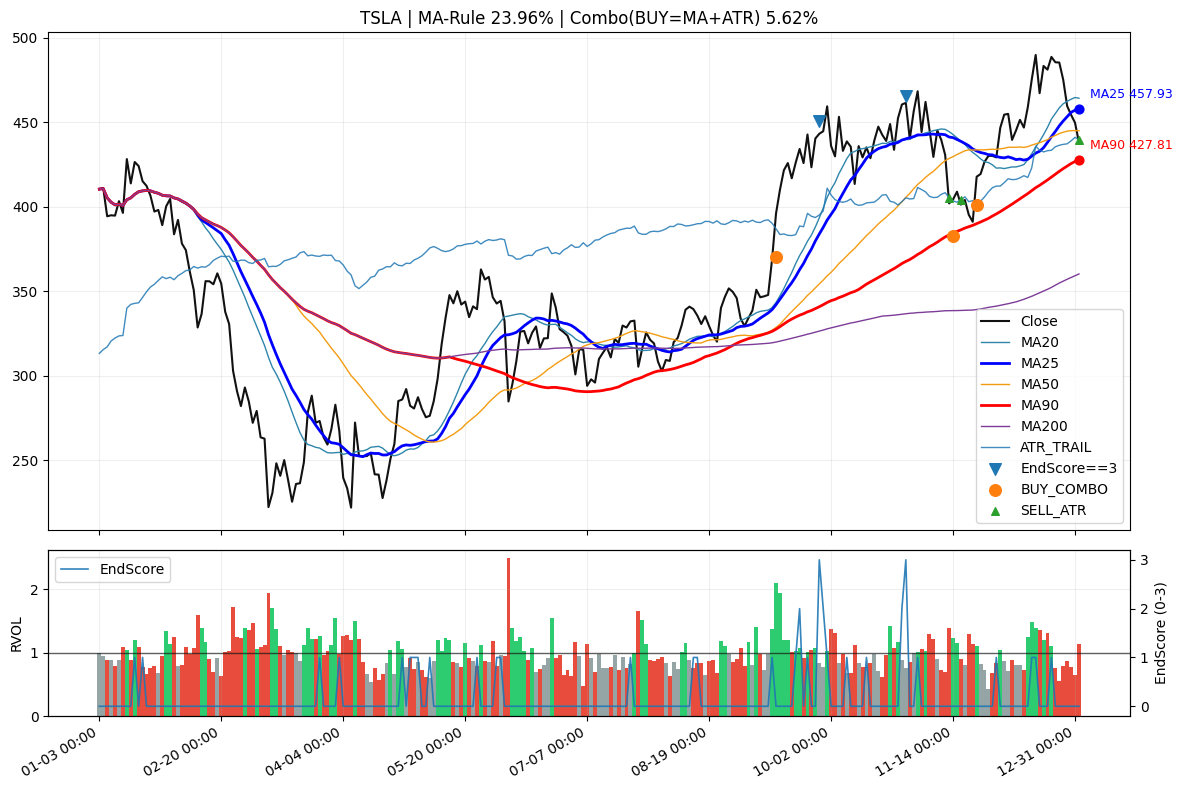

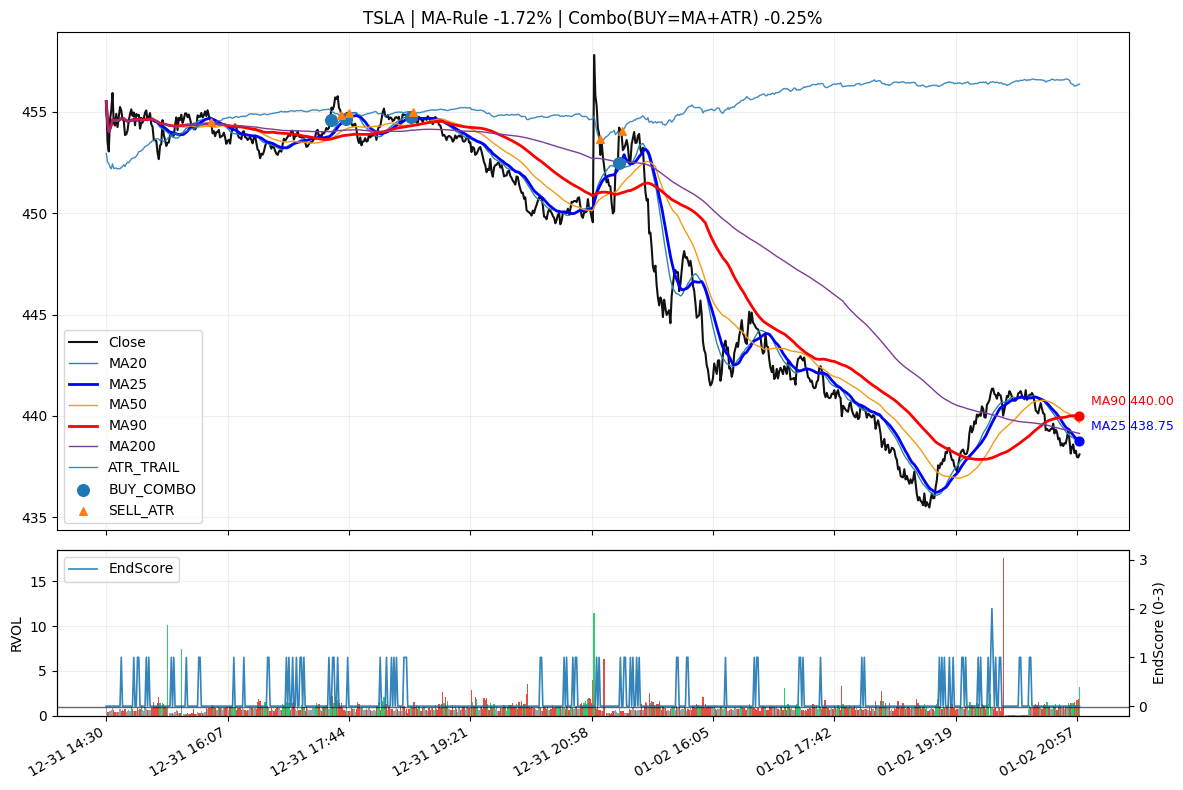

In [470]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


# -----------------------------
# Data cleaning
# -----------------------------
def normalize_ohlcv(df: pd.DataFrame) -> pd.DataFrame:
    """统一 yfinance 返回的列结构（兼容 MultiIndex），并确保有 Open/High/Low/Close/Volume。"""
    df = df.copy()

    if isinstance(df.columns, pd.MultiIndex):
        if "Close" in df.columns.get_level_values(0):
            df.columns = df.columns.get_level_values(0)
        else:
            df.columns = df.columns.get_level_values(-1)

    df.rename(columns={c: c.strip().title() for c in df.columns}, inplace=True)

    need = ["Open", "High", "Low", "Close", "Volume"]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}. Got: {list(df.columns)}")

    try:
        if getattr(df.index, "tz", None) is not None:
            df.index = df.index.tz_localize(None)
    except Exception:
        pass

    return df.dropna(subset=need).copy()


# -----------------------------
# Base indicators
# -----------------------------
def add_indicators(dfi: pd.DataFrame) -> pd.DataFrame:
    """均线 + Ret1 + RVOL（稳健版：min_periods=1）"""
    dfi = dfi.copy()

    for n in [20, 25, 50, 90, 200]:
        dfi[f"MA{n}"] = dfi["Close"].rolling(n, min_periods=1).mean()

    dfi["Ret1"] = dfi["Close"].pct_change().fillna(0.0)

    vol_ma = dfi["Volume"].rolling(20, min_periods=1).mean()
    dfi["RVOL"] = (dfi["Volume"] / vol_ma).replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return dfi


def add_volume_pressure_features(dfi: pd.DataFrame) -> pd.DataFrame:
    """占位（你可替换成自己更复杂版本）"""
    return dfi.copy()


# -----------------------------
# RSI + Bull Endgame ("多头末梢")
# -----------------------------
def _rsi_ewm(close: pd.Series, length: int = 14) -> pd.Series:
    delta = close.diff()
    gain = delta.clip(lower=0.0)
    loss = (-delta).clip(lower=0.0)

    avg_gain = gain.ewm(alpha=1 / length, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1 / length, adjust=False).mean()

    rs = avg_gain / avg_loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(50)


def add_bull_endgame_indicator(
    dfi: pd.DataFrame,
    rsi_len: int = 14,
    div_lookback: int = 20,
    vol_ma: int = 20,
    doji_body_ratio: float = 0.2,
    upper_shadow_ratio: float = 0.6,
) -> pd.DataFrame:
    """
    EndScore(0~3) = End_Div + End_Candle + End_Vol
    输出：End_Div, End_Candle, End_Vol, BullEndgameScore
    """
    dfi = dfi.copy()

    if "RSI" not in dfi.columns:
        dfi["RSI"] = _rsi_ewm(dfi["Close"], rsi_len)

    hh = dfi["Close"].rolling(div_lookback, min_periods=div_lookback).max()
    prev_hh = hh.shift(1)
    new_high = dfi["Close"] >= prev_hh

    rsi_hh = dfi["RSI"].rolling(div_lookback, min_periods=div_lookback).max()
    rsi_prev_hh = rsi_hh.shift(1)
    rsi_weaker = dfi["RSI"] < rsi_prev_hh
    dfi["End_Div"] = (new_high & rsi_weaker & (dfi["RSI"] > 50)).fillna(False)

    rng = (dfi["High"] - dfi["Low"]).replace(0, np.nan)
    body = (dfi["Close"] - dfi["Open"]).abs()
    upper = dfi["High"] - np.maximum(dfi["Open"], dfi["Close"])

    is_doji = (body / rng) < doji_body_ratio
    is_upper_shadow = (upper / rng) > upper_shadow_ratio

    ma20 = dfi["MA20"] if "MA20" in dfi.columns else dfi["Close"].rolling(20, min_periods=1).mean()
    up_context = dfi["Close"] > ma20
    dfi["End_Candle"] = (up_context & (is_doji | is_upper_shadow)).fillna(False)

    if "Volume" in dfi.columns:
        vma = dfi["Volume"].rolling(vol_ma, min_periods=1).mean()
        vol_weak = dfi["Volume"] < vma
    else:
        vol_weak = pd.Series(False, index=dfi.index)

    rvol_weak = (dfi["RVOL"] <= 1.0) if "RVOL" in dfi.columns else pd.Series(False, index=dfi.index)
    dfi["End_Vol"] = (new_high & (vol_weak | rvol_weak)).fillna(False)

    dfi["BullEndgameScore"] = dfi[["End_Div", "End_Candle", "End_Vol"]].astype(int).sum(axis=1)
    return dfi


# -----------------------------
# Sell points method 1: EndScore + confirmation breakdown
# -----------------------------
def add_sell_confirm_signals(
    dfi: pd.DataFrame,
    need_score: int = 3,
    confirm_lookback: int = 10,
    require_trend_ok: bool = True,
    use_ma25_break: bool = True,
    use_swing_break: bool = True,
    use_down_rvol: bool = True,
) -> pd.DataFrame:
    """
    SELL_CONFIRM：EndScore>=need_score 且出现确认破位（至少命中一个确认项）
    """
    dfi = dfi.copy()

    trend_ok = (dfi["MA25"] > dfi["MA90"]).fillna(False) if ("MA25" in dfi.columns and "MA90" in dfi.columns) else True
    end_ok = (dfi["BullEndgameScore"] >= need_score).fillna(False)

    swing_low = dfi["Low"].rolling(confirm_lookback, min_periods=1).min().shift(1)
    break_swing = (dfi["Close"] < swing_low).fillna(False)
    break_ma25 = (dfi["Close"] < dfi["MA25"]).fillna(False)

    down_rvol = pd.Series(False, index=dfi.index)
    if "Ret1" in dfi.columns and "RVOL" in dfi.columns:
        down_rvol = ((dfi["Ret1"] < 0) & (dfi["RVOL"] > 1)).fillna(False)

    confirm = pd.Series(False, index=dfi.index)
    if use_ma25_break:
        confirm = confirm | break_ma25
    if use_swing_break:
        confirm = confirm | break_swing
    if use_down_rvol:
        confirm = confirm | down_rvol

    if require_trend_ok is True and not isinstance(trend_ok, bool):
        dfi["SELL_CONFIRM"] = (trend_ok & end_ok & confirm).fillna(False)
    else:
        dfi["SELL_CONFIRM"] = (end_ok & confirm).fillna(False)

    return dfi


# -----------------------------
# ATR / Trailing Stop + Buy confirm
# -----------------------------
def _atr(dfi: pd.DataFrame, length: int = 14) -> pd.Series:
    high = dfi["High"]
    low = dfi["Low"]
    close = dfi["Close"]
    prev_close = close.shift(1)

    tr = pd.concat(
        [(high - low), (high - prev_close).abs(), (low - prev_close).abs()],
        axis=1
    ).max(axis=1)

    return tr.ewm(alpha=1 / length, adjust=False).mean()


def add_atr_trailing_stop(dfi: pd.DataFrame, atr_len: int = 14, atr_mult: float = 3.0) -> pd.DataFrame:
    """
    生成 ATR 与 ATR_TRAIL：
      ATR_TRAIL = cummax(Close) - atr_mult * ATR
    注：用于画信号/确认买点很方便；若你要严格“持仓后最高”，应在回测循环中更新峰值。
    """
    dfi = dfi.copy()
    dfi["ATR"] = _atr(dfi, atr_len)
    peak = dfi["Close"].cummax()
    dfi["ATR_TRAIL"] = peak - atr_mult * dfi["ATR"]
    return dfi


def add_buy_combo_signals(dfi: pd.DataFrame) -> pd.DataFrame:
    """
    组合买入（你要的）：
      环境过滤：MA25 > MA90
      具体买点：Close 上穿 ATR_TRAIL（从下到上）
    输出：BUY_COMBO (bool)
    """
    dfi = dfi.copy()
    if "ATR_TRAIL" not in dfi.columns:
        raise ValueError("ATR_TRAIL not found. Call add_atr_trailing_stop() first.")

    trend_ok = (dfi["MA25"] > dfi["MA90"]).fillna(False)

    cross_up = (dfi["Close"] > dfi["ATR_TRAIL"]) & (dfi["Close"].shift(1) <= dfi["ATR_TRAIL"].shift(1))
    cross_up = cross_up.fillna(False)

    dfi["BUY_COMBO"] = (trend_ok & cross_up).fillna(False)
    return dfi


def add_sell_atr_signals(dfi: pd.DataFrame) -> pd.DataFrame:
    """
    SELL_ATR：在多头环境下 Close 跌破 ATR_TRAIL（从上到下）
    输出：SELL_ATR (bool)
    """
    dfi = dfi.copy()
    if "ATR_TRAIL" not in dfi.columns:
        raise ValueError("ATR_TRAIL not found. Call add_atr_trailing_stop() first.")

    trend_ok = (dfi["MA25"] > dfi["MA90"]).fillna(False)
    cross_down = (dfi["Close"] < dfi["ATR_TRAIL"]) & (dfi["Close"].shift(1) >= dfi["ATR_TRAIL"].shift(1))
    cross_down = cross_down.fillna(False)

    dfi["SELL_ATR"] = (trend_ok & cross_down).fillna(False)
    return dfi


# -----------------------------
# Simple backtest for combo strategy (optional, for title display)
# -----------------------------
def backtest_combo(dfi: pd.DataFrame, exit_mode: str = "atr_or_confirm") -> float:
    """
    组合策略回测（用于显示收益，不影响你原来的MA回测）：
      进场：BUY_COMBO
      出场：
        - "atr_or_confirm"：SELL_ATR 或 SELL_CONFIRM 任一触发
        - "atr"：仅 SELL_ATR
        - "confirm"：仅 SELL_CONFIRM
    返回：total_return（简单累计，不复利，不含手续费滑点）
    """
    in_pos = False
    entry = None
    total = 0.0

    sell_atr = dfi["SELL_ATR"].fillna(False)
    sell_cfm = dfi["SELL_CONFIRM"].fillna(False)

    if exit_mode == "atr":
        sell_sig = sell_atr
    elif exit_mode == "confirm":
        sell_sig = sell_cfm
    else:
        sell_sig = (sell_atr | sell_cfm)

    buy_sig = dfi["BUY_COMBO"].fillna(False)

    for i in range(len(dfi)):
        if (not in_pos) and bool(buy_sig.iloc[i]):
            entry = float(dfi["Close"].iloc[i])
            in_pos = True
        elif in_pos and bool(sell_sig.iloc[i]):
            exitp = float(dfi["Close"].iloc[i])
            total += (exitp / entry) - 1.0
            in_pos = False

    if in_pos and entry is not None:
        exitp = float(dfi["Close"].iloc[-1])
        total += (exitp / entry) - 1.0

    return total


# -----------------------------
# Plot
# -----------------------------
def plot_trend_signals(ticker, period="5d", interval="1m"):
    df = yf.download(ticker, period=period, interval=interval, auto_adjust=True, progress=False)
    if df is None or len(df) == 0:
        print(f"[{ticker}] No data returned by yfinance.")
        return

    df = normalize_ohlcv(df)
    if len(df) < 5:
        print(f"[{ticker}] Not enough data rows={len(df)}")
        return

    dfi = add_indicators(df)
    dfi = add_volume_pressure_features(dfi)

    # ===== 多头末梢参数（按你之前设置）=====
    if interval.endswith("m"):
        dfi = add_bull_endgame_indicator(
            dfi,
            rsi_len=10,
            div_lookback=120,
            vol_ma=30,
            doji_body_ratio=0.25,
            upper_shadow_ratio=0.55,
        )
        atr_len, atr_mult = 14, 3.0
    else:
        dfi = add_bull_endgame_indicator(
            dfi,
            rsi_len=14,
            div_lookback=120,
            vol_ma=20,
            doji_body_ratio=0.18,
            upper_shadow_ratio=0.65,
        )
        atr_len, atr_mult = 14, 3.0

    # ===== ATR trail + 组合买入 + 两套卖点 =====
    dfi = add_atr_trailing_stop(dfi, atr_len=atr_len, atr_mult=atr_mult)
    dfi = add_buy_combo_signals(dfi)                 # ✅ 你要的：MA25>MA90 + 上穿 ATR_TRAIL
    dfi = add_sell_atr_signals(dfi)                  # ATR 出场点（可用）
    dfi = add_sell_confirm_signals(dfi, need_score=3, confirm_lookback=10, require_trend_ok=True)  # 末梢确认出场

    dfi = dfi.dropna(subset=["Close"]).copy()
    if len(dfi) == 0:
        print(f"[{ticker}] Empty after indicators.")
        return

    x = np.arange(len(dfi))

    fig, (ax, axr) = plt.subplots(
        2, 1, figsize=(12, 8), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
    )

    # Price + MAs
    ax.plot(x, dfi["Close"], label="Close", color="#111111", linewidth=1.5)
    ax.plot(x, dfi["MA20"], label="MA20", color="#2E86AB", linewidth=1)
    ax.plot(x, dfi["MA25"], label="MA25", color="blue", linewidth=2)
    ax.plot(x, dfi["MA50"], label="MA50", color="#F39C12", linewidth=1)
    ax.plot(x, dfi["MA90"], label="MA90", color="red", linewidth=2)
    ax.plot(x, dfi["MA200"], label="MA200", color="#7D3C98", linewidth=1)

    # ATR trail line
    ax.plot(x, dfi["ATR_TRAIL"], linewidth=1, alpha=0.85, label="ATR_TRAIL")

    # Mark last MA25 / MA90
    ma25_last = float(dfi["MA25"].iloc[-1])
    ma90_last = float(dfi["MA90"].iloc[-1])
    ax.scatter([x[-1]], [ma25_last], color="blue", s=40, zorder=6)
    ax.scatter([x[-1]], [ma90_last], color="red", s=40, zorder=6)
    ax.annotate(f"MA25 {ma25_last:.2f}", (x[-1], ma25_last),
                textcoords="offset points", xytext=(8, 8), fontsize=9, color="blue")
    ax.annotate(f"MA90 {ma90_last:.2f}", (x[-1], ma90_last),
                textcoords="offset points", xytext=(8, 8), fontsize=9, color="red")

    # ===== 倒三角：EndScore==3（仅提示，不影响策略）=====
    trend_ok = (dfi["MA25"] > dfi["MA90"]).fillna(False)
    end3 = (dfi["BullEndgameScore"] >= 3).fillna(False) & trend_ok
    if end3.any():
        ax.scatter(x[end3.values], dfi["High"].values[end3.values],
                   marker="v", s=70, zorder=7, label="EndScore==3")

    # ===== 组合买点：BUY_COMBO（用 o）=====
    buy = dfi["BUY_COMBO"].fillna(False).values
    if buy.any():
        ax.scatter(x[buy], dfi["Low"].values[buy],
                   marker="o", s=70, zorder=8, label="BUY_COMBO")

    # ===== 卖点1：SELL_CONFIRM（末梢+确认破位，用 x）=====
    sell1 = dfi["SELL_CONFIRM"].fillna(False).values
    if sell1.any():
        ax.scatter(x[sell1], dfi["Low"].values[sell1],
                   marker="x", s=90, zorder=9, label="SELL_CONFIRM")

    # ===== 卖点2：SELL_ATR（ATR跌破，用 ^ 标在 trail 附近更直观）=====
    sell2 = dfi["SELL_ATR"].fillna(False).values
    if sell2.any():
        ax.scatter(x[sell2], dfi["ATR_TRAIL"].values[sell2],
                   marker="^", s=30, zorder=9, label="SELL_ATR")

    # ===== 原 MA 回测（不改）=====
    above_red = (dfi["MA25"] > dfi["MA90"]).fillna(False)
    touch_red = (dfi["Close"] <= dfi["MA90"]).fillna(False)

    in_pos = False
    entry_price = None
    total_return_ma = 0.0
    for i in range(len(dfi)):
        if (not in_pos) and bool(above_red.iloc[i]):
            entry_price = float(dfi["Close"].iloc[i])
            in_pos = True
        elif in_pos and ((not bool(above_red.iloc[i])) or bool(touch_red.iloc[i])):
            exit_price = float(dfi["Close"].iloc[i])
            total_return_ma += (exit_price / entry_price) - 1.0
            in_pos = False

    if in_pos and entry_price is not None:
        exit_price = float(dfi["Close"].iloc[-1])
        total_return_ma += (exit_price / entry_price) - 1.0

    # ===== 组合策略回测（显示用，可选）=====
    total_return_combo = backtest_combo(dfi, exit_mode="atr_or_confirm")

    ax.set_title(f"{ticker} | MA-Rule {total_return_ma:.2%} | Combo(BUY=MA+ATR) {total_return_combo:.2%}")
    ax.legend()
    ax.grid(alpha=0.2)

    # RVOL bars
    colors = np.where(
        (dfi["Ret1"] >= 0) & (dfi["RVOL"] > 1),
        "#2ecc71",
        np.where(dfi["Ret1"] < 0, "#e74c3c", "#95a5a6")
    )
    axr.bar(x, dfi["RVOL"], color=colors, width=1.0)
    axr.axhline(1.0, color="black", linewidth=1, alpha=0.6)
    axr.set_ylabel("RVOL")
    axr.grid(alpha=0.2)

    # EndScore line on right axis
    axs = axr.twinx()
    axs.plot(x, dfi["BullEndgameScore"].fillna(0), linewidth=1.2, alpha=0.9, label="EndScore")
    axs.set_ylim(-0.2, 3.2)
    axs.set_ylabel("EndScore (0-3)")

    # merge legends (bottom chart)
    h1, l1 = axr.get_legend_handles_labels()
    h2, l2 = axs.get_legend_handles_labels()
    axr.legend(h1 + h2, l1 + l2, loc="upper left")

    step = max(len(dfi) // 8, 1)
    axr.set_xticks(x[::step])
    axr.set_xticklabels(dfi.index.strftime("%m-%d %H:%M")[::step], rotation=30, ha="right")

    plt.tight_layout()
    plt.show()


# -----------------------------
# Run
# -----------------------------
if __name__ == "__main__":
    stk = "TSLA"
    plot_trend_signals(stk, period="1y", interval="1d")
    plot_trend_signals(stk, period="2d", interval="1m")


In [514]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


# -----------------------------
# MACD (DIF/DEA)
# -----------------------------
def ema(s: pd.Series, span: int) -> pd.Series:
    return s.ewm(span=span, adjust=False).mean()

def add_macd(df: pd.DataFrame, fast=12, slow=26, signal=9) -> pd.DataFrame:
    df = df.copy()
    df["EMA_fast"] = ema(df["Close"], fast)
    df["EMA_slow"] = ema(df["Close"], slow)
    df["DIF"] = df["EMA_fast"] - df["EMA_slow"]            # DIF 蓝线（快）
    df["DEA"] = ema(df["DIF"], signal)                      # DEA 橙线（慢）
    df["HIST"] = df["DIF"] - df["DEA"]
    return df


# -----------------------------
# Strategy: "MACD只吃一口"（1m版，含“回踩必须贴近0轴”的可调参数）
# -----------------------------
def macd_one_bite_signals(
    df: pd.DataFrame,
    pullback_max_bars: int = 200,
    allow_touch_eps: float = 0.0,
    breakout_use_close: bool = True,
    exec_next_open: bool = False,
    # ✅ 回踩必须贴近0轴
    pullback_touch_zero: bool = True,
    touch_zero_band: float = 0.02,
) -> pd.DataFrame:
    """
    规则（分钟线）：
    1) 水下金叉：DIF 上穿 DEA，且金叉当刻 DIF<0 且 DEA<0
    2) 之后 DIF 上穿 0轴（从<0到>=0）
    3) 上穿0轴后回踩：DIF出现下降段，且回踩期间不跌破0轴（DIF >= -eps）
       并且（可选）回踩期间 DIF 至少一次“贴近0轴”（|DIF| <= touch_zero_band）
    4) 回踩结束（DIF开始回升）后，价格突破“0轴上穿后阶段的最高点”触发买入
       - peak_high：从 cross0 那根 到 回踩结束那根 的 High 最大值
       - 突破判定：默认 Close > peak_high（更稳）；若 breakout_use_close=False 则 High > peak_high（更激进）
    5) 止损=突破那根K线 Low
       止盈=1:2 RR => TP = Entry + 2*(Entry - SL)
    6) 后续先触发 SL 或 TP 就卖出（同一根同时触发默认按 SL 处理，保守）
    """
    d = df.copy()
    dif = d["DIF"]
    dea = d["DEA"]
    close = d["Close"]
    high = d["High"]
    low = d["Low"]
    open_ = d["Open"]

    golden = (dif > dea) & (dif.shift(1) <= dea.shift(1))
    underwater = (dif < 0) & (dea < 0)
    underwater_golden = golden & underwater

    cross0 = (dif >= 0) & (dif.shift(1) < 0)

    # output
    d["BUY"] = False
    d["SELL"] = False
    d["ENTRY"] = np.nan
    d["SL"] = np.nan
    d["TP"] = np.nan
    d["EXIT"] = np.nan
    d["EXIT_REASON"] = ""

    n = len(d)
    i = 1
    in_trade = False
    entry = sl = tp = None

    state = "WAIT_UNDER_GOLDEN"
    cross0_idx = None
    peak_high = None
    pullback_started = False
    touched_zero = False

    while i < n:
        # -----------------------
        # In trade: check exits
        # -----------------------
        if in_trade:
            hit_sl = low.iloc[i] <= sl
            hit_tp = high.iloc[i] >= tp

            if hit_sl or hit_tp:
                d.at[d.index[i], "SELL"] = True
                if hit_sl and hit_tp:
                    d.at[d.index[i], "EXIT"] = sl
                    d.at[d.index[i], "EXIT_REASON"] = "SL&TP_samebar->SL"
                elif hit_sl:
                    d.at[d.index[i], "EXIT"] = sl
                    d.at[d.index[i], "EXIT_REASON"] = "SL"
                else:
                    d.at[d.index[i], "EXIT"] = tp
                    d.at[d.index[i], "EXIT_REASON"] = "TP"

                # reset
                in_trade = False
                entry = sl = tp = None
                state = "WAIT_UNDER_GOLDEN"
                cross0_idx = None
                peak_high = None
                pullback_started = False
                touched_zero = False

            i += 1
            continue

        # -----------------------
        # Not in trade: state machine
        # -----------------------
        if state == "WAIT_UNDER_GOLDEN":
            if underwater_golden.iloc[i]:
                state = "WAIT_CROSS0"
            i += 1
            continue

        if state == "WAIT_CROSS0":
            if cross0.iloc[i]:
                cross0_idx = i
                peak_high = float(high.iloc[i])
                pullback_started = False
                touched_zero = False
                state = "WAIT_PULLBACK"
            i += 1
            continue

        if state == "WAIT_PULLBACK":
            # timeout
            if cross0_idx is not None and (i - cross0_idx) > pullback_max_bars:
                state = "WAIT_UNDER_GOLDEN"
                cross0_idx = None
                peak_high = None
                pullback_started = False
                touched_zero = False
                i += 1
                continue

            # update peak high within the "post-cross0 until pullback end"
            peak_high = max(peak_high, float(high.iloc[i]))

            # pullback begins when DIF starts falling
            if not pullback_started:
                if dif.iloc[i] < dif.iloc[i - 1]:
                    pullback_started = True
                i += 1
                continue

            # pullback must not break below 0 (allow eps)
            if dif.iloc[i] < (0.0 - allow_touch_eps):
                state = "WAIT_UNDER_GOLDEN"
                cross0_idx = None
                peak_high = None
                pullback_started = False
                touched_zero = False
                i += 1
                continue

            # mark "touched near zero"
            if abs(float(dif.iloc[i])) <= float(touch_zero_band):
                touched_zero = True

            # pullback end when DIF stops falling and starts rising
            if dif.iloc[i] >= dif.iloc[i - 1]:
                # if require touching near 0 but not touched yet, keep waiting for deeper pullback
                if pullback_touch_zero and (not touched_zero):
                    i += 1
                    continue
                state = "WAIT_BREAKOUT"

            i += 1
            continue

        if state == "WAIT_BREAKOUT":
            broke = (close.iloc[i] > peak_high) if breakout_use_close else (high.iloc[i] > peak_high)

            if broke:
                # entry price (for 1m, default = current close)
                if exec_next_open and i + 1 < n:
                    entry = float(open_.iloc[i + 1])
                    buy_idx = i + 1
                else:
                    entry = float(close.iloc[i])
                    buy_idx = i

                # stop-loss at breakout bar low (your rule)
                sl = float(low.iloc[i])
                tp = entry + 2.0 * (entry - sl)

                d.at[d.index[buy_idx], "BUY"] = True
                d.at[d.index[buy_idx], "ENTRY"] = entry
                d.at[d.index[buy_idx], "SL"] = sl
                d.at[d.index[buy_idx], "TP"] = tp

                in_trade = True
                i = buy_idx + 1
                continue

            # if DIF breaks below 0, setup invalid
            if dif.iloc[i] < (0.0 - allow_touch_eps):
                state = "WAIT_UNDER_GOLDEN"
                cross0_idx = None
                peak_high = None
                pullback_started = False
                touched_zero = False

            i += 1
            continue

    return d


# -----------------------------
# Plot (1m)
# -----------------------------
def plot_macd_one_bite_1m(
    ticker: str,
    period: str = "7d",
    interval: str = "1m",
    macd_fast: int = 12,
    macd_slow: int = 26,
    macd_signal: int = 9,
    # ---- strategy knobs ----
    pullback_max_bars: int = 200,
    allow_touch_eps: float = 0.0,
    pullback_touch_zero: bool = True,
    touch_zero_band: float = 0.02,
    breakout_use_close: bool = True,
):
    """
    输入 ticker，输出：
      - 主图：价格 + 买入(^) + 卖出(v) + 标注 Entry/SL/TP
      - 副图：DIF(蓝) + DEA(橙) + 0轴
    """
    df = yf.download(ticker, period=period, interval=interval, auto_adjust=True, progress=False)
    if df is None or len(df) < 200:
        print(f"[{ticker}] Not enough 1m data. Try period='5d' or '7d'.")
        return

    # normalize
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    df.columns = [c.strip().title() for c in df.columns]

    need = ["Open", "High", "Low", "Close"]
    if not all(c in df.columns for c in need):
        print(f"[{ticker}] Missing OHLC columns: got {list(df.columns)}")
        return

    df = df.dropna(subset=need).copy()

    # remove tz for nicer labels
    try:
        if getattr(df.index, "tz", None) is not None:
            df.index = df.index.tz_localize(None)
    except Exception:
        pass

    df = add_macd(df, fast=macd_fast, slow=macd_slow, signal=macd_signal)

    sig = macd_one_bite_signals(
        df,
        pullback_max_bars=pullback_max_bars,
        allow_touch_eps=allow_touch_eps,
        breakout_use_close=breakout_use_close,
        exec_next_open=False,
        pullback_touch_zero=pullback_touch_zero,
        touch_zero_band=touch_zero_band,
    )

    x = np.arange(len(sig))

    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(15, 9), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
    )

    # ---- Price ----
    ax1.plot(x, sig["Close"], linewidth=1.4, label="Close")

    buy = sig["BUY"].fillna(False).values
    sell = sig["SELL"].fillna(False).values

    if buy.any():
        ax1.scatter(x[buy], sig["Close"].values[buy], marker="^", s=90, zorder=6, label="BUY")
    if sell.any():
        exit_px = sig["EXIT"].copy().fillna(sig["Close"])
        ax1.scatter(x[sell], exit_px.values[sell], marker="v", s=90, zorder=6, label="SELL")

    # annotate entry/sl/tp on buy bars
    for bi in np.where(buy)[0]:
        entry = sig["ENTRY"].iloc[bi]
        sl = sig["SL"].iloc[bi]
        tp = sig["TP"].iloc[bi]
        if pd.notna(entry):
            ax1.annotate(f"E {entry:.2f}", (bi, entry), textcoords="offset points", xytext=(8, 8), fontsize=9)
        if pd.notna(sl):
            ax1.annotate(f"SL {sl:.2f}", (bi, sl), textcoords="offset points", xytext=(8, -14), fontsize=9)
        if pd.notna(tp):
            ax1.annotate(f"TP {tp:.2f}", (bi, tp), textcoords="offset points", xytext=(8, 18), fontsize=9)

    ax1.set_title(
        f"{ticker} | 1m MACD One-Bite | period={period} | touch_zero_band={touch_zero_band}"
    )
    ax1.grid(alpha=0.25)
    ax1.legend()

    # ---- MACD lines ----
    ax2.axhline(0.0, linewidth=1.0)
    ax2.plot(x, sig["DIF"], linewidth=1.4, label="DIF (fast)")
    ax2.plot(x, sig["DEA"], linewidth=1.4, label="DEA (slow)")
    ax2.grid(alpha=0.25)
    ax2.legend()

    # x labels
    step = max(len(sig) // 10, 1)
    ax2.set_xticks(x[::step])
    ax2.set_xticklabels(sig.index.strftime("%m-%d %H:%M")[::step], rotation=30, ha="right")

    plt.tight_layout()

    # --- Hover 显示（鼠标悬停看到价格/时间/指标）---
    cursor = mplcursors.cursor(ax1.lines + ax2.lines, hover=True)

    @cursor.connect("add")
    def on_add(sel):
        i = int(round(sel.target[0]))
        i = max(0, min(i, len(sig)-1))
        t = sig.index[i]
        row = sig.iloc[i]
        sel.annotation.set_text(
            f"{t}\n"
            f"Close: {row['Close']:.2f}\n"
            f"MA25: {row['MA25']:.2f}  MA90: {row['MA90']:.2f}\n"
            f"DIF: {row['DIF']:.4f}  DEA: {row['DEA']:.4f}"
        )


    plt.show()


# -----------------------------
# Run
# -----------------------------



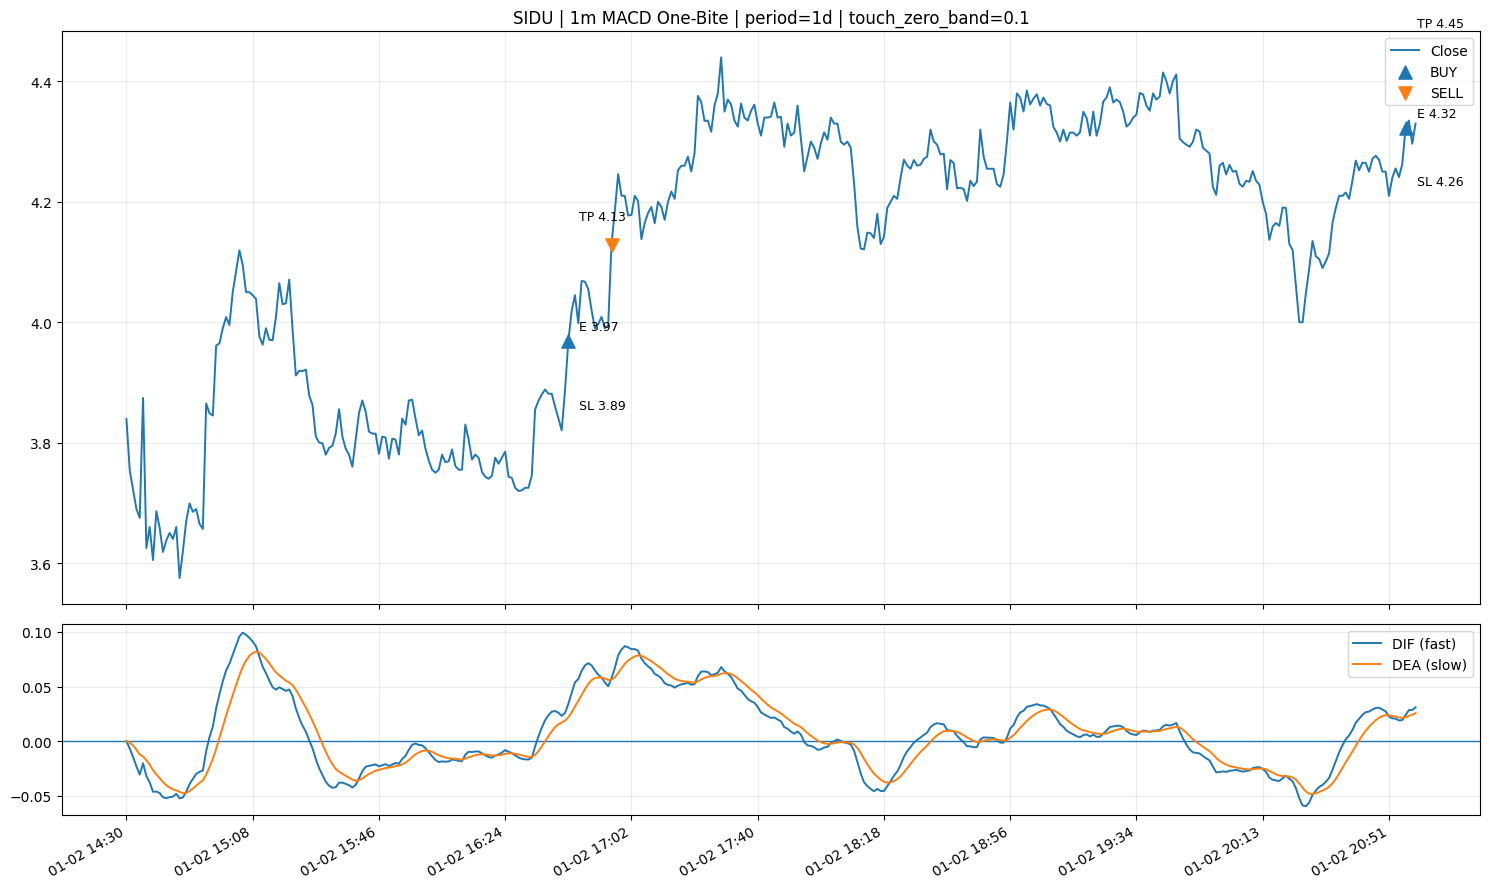

In [515]:
if __name__ == "__main__":
    stk = "SIDU"  # 你输入股票代码
    plot_macd_one_bite_1m(
        stk,
        period="1d",
        interval="1m",
        # 回踩贴近0轴控制（想更多信号就调大，想更严格就调小）
        pullback_touch_zero=False,
        touch_zero_band=0.1,
        # 突破判定：True=收盘确认更稳，False=High突破更激进
        breakout_use_close=True,
    )

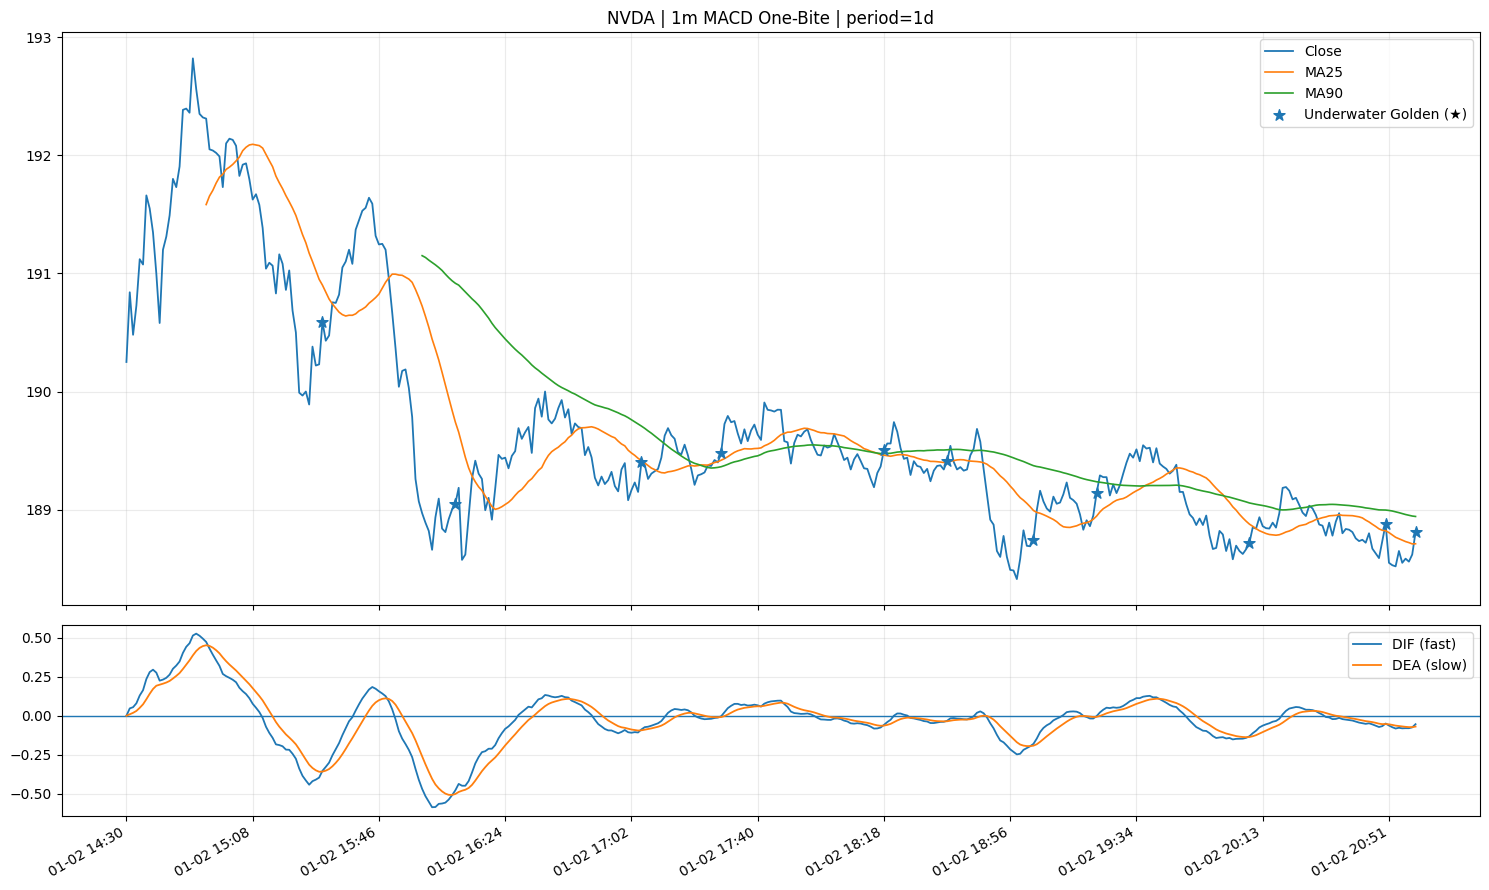

In [522]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ✅ 方案A：鼠标悬停显示信息
import mplcursors


# -----------------------------
# Helpers
# -----------------------------
def ema(s: pd.Series, span: int) -> pd.Series:
    return s.ewm(span=span, adjust=False).mean()

def sma(s: pd.Series, n: int) -> pd.Series:
    return s.rolling(n, min_periods=n).mean()


# -----------------------------
# Indicators: MACD + MA25/MA90
# -----------------------------
def add_macd(df: pd.DataFrame, fast=12, slow=26, signal=9) -> pd.DataFrame:
    df = df.copy()
    df["EMA_fast"] = ema(df["Close"], fast)
    df["EMA_slow"] = ema(df["Close"], slow)
    df["DIF"] = df["EMA_fast"] - df["EMA_slow"]            # DIF 蓝线（快）
    df["DEA"] = ema(df["DIF"], signal)                      # DEA 橙线（慢）
    df["HIST"] = df["DIF"] - df["DEA"]
    return df

def add_mas(df: pd.DataFrame, n1=25, n2=90) -> pd.DataFrame:
    df = df.copy()
    df[f"MA{n1}"] = sma(df["Close"], n1)
    df[f"MA{n2}"] = sma(df["Close"], n2)
    return df


# -----------------------------
# Strategy: "MACD只吃一口"（1m版）
# -----------------------------
def macd_one_bite_signals(
    df: pd.DataFrame,
    pullback_max_bars: int = 200,
    allow_touch_eps: float = 0.0,
    breakout_use_close: bool = True,
    exec_next_open: bool = False,
    # 回踩必须贴近0轴
    pullback_touch_zero: bool = True,
    touch_zero_band: float = 0.02,
) -> pd.DataFrame:
    d = df.copy()
    dif = d["DIF"]
    dea = d["DEA"]
    close = d["Close"]
    high = d["High"]
    low = d["Low"]
    open_ = d["Open"]

    # 水下金叉：DIF上穿DEA 且两者都<0
    golden = (dif > dea) & (dif.shift(1) <= dea.shift(1))
    underwater = (dif < 0) & (dea < 0)
    underwater_golden = (golden & underwater).fillna(False)

    # DIF 上穿0轴
    cross0 = ((dif >= 0) & (dif.shift(1) < 0)).fillna(False)

    d["BUY"] = False
    d["SELL"] = False
    d["ENTRY"] = np.nan
    d["SL"] = np.nan
    d["TP"] = np.nan
    d["EXIT"] = np.nan
    d["EXIT_REASON"] = ""

    n = len(d)
    i = 1
    in_trade = False
    entry = sl = tp = None

    state = "WAIT_UNDER_GOLDEN"
    cross0_idx = None
    peak_high = None
    pullback_started = False
    touched_zero = False

    while i < n:
        if in_trade:
            hit_sl = low.iloc[i] <= sl
            hit_tp = high.iloc[i] >= tp

            if hit_sl or hit_tp:
                d.at[d.index[i], "SELL"] = True
                if hit_sl and hit_tp:
                    d.at[d.index[i], "EXIT"] = sl
                    d.at[d.index[i], "EXIT_REASON"] = "SL&TP_samebar->SL"
                elif hit_sl:
                    d.at[d.index[i], "EXIT"] = sl
                    d.at[d.index[i], "EXIT_REASON"] = "SL"
                else:
                    d.at[d.index[i], "EXIT"] = tp
                    d.at[d.index[i], "EXIT_REASON"] = "TP"

                in_trade = False
                entry = sl = tp = None

                state = "WAIT_UNDER_GOLDEN"
                cross0_idx = None
                peak_high = None
                pullback_started = False
                touched_zero = False

            i += 1
            continue

        if state == "WAIT_UNDER_GOLDEN":
            if underwater_golden.iloc[i]:
                state = "WAIT_CROSS0"
            i += 1
            continue

        if state == "WAIT_CROSS0":
            if cross0.iloc[i]:
                cross0_idx = i
                peak_high = float(high.iloc[i])
                pullback_started = False
                touched_zero = False
                state = "WAIT_PULLBACK"
            i += 1
            continue

        if state == "WAIT_PULLBACK":
            if cross0_idx is not None and (i - cross0_idx) > pullback_max_bars:
                state = "WAIT_UNDER_GOLDEN"
                cross0_idx = None
                peak_high = None
                pullback_started = False
                touched_zero = False
                i += 1
                continue

            peak_high = max(peak_high, float(high.iloc[i]))

            if not pullback_started:
                if dif.iloc[i] < dif.iloc[i - 1]:
                    pullback_started = True
                i += 1
                continue

            if dif.iloc[i] < (0.0 - allow_touch_eps):
                state = "WAIT_UNDER_GOLDEN"
                cross0_idx = None
                peak_high = None
                pullback_started = False
                touched_zero = False
                i += 1
                continue

            if abs(float(dif.iloc[i])) <= float(touch_zero_band):
                touched_zero = True

            if dif.iloc[i] >= dif.iloc[i - 1]:
                if pullback_touch_zero and (not touched_zero):
                    i += 1
                    continue
                state = "WAIT_BREAKOUT"

            i += 1
            continue

        if state == "WAIT_BREAKOUT":
            broke = (close.iloc[i] > peak_high) if breakout_use_close else (high.iloc[i] > peak_high)

            if broke:
                if exec_next_open and i + 1 < n:
                    entry = float(open_.iloc[i + 1])
                    buy_idx = i + 1
                else:
                    entry = float(close.iloc[i])
                    buy_idx = i

                sl = float(low.iloc[i])  # 突破那根K线低点
                tp = entry + 2.0 * (entry - sl)

                d.at[d.index[buy_idx], "BUY"] = True
                d.at[d.index[buy_idx], "ENTRY"] = entry
                d.at[d.index[buy_idx], "SL"] = sl
                d.at[d.index[buy_idx], "TP"] = tp

                in_trade = True
                i = buy_idx + 1
                continue

            if dif.iloc[i] < (0.0 - allow_touch_eps):
                state = "WAIT_UNDER_GOLDEN"
                cross0_idx = None
                peak_high = None
                pullback_started = False
                touched_zero = False

            i += 1
            continue

    return d


# -----------------------------
# Plot (1m) + Hover tooltips (mplcursors)
# -----------------------------
def plot_macd_one_bite_1m(
    ticker: str,
    period: str = "7d",
    interval: str = "1m",
    macd_fast: int = 12,
    macd_slow: int = 26,
    macd_signal: int = 9,
    # strategy knobs
    pullback_max_bars: int = 200,
    allow_touch_eps: float = 0.0,
    pullback_touch_zero: bool = True,
    touch_zero_band: float = 0.02,
    breakout_use_close: bool = True,
):
    df = yf.download(ticker, period=period, interval=interval, auto_adjust=True, progress=False)
    if df is None or len(df) < 200:
        print(f"[{ticker}] Not enough 1m data. Try period='5d' or '7d'.")
        return

    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    df.columns = [c.strip().title() for c in df.columns]
    df = df.dropna(subset=["Open", "High", "Low", "Close"]).copy()

    # nicer labels
    try:
        if getattr(df.index, "tz", None) is not None:
            df.index = df.index.tz_localize(None)
    except Exception:
        pass

    df = add_macd(df, fast=macd_fast, slow=macd_slow, signal=macd_signal)
    df = add_mas(df, 25, 90)

    sig = macd_one_bite_signals(
        df,
        pullback_max_bars=pullback_max_bars,
        allow_touch_eps=allow_touch_eps,
        breakout_use_close=breakout_use_close,
        exec_next_open=False,
        pullback_touch_zero=pullback_touch_zero,
        touch_zero_band=touch_zero_band,
    )

    # ✅ 只标水下金叉（★）在股价图上
    underwater_golden_star = (
        (sig["DIF"] > sig["DEA"]) &
        (sig["DIF"].shift(1) <= sig["DEA"].shift(1)) &
        (sig["DIF"] < 0) & (sig["DEA"] < 0)
    ).fillna(False).values

    x = np.arange(len(sig))

    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(15, 9), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
    )

    # ---- Price + MA25/MA90 ----
    line_close, = ax1.plot(x, sig["Close"], linewidth=1.3, label="Close")
    line_ma25,  = ax1.plot(x, sig["MA25"], linewidth=1.2, label="MA25")
    line_ma90,  = ax1.plot(x, sig["MA90"], linewidth=1.2, label="MA90")

    sc_star = None
    if underwater_golden_star.any():
        sc_star = ax1.scatter(
            x[underwater_golden_star],
            sig["Close"].values[underwater_golden_star],
            marker="*", s=70, zorder=7, label="Underwater Golden (★)"
        )

    # Buy/Sell points
    buy = sig["BUY"].fillna(False).values
    sell = sig["SELL"].fillna(False).values

    sc_buy = None
    sc_sell = None
    if buy.any():
        sc_buy = ax1.scatter(x[buy], sig["Close"].values[buy], marker="^", s=90, zorder=8, label="BUY")
    if sell.any():
        exit_px = sig["EXIT"].copy().fillna(sig["Close"])
        sc_sell = ax1.scatter(x[sell], exit_px.values[sell], marker="v", s=90, zorder=8, label="SELL")

    ax1.set_title(f"{ticker} | 1m MACD One-Bite | period={period}")
    ax1.grid(alpha=0.25)
    ax1.legend()

    # ---- MACD DIF/DEA/0-axis ----
    ax2.axhline(0.0, linewidth=1.0)
    line_dif, = ax2.plot(x, sig["DIF"], linewidth=1.3, label="DIF (fast)")
    line_dea, = ax2.plot(x, sig["DEA"], linewidth=1.3, label="DEA (slow)")
    ax2.grid(alpha=0.25)
    ax2.legend()

    step = max(len(sig) // 10, 1)
    ax2.set_xticks(x[::step])
    ax2.set_xticklabels(sig.index.strftime("%m-%d %H:%M")[::step], rotation=30, ha="right")

    # -----------------------------
    # ✅ Hover tooltips (mplcursors)
    # - hover on lines + markers
    # -----------------------------
    artists = [line_close, line_ma25, line_ma90, line_dif, line_dea]
    for a in [sc_star, sc_buy, sc_sell]:
        if a is not None:
            artists.append(a)

    cursor = mplcursors.cursor(artists, hover=True)

    @cursor.connect("add")
    def _on_add(sel):
        # sel.target = (x, y). Use x to map to row index
        try:
            xi = int(round(sel.target[0]))
        except Exception:
            xi = 0
        xi = max(0, min(xi, len(sig) - 1))

        t = sig.index[xi]
        row = sig.iloc[xi]

        # flags at this bar
        is_star = bool(underwater_golden_star[xi])
        is_buy = bool(row.get("BUY", False))
        is_sell = bool(row.get("SELL", False))

        tags = []
        if is_star:
            tags.append("★ Underwater Golden")
        if is_buy:
            tags.append("BUY")
        if is_sell:
            tags.append(f"SELL({row.get('EXIT_REASON','')})")

        tag_text = (" | ".join(tags) + "\n") if tags else ""

        # build tooltip text
        sel.annotation.set_text(
            f"{tag_text}"
            f"{t}\n"
            f"O:{row['Open']:.2f} H:{row['High']:.2f} L:{row['Low']:.2f} C:{row['Close']:.2f}\n"
            f"MA25:{row['MA25']:.2f}  MA90:{row['MA90']:.2f}\n"
            f"DIF:{row['DIF']:.4f}  DEA:{row['DEA']:.4f}\n"
            f"Entry:{(row['ENTRY'] if pd.notna(row['ENTRY']) else np.nan):.2f}  "
            f"SL:{(row['SL'] if pd.notna(row['SL']) else np.nan):.2f}  "
            f"TP:{(row['TP'] if pd.notna(row['TP']) else np.nan):.2f}"
        )

    plt.tight_layout()
    plt.show()


# -----------------------------
# Run
# -----------------------------
if __name__ == "__main__":
    stk = "NVDA"  # 输入股票代码
    plot_macd_one_bite_1m(
        stk,
        period="1d",
        interval="1m",
        pullback_touch_zero=True,
        touch_zero_band=0.02,
        breakout_use_close=True,
    )
